# <p style="padding:50px;background-color:#06402B;margin:0;color:#fafefe;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:100">Setup</p>

## 1. Imports

In [ ]:
import re
import os
import ast
import typing
import random

os.environ['TF_USE_LEGACY_KERAS'] = 'True'

import torch
import pickle
import tf_keras
import numpy as np
import pandas as pd
import seaborn as sns
import arabic_reshaper
import tensorflow as tf

import ktrain
from ktrain import text

import gensim
from gensim import corpora
from gensim.models import LdaMulticore, CoherenceModel

from wordcloud import WordCloud
from bidi.algorithm import get_display

from collections import Counter
from textblob import TextBlob

from deep_translator import GoogleTranslator

import warnings

from __future__ import unicode_literals

warnings.simplefilter("ignore")

c:\Users\mazen\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Helper Methods

In [2]:
def extract_sentences(file_path: str) -> list:
    '''
    process youtube/podcast documents.

    @param file_path: a string represent file path
    '''

    with open(file_path, 'r', errors="ignore", encoding="utf-8") as f:
        text = f.read()

    # Remove numbers followed by ':'
    text = re.sub(r'\d+.*\d*\s*:', '', text)

    # Define sentence delimiters for Arabic
    sentence_endings = r'(?<=[.!ÿüÿõÿå])\s+'

    # Split sentences while preserving dependencies
    sentences = re.split(sentence_endings, text)

    return [s.strip() for s in sentences if len(s.strip()) > 1] # Remove empty strings

In [3]:
def sentences_to_df(sentences: list) -> pd.DataFrame:
    '''
    convert a list of sentences to a dataframe

    @param sentences: a list of sentences
    '''

    return pd.DataFrame(sentences)

---

# <p style="padding:50px;background-color:#06402B;margin:0;color:#fafefe;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:100">Libraries & Models</p>

## 1. Ghalatawi

**Ghalatawi:** an Arabic Autocorrect library ŸÖŸÉÿ™ÿ®ÿ© ŸÑŸÑÿ™ÿµÿ≠Ÿäÿ≠ ÿßŸÑÿ™ŸÑŸÇÿßÿ¶Ÿä ŸÑŸÑÿ∫ÿ© ÿßŸÑÿπÿ±ÿ®Ÿäÿ©

Source: https://github.com/linuxscout/ghalatawi

In [4]:
from ghalatawi.autocorrector import AutoCorrector

autoco = AutoCorrector()

autoco.show_config()

{'regex': True, 'wordlist': True, 'punct': True, 'typo': True}

> <span style="color: yellow">**_Note:_**</span> The library allow for fixing spelling, adjusting punctuations, typos.

## 2. PyArabic

**PyArabic:** a Arabic language library for Python, provides basic functions to manipulate Arabic letters and text, like detecting Arabic letters, Arabic letters groups and characteristics, remove diacritics etc.

Source: https://github.com/linuxscout/pyarabic

In [5]:
import pyarabic.araby as araby
import pyarabic.number as number

## 3. CAMeL Bert

**CAMeL Bert:** a collection of BERT models pre-trained on Arabic texts with different sizes and variants.

Source: https://huggingface.co/CAMeL-Lab/bert-base-arabic-camelbert-msa

In [6]:
# Load Arabic SBERT Model
from sentence_transformers import SentenceTransformer

sbert_model = SentenceTransformer("CAMeL-Lab/bert-base-arabic-camelbert-msa")

No sentence-transformers model found with name CAMeL-Lab/bert-base-arabic-camelbert-msa. Creating a new one with mean pooling.


## 4. DSAraby

**DSAraby:** is a library that aims to transliterate text which is to write a word using the closest corresponding letters of a different alphabet or language.

Source: https://github.com/saobou/DSAraby/tree/master

In [7]:
from dsaraby import DSAraby

ds = DSAraby()

## 5. Tashaphyne

**Tashaphyne:** is an Arabic light stemmer and segmentor. It mainly supports light stemming (removng prefixes and suffixes) and gives all possible segmentations. it uses a modified finite state automation, which allows it to generate all segmentations.

Source: https://github.com/linuxscout/tashaphyne

In [8]:
from tashaphyne.stemming import ArabicLightStemmer
from tashaphyne.arabicstopwords import STOPWORDS as TASHAPHYNE_STOPWORDS

tashaphyne_stemmer = ArabicLightStemmer()

## 6. CaMeL Tools

**CaMeL Tools:** is suite of Arabic natural language processing tools developed by the CAMeL Lab at New York University Abu Dhabi.

Source: https://github.com/CAMeL-Lab/camel_tools

In [9]:
import camel_tools

from camel_tools.data import downloader
from camel_tools.ner import NERecognizer
from camel_tools.morphology import analyzer
from camel_tools.utils.dediac import dediac_ar
from camel_tools.disambig.mle import MLEDisambiguator
# from camel_tools.dialectid import DIDPred
from camel_tools.morphology.analyzer import Analyzer
from camel_tools.tagger.default import DefaultTagger
from camel_tools.disambig.mle import MLEDisambiguator
from camel_tools.morphology.database import MorphologyDB
from camel_tools.utils.normalize import normalize_unicode
from camel_tools.tokenizers.word import simple_word_tokenize
from camel_tools.tokenizers.morphological import MorphologicalTokenizer
from camel_tools.morphology.reinflector import Reinflector
from camel_tools.morphology.generator import Generator

camel_data_path = os.path.join(os.path.dirname(camel_tools.__file__), 'cli', 'camel_data.py')
print(camel_data_path)

downloader.DownloaderError("calima-msa-r13")

morph_db = MorphologyDB.builtin_db(flags = 'r')
analyzer = Analyzer(morph_db)

c:\Users\mazen\AppData\Local\Programs\Python\Python312\Lib\site-packages\camel_tools\cli\camel_data.py


## 7. Farasa

**Farasa:** is the state-of-the-art library for dealing with Arabic Language Processing. It has been developed by Arabic Language Technologies Group at Qatar Computing Research Institute (QCRI).

Source: https://github.com/MagedSaeed/farasapy

In [10]:
from farasa.stemmer import FarasaStemmer

farasa_stemmer = FarasaStemmer()

## 8. Tnkeeh

**Tnkeeh:** is an Arabic preprocessing library for python. it was designe dusing `re` for creating quick replacement expressions for several examples such as Quick cleaning, Segmentation, Normalization and Data splitting.

Source: https://github.com/ARBML/tnkeeh

In [11]:
import tnkeeh as tn

## 9. NLTK

**NLTK:** a leading platform for building Python programs to work with human language data.

Source: https://www.nltk.org/

In [ ]:
import nltk

from nltk.corpus import stopwords
from nltk.stem.isri import ISRIStemmer

nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('punkt_tab')

NLTK_STOPWORDS = set(stopwords.words('arabic'))
nltk_stemmer = ISRIStemmer()

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\mazen\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\mazen\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\mazen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## 10. SinaTools

**SinaTools:** an Open-Source Toolkit for Arabic NLP and NLU developed by SinaLab at Birzeit University.

Models:
- morph: https://sina.birzeit.edu/lemmas_dic.pickle,
- ner: https://sina.birzeit.edu/Wj27012000.tar.gz,
- wsd_model: https://sina.birzeit.edu/bert-base-arabertv02_22_May_2021_00h_allglosses_unused01.zip,
- wsd_tokenizer: https://sina.birzeit.edu/bert-base-arabertv02.zip,
- one_gram: https://sina.birzeit.edu/one_gram.pickle,
- five_grams: https://sina.birzeit.edu/five_grams.pickle,
- four_grams: https://sina.birzeit.edu/four_grams.pickle,
- three_grams: https://sina.birzeit.edu/three_grams.pickle,
- two_grams: https://sina.birzeit.edu/two_grams.pickle,
- graph_l2: https://sina.birzeit.edu/graph_l2.pkl,
- graph_l3: https://sina.birzeit.edu/graph_l3.pkl,
- relation: https://sina.birzeit.edu/relation_model.zip


Source: https://github.com/SinaLab/SinaTools

In [13]:
from sinatools.utils import text_transliteration

In [14]:
# from sinatools.morphology import morph_analyzer

## 11. Transformers

**ü§ó Transformers:** a library that provides thousands of pretrained models to perform tasks on different modalities such as text, vision, and audio.

Source: https://github.com/huggingface/transformers

In [15]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModelForSeq2SeqLM, AutoConfig
from transformers import pipeline

## 12. Scikit-Learn

**Scikit-Learn**: a Python module for machine learning built on top of SciPy and is distributed under the 3-Clause BSD license.

Source: https://github.com/scikit-learn/scikit-learn

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

## 13. Arabert

**Arabert**: is an Arabic pretrained language model based on Google's BERT architecture.

Source: https://huggingface.co/aubmindlab/bert-base-arabertv2

In [17]:
from arabert.preprocess import ArabertPreprocessor

-----

# <p style="padding:50px;background-color:#06402B;margin:0;color:#fafefe;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:100">Cleaning</p>

## 1. Tidying Up Text

### 1.1 Orthographic mistakes

Source: https://arxiv.org/pdf/2108.01141

### 1.2 Spelling inconsistencies (Text Correction)

In [18]:
def auto_correct(text: str) -> str:
    '''
    A method that that fixes typos, punctuation and spelling mistakes.
    '''
    autoco = AutoCorrector()

    autoco.show_config()

    output = autoco.spell(text)

    print(output)

Example

In [19]:
text = "ÿ•ÿ∞ÿß ÿ£ÿ±ÿØÿ™ ÿ•ÿ≥ÿ™ÿπÿßÿ±ÿ© ŸÉÿ™ÿßÿ®ÿå ÿßÿ∞Ÿáÿ® ÿ•ŸÑŸâ ÿßŸÑŸÖŸÉÿ™ÿ®ÿ© ÿ£Ÿà ÿßŸÑÿßÿØÿßÿ±ÿ© ŸÅŸä ÿßŸÑÿ∂ŸáŸäÿ±ÿ©."
auto_correct(text)

ÿ•ÿ∞ÿß ÿ£ÿ±ÿØÿ™ ÿßÿ≥ÿ™ÿπÿßÿ±ÿ© ŸÉÿ™ÿßÿ®ÿå ÿßÿ∞Ÿáÿ® ÿ•ŸÑŸâ ÿßŸÑŸÖŸÉÿ™ÿ®ÿ© ÿ£Ÿà ÿßŸÑÿßÿØÿßÿ±ÿ© ŸÅŸä ÿßŸÑÿ∏ŸáŸäÿ±ÿ©.


In [20]:
text = 'ÿ≥ŸÜŸÇÿ± ŸÑÿß ÿ™ÿ≥ÿ±ŸÉ'
auto_correct(text)

ÿ≥ŸÜŸÇÿ± ŸÑÿß ÿ™ÿ≥ÿ±ŸÉ


> <span style="color: green">**_OBSERVATION:_**</span> The library does not always fix typos.

### 1.3 Unknown characters

> <span style="color: yellow">**_NOTE:_**</span> Will be handled later on.

### 1.4 Reshape Text

We have two problems here, first, the characters are in the isolated form, which means that every character is rendered regardless of its surroundings, and second is that the text is written from left to right.

In [21]:
import arabic_reshaper
from bidi.algorithm import get_display

In [22]:
text = 'ÔØΩÔ∫ëÔªÆÔ∫ß Ô∫™Ôª§Ô∫§Ôª£ Ôª°ÔªºÔ∫≥'
test = arabic_reshaper.reshape(text)
print(get_display(test))
lines = []

Ô∫≥ÔªºÔª° Ôª£Ô∫§Ôª§Ô∫™ Ô∫ßÔªÆÔ∫ëÔØΩ


## 2. Text Processing

### 2.1 Sentence Segmentation

> <span style="color: yellow">**_NOTE:_**</span> One of the problems in text collected from youtube/podcast is that their is no true sentence structure is made that we split text upon.

In [23]:
def arabic_sentence_segmentation(paragraph: str) -> list:
    '''
    A method that segmente arabic pargaraphs to meaningful sentences

    @param paragraph: a bunch of sentences that are segmented to meaningful sentences.
    '''

    # Compute sentence embeddings
    embeddings = sbert_model.encode(paragraph)

    # Compute cosine similarity
    sim_matrix = cosine_similarity(embeddings)

    # Find semantic breakpoints (low similarity)
    threshold = 0.5  # Adjust this based on experimentation
    split_points = [i for i in range(len(paragraph) - 1) if sim_matrix[i, i+1] < threshold]

    # Generate semantic splits
    segments = []
    start = 0
    for split in split_points:
        segments.append(" ".join(paragraph[start:split+1]))
        start = split + 1

    segments.append(" ".join(paragraph[start:]))

    # Remove empty strings
    segments = [seg for seg in segments if seg.strip()]

    return segments

Example

In [24]:
paragraph = """
ŸÑŸÉŸÑ ÿ¥ÿÆÿµ ŸÅŸä ÿ¢ÿÆÿ± ÿßŸÑÿ¥Ÿáÿ±ÿå
ŸÖÿß ŸÖÿπÿßŸáŸàÿ¥ ÿ∫Ÿäÿ± 50 ÿ¨ŸÜŸäŸáÿå
ŸÑŸÉŸÑ Ÿàÿßÿ≠ÿØ ŸÖÿ¥ ÿπÿßÿ±ŸÅ ŸäÿßŸÉŸÑÿå
ŸàŸÜŸÅÿ≥Ÿá ŸÅŸä ÿ£ŸÉŸÑÿ© ÿ¨ÿßŸÜÿ®Ÿäÿ© ŸÖÿπ ÿßŸÑÿ£ŸÉŸÑÿå
ÿßŸÑŸÇÿßŸáÿ±Ÿá ŸáŸä ÿπÿßÿµŸÖÿ© ŸÖÿµÿ±ÿå
"""

# Define sentence delimiters for Arabic
sentence_endings = r'(?<=[.!ÿüÿõÿå])\s+'

# Split sentences while preserving dependencies
sentences = re.split(sentence_endings, paragraph)
print(sentences)

arabic_sentence_segmentation(sentences)

['\nŸÑŸÉŸÑ ÿ¥ÿÆÿµ ŸÅŸä ÿ¢ÿÆÿ± ÿßŸÑÿ¥Ÿáÿ±ÿå', 'ŸÖÿß ŸÖÿπÿßŸáŸàÿ¥ ÿ∫Ÿäÿ± 50 ÿ¨ŸÜŸäŸáÿå', 'ŸÑŸÉŸÑ Ÿàÿßÿ≠ÿØ ŸÖÿ¥ ÿπÿßÿ±ŸÅ ŸäÿßŸÉŸÑÿå', 'ŸàŸÜŸÅÿ≥Ÿá ŸÅŸä ÿ£ŸÉŸÑÿ© ÿ¨ÿßŸÜÿ®Ÿäÿ© ŸÖÿπ ÿßŸÑÿ£ŸÉŸÑÿå', 'ÿßŸÑŸÇÿßŸáÿ±Ÿá ŸáŸä ÿπÿßÿµŸÖÿ© ŸÖÿµÿ±ÿå', '']


['\nŸÑŸÉŸÑ ÿ¥ÿÆÿµ ŸÅŸä ÿ¢ÿÆÿ± ÿßŸÑÿ¥Ÿáÿ±ÿå ŸÖÿß ŸÖÿπÿßŸáŸàÿ¥ ÿ∫Ÿäÿ± 50 ÿ¨ŸÜŸäŸáÿå ŸÑŸÉŸÑ Ÿàÿßÿ≠ÿØ ŸÖÿ¥ ÿπÿßÿ±ŸÅ ŸäÿßŸÉŸÑÿå ŸàŸÜŸÅÿ≥Ÿá ŸÅŸä ÿ£ŸÉŸÑÿ© ÿ¨ÿßŸÜÿ®Ÿäÿ© ŸÖÿπ ÿßŸÑÿ£ŸÉŸÑÿå',
 'ÿßŸÑŸÇÿßŸáÿ±Ÿá ŸáŸä ÿπÿßÿµŸÖÿ© ŸÖÿµÿ±ÿå']

> <span style="color: red">**_TODO:_**</span> handle text that contains both english and arabic.

### 2.2  Arabizi to Arabic

> <span style="color: green">**_Arabizi:_**</span> is a sentence that contain Latin words (3ami).

In [25]:
def arabizi_to_arabic(text: str) -> tuple:
    '''
    A method that gives the possible words in Arabic based on a given word in Latin by mapping
    the Latin letters to Arabic ones, then takes the most frequent word existing in a corpus.
    
    :param text: A sentence containing Arabizi (e.g., "3ami") that needs to be converted to Arabic.

    :return: A tuple of two values: 
        - The transliterated text based on the given schema. 
        - A boolean flag indicating whether all characters in the input text were successfully transliterated or not.
    '''
    transliterate_text = text

    transliterate_text = text_transliteration.perform_transliteration(text, "bw2ar")[0]

    conversion_dict = {
        'a': 'ÿß', 'b': 'ÿ®', 't': 'ÿ™', 'th': 'ÿ´', 'g': 'ÿ¨', '7': 'ÿ≠', 'kh': 'ÿÆ',
        'd': 'ÿØ', 'dh': 'ÿ∞', 'r': 'ÿ±', 'z': 'ÿ≤', 's': 'ÿ≥', 'sh': 'ÿ¥', '9': 'ÿµ',
        '6': 'ÿ∑', '3': 'ÿπ', 'gh': 'ÿ∫', 'f': 'ŸÅ', 'q': 'ŸÇ', 'k': 'ŸÉ', 'l': 'ŸÑ',
        'm': 'ŸÖ', 'n': 'ŸÜ', 'h': 'Ÿá', 'w': 'Ÿà', 'y': 'Ÿä', '?': "ÿü"
    }
    
    for latin, arabic in conversion_dict.items():
        transliterate_text = transliterate_text.replace(latin, arabic)

    transliterate_text = ds.transliterate(transliterate_text)

    # Check if all characters in the result are Arabic
    valid_arabic_regex = re.compile(r'^[\u0600-\u06FF\s.,ÿåÿü!ÿõ]+$')
    transliterate_successed = all(valid_arabic_regex.match(char) for char in transliterate_text)

    torch.cuda.empty_cache()

    return transliterate_text, transliterate_successed

Example

In [26]:
# Example usage
arabizi_text = "mar7aba, kayf 7alak?"
arabic_text = arabizi_to_arabic(arabizi_text)

print("Arabizi:", arabizi_text)
print("Arabic:", arabic_text)

Arabizi: mar7aba, kayf 7alak?
Arabic: ('ŸÖŸéÿ±ÿ≠Ÿéÿ®Ÿé€• ŸÉŸéŸäŸÅ ÿ≠ŸéŸÑŸéŸÉÿü', True)


### 2.3 Stemming

> <span style="color: green">**_Stemming:_**</span> is the process of reducing a word to its root.

In [27]:
def arabic_stemming(text: str, tool: str) -> str:
    '''
    A method that perform arabic text stemming

    @param text: A sentence that requires stemming
    '''
    zen = TextBlob(text) # check for alternatives
    words = zen.words
    
    if tool == 'camel':
        return ' '.join([analyzer.analyze(word)[0]['stem'] for word in words])
    elif tool == 'farasa':
        return farasa_stemmer.stem(text)
    elif tool == "light":
        return ' '.join([tashaphyne_stemmer.light_stem(word) for word in words])
    else:
        return ' '.join([nltk_stemmer.stem(word) for word in words])
        

> <span style="color: yellow">**_Note:_**</span> ISRI Stemmer is a stemming process that is based on algorithm (Arabic Stemming without a root dictionary).

Example

In [28]:
text = "Ÿäÿ∞Ÿáÿ® ÿßŸÑÿ∑ŸÑÿßÿ® ÿ•ŸÑŸâ ÿßŸÑŸÖÿØÿ±ÿ≥ÿ© ÿµÿ®ÿßÿ≠Ÿãÿß ŸàŸäÿπŸàÿØŸàŸÜ ŸÅŸä ÿßŸÑŸÖÿ≥ÿßÿ°."
print(arabic_stemming(text, "camel"))
print(arabic_stemming(text, "farasa"))
print(arabic_stemming(text, "light"))
print(arabic_stemming(text, "nltk"))

ÿ∞ŸéŸáŸëŸêÿ® ÿ∑ŸèŸÑŸëÿßÿ® ÿ¢ŸÑ ŸÖŸèÿØŸéÿ±ŸëŸêÿ≥ ÿµŸèÿ®ÿßÿ≠ ÿπŸèŸàÿØ ŸÅŸêŸä ŸÖŸéÿ≥ÿßÿ°
ÿ∞Ÿáÿ® ÿ∑ÿßŸÑÿ® ÿ•ŸÑŸâ ŸÖÿØÿ±ÿ≥ÿ© ÿµÿ®ÿßÿ≠ ÿπÿßÿØ ŸÅŸä ŸÖÿ≥ÿßÿ° .
ÿ∞Ÿáÿ® ÿ∑ŸÑÿßÿ® ÿ•ŸÑŸâ ŸÖÿØÿ±ÿ≥ ÿµÿ®ÿßÿ≠ÿß ÿπŸàÿØ ŸÅŸä ŸÖÿ≥ÿßÿ°
ÿ∞Ÿáÿ® ÿ∑ŸÑÿ® ÿßŸÑŸâ ÿØÿ±ÿ≥ ÿµÿ®ÿ≠ ŸäÿπÿØ ŸÅŸä ÿ≥ÿßÿ°


> <span style="color: red">**_Question:_**</span> How to determine which of the models is better?

### 2.4 Lemmatization

> <span style="color: green">**_Lemmatization:_**</span> is the process of reducing the different forms of a word to one single form

In [29]:
def arabic_lemmatization(text: str) -> str:
    '''
    A method that perform arabic text lemmatization

    @param text: A sentence that requires lemmatization
    '''
    mle = MLEDisambiguator.pretrained()
    
    words = simple_word_tokenize(text) # check for alternatives

    disambig = mle.disambiguate(words)

    lemmatized_words = []
    
    for d in disambig:
        # lemma = morph_analyzer.analyze(word)[0]["lemma"].split("|")[0]

        lemma = d.analyses[0].analysis['lex']
    
        # Remove any character that is not in the Arabic Unicode range
        clean_lemma = re.sub(r'[^\u0600-\u06FF]', '', lemma)

        if clean_lemma:
            lemmatized_words.append(clean_lemma)
    
    lemmatized_text = ' '.join(lemmatized_words)

    return lemmatized_text

Example

In [30]:
print("Example 1")
text = "Ÿäÿ∞Ÿáÿ® ÿßŸÑÿ∑ŸÑÿßÿ® ÿ•ŸÑŸâ ÿßŸÑŸÖÿØÿ±ÿ≥ÿ© ÿµÿ®ÿßÿ≠Ÿãÿß ŸàŸäÿπŸàÿØŸàŸÜ ŸÅŸä ÿßŸÑŸÖÿ≥ÿßÿ°."
print("Input:", text)
print("Output: ", arabic_lemmatization(text))

print("\nExample 2")
text = "ÿßŸÑÿ±ÿ¨ÿßŸÑ Ÿäÿ≠ÿ®ŸàŸÜ ÿßŸÑÿ£ÿ∑ŸÅÿßŸÑ ŸàÿßŸÑŸÜÿ≥ÿßÿ° ŸäŸÇÿ±ÿ£ŸÜ ÿßŸÑŸÉÿ™ÿ®."
print("Input: ", text)
print("Output:", arabic_lemmatization(text))

Example 1
Input: Ÿäÿ∞Ÿáÿ® ÿßŸÑÿ∑ŸÑÿßÿ® ÿ•ŸÑŸâ ÿßŸÑŸÖÿØÿ±ÿ≥ÿ© ÿµÿ®ÿßÿ≠Ÿãÿß ŸàŸäÿπŸàÿØŸàŸÜ ŸÅŸä ÿßŸÑŸÖÿ≥ÿßÿ°.
Output:  ÿ∞ŸéŸáŸéÿ® ÿ∑ÿßŸÑŸêÿ® ÿ•ŸêŸÑŸéŸâ ŸÖŸéÿØŸíÿ±Ÿéÿ≥Ÿéÿ© ÿµŸéÿ®ÿßÿ≠ ÿπÿßÿØ ŸÅŸêŸä ŸÖŸéÿ≥ÿßÿ°

Example 2
Input:  ÿßŸÑÿ±ÿ¨ÿßŸÑ Ÿäÿ≠ÿ®ŸàŸÜ ÿßŸÑÿ£ÿ∑ŸÅÿßŸÑ ŸàÿßŸÑŸÜÿ≥ÿßÿ° ŸäŸÇÿ±ÿ£ŸÜ ÿßŸÑŸÉÿ™ÿ®.
Output: ÿ±Ÿéÿ¨ŸèŸÑ ÿ£Ÿéÿ≠Ÿéÿ®Ÿë ÿ∑ŸêŸÅŸíŸÑ ŸÜŸêÿ≥ÿßÿ° ÿ£ŸéŸÇŸéÿ±Ÿë ŸÉŸêÿ™ÿßÿ®


> <span style="color: green">**_Observation:_**</span> The `arabic_lemmatization` method produce lemmatized text with diacritics (tashkel)

### 2.5 Stopwords

> <span style="color: green">**_Stopwords:_**</span> are most common terms in an Arabic language such as ÿ≠ÿ±ŸàŸÅ ÿßŸÑÿ¨ÿ±.

In [31]:
def remove_arabic_stopwords(text: str, custom_stopwords: bool=None, use_nltk: bool=True, use_tashaphyne: bool=True) -> str:
    '''
    A method that remove stopwords in text

    @param text: a sentence that requires removing stopwords.
    '''

    # Get Arabic stopwords
    stopwords = set()

    if use_nltk:
        stopwords.update(NLTK_STOPWORDS)
    if use_tashaphyne:
        stopwords.update(TASHAPHYNE_STOPWORDS)
    if custom_stopwords:
        stopwords.update(custom_stopwords)

    stopwords_comp = {"ÿå","ÿ¢ÿ∂","ÿ¢ŸÖŸäŸÜŸé","ÿ¢Ÿá","ÿ¢ŸáÿßŸã","ÿ¢Ÿä","ÿ£","ÿ£ÿ®","ÿ£ÿ¨ŸÑ","ÿ£ÿ¨ŸÖÿπ","ÿ£ÿÆ",
                    "ÿ£ÿÆÿ∞","ÿ£ÿµÿ®ÿ≠","ÿ£ÿ∂ÿ≠Ÿâ","ÿ£ŸÇÿ®ŸÑ","ÿ£ŸÇŸÑ","ÿ£ŸÉÿ´ÿ±","ÿ£ŸÑÿß","ÿ£ŸÖ","ÿ£ŸÖÿß",
                    "ÿ£ŸÖÿßŸÖŸÉ","ÿ£ŸÖÿßŸÖŸÉŸé","ÿ£ŸÖÿ≥Ÿâ","ÿ£ŸÖŸëÿß","ÿ£ŸÜ","ÿ£ŸÜÿß","ÿ£ŸÜÿ™","ÿ£ŸÜÿ™ŸÖ",
                    "ÿ£ŸÜÿ™ŸÖÿß","ÿ£ŸÜÿ™ŸÜ","ÿ£ŸÜÿ™Ÿê","ÿ£ŸÜÿ¥ÿ£","ÿ£ŸÜŸëŸâ","ÿ£Ÿà","ÿ£Ÿàÿ¥ŸÉ","ÿ£ŸàŸÑÿ¶ŸÉ",
                    "ÿ£ŸàŸÑÿ¶ŸÉŸÖ","ÿ£ŸàŸÑÿßÿ°","ÿ£ŸàŸÑÿßŸÑŸÉ","ÿ£ŸàŸëŸáŸí","ÿ£Ÿä","ÿ£Ÿäÿß","ÿ£ŸäŸÜ","ÿ£ŸäŸÜŸÖÿß",
                    "ÿ£ŸäŸë","ÿ£ŸéŸÜŸëŸé","ÿ£ŸéŸéŸäŸëŸè","ÿ£ŸèŸÅŸëŸç","ÿ•ÿ∞","ÿ•ÿ∞ÿß","ÿ•ÿ∞ÿßŸã","ÿ•ÿ∞ŸÖÿß","ÿ•ÿ∞ŸÜ","ÿ•ŸÑŸâ",
                    "ÿ•ŸÑŸäŸÉŸÖ","ÿ•ŸÑŸäŸÉŸÖÿß","ÿ•ŸÑŸäŸÉŸÜŸë","ÿ•ŸÑŸäŸÉŸé","ÿ•ŸÑŸéŸäŸíŸÉŸé","ÿ•ŸÑŸëÿß","ÿ•ŸÖŸëÿß","ÿ•ŸÜ",
                    "ÿ•ŸÜŸëŸÖÿß","ÿ•Ÿä","ÿ•ŸäÿßŸÉ","ÿ•ŸäÿßŸÉŸÖ","ÿ•ŸäÿßŸÉŸÖÿß","ÿ•ŸäÿßŸÉŸÜ","ÿ•ŸäÿßŸÜÿß","ÿ•ŸäÿßŸá",
                    "ÿ•ŸäÿßŸáÿß","ÿ•ŸäÿßŸáŸÖ","ÿ•ŸäÿßŸáŸÖÿß","ÿ•ŸäÿßŸáŸÜ","ÿ•ŸäÿßŸä","ÿ•ŸäŸáŸç","ÿ•ŸêŸÜŸëŸé","ÿß",
                    "ÿßÿ®ÿ™ÿØÿ£","ÿßÿ´ÿ±","ÿßÿ¨ŸÑ","ÿßÿ≠ÿØ","ÿßÿÆÿ±Ÿâ","ÿßÿÆŸÑŸàŸÑŸÇ","ÿßÿ∞ÿß","ÿßÿ±ÿ®ÿπÿ©",
                    "ÿßÿ±ÿ™ÿØŸë","ÿßÿ≥ÿ™ÿ≠ÿßŸÑ","ÿßÿ∑ÿßÿ±","ÿßÿπÿßÿØÿ©","ÿßÿπŸÑŸÜÿ™","ÿßŸÅ","ÿßŸÉÿ´ÿ±","ÿßŸÉÿØ",
                    "ÿßŸÑÿ£ŸÑÿßÿ°","ÿßŸÑÿ£ŸÑŸâ","ÿßŸÑÿß","ÿßŸÑÿßÿÆŸäÿ±ÿ©","ÿßŸÑÿßŸÜ","ÿßŸÑÿßŸàŸÑ","ÿßŸÑÿßŸàŸÑŸâ","ÿßŸÑÿ™Ÿâ",
                    "ÿßŸÑÿ™Ÿä","ÿßŸÑÿ´ÿßŸÜŸä","ÿßŸÑÿ´ÿßŸÜŸäÿ©","ÿßŸÑÿ∞ÿßÿ™Ÿä","ÿßŸÑÿ∞Ÿâ","ÿßŸÑÿ∞Ÿä","ÿßŸÑÿ∞ŸäŸÜ",
                    "ÿßŸÑÿ≥ÿßÿ®ŸÇ","ÿßŸÑŸÅ","ÿßŸÑŸÑÿßÿ¶Ÿä","ÿßŸÑŸÑÿßÿ™Ÿä","ÿßŸÑŸÑÿ™ÿßŸÜ","ÿßŸÑŸÑÿ™Ÿäÿß","ÿßŸÑŸÑÿ™ŸäŸÜ",
                    "ÿßŸÑŸÑÿ∞ÿßŸÜ","ÿßŸÑŸÑÿ∞ŸäŸÜ","ÿßŸÑŸÑŸàÿßÿ™Ÿä","ÿßŸÑŸÖÿßÿ∂Ÿä","ÿßŸÑŸÖŸÇÿ®ŸÑ","ÿßŸÑŸàŸÇÿ™",
                    "ÿßŸÑŸâ","ÿßŸÑŸäŸàŸÖ","ÿßŸÖÿß","ÿßŸÖÿßŸÖ","ÿßŸÖÿ≥","ÿßŸÜ","ÿßŸÜÿ®ÿ±Ÿâ","ÿßŸÜŸÇŸÑÿ®",
                    "ÿßŸÜŸá","ÿßŸÜŸáÿß","ÿßŸà","ÿßŸàŸÑ","ÿßŸä","ÿßŸäÿßÿ±","ÿßŸäÿßŸÖ","ÿßŸäÿ∂ÿß","ÿ®",
                    "ÿ®ÿßÿ™","ÿ®ÿßÿ≥ŸÖ","ÿ®ÿßŸÜ","ÿ®ÿÆŸç","ÿ®ÿ±ÿ≥","ÿ®ÿ≥ÿ®ÿ®","ÿ®ÿ≥Ÿë","ÿ®ÿ¥ŸÉŸÑ","ÿ®ÿ∂ÿπ",
                    "ÿ®ÿ∑ÿ¢ŸÜ","ÿ®ÿπÿØ","ÿ®ÿπÿ∂","ÿ®ŸÉ","ÿ®ŸÉŸÖ","ÿ®ŸÉŸÖÿß","ÿ®ŸÉŸÜ","ÿ®ŸÑ","ÿ®ŸÑŸâ",
                    "ÿ®ŸÖÿß","ÿ®ŸÖÿßÿ∞ÿß","ÿ®ŸÖŸÜ","ÿ®ŸÜ","ÿ®ŸÜÿß","ÿ®Ÿá","ÿ®Ÿáÿß","ÿ®Ÿä","ÿ®ŸäÿØ",
                    "ÿ®ŸäŸÜ","ÿ®Ÿéÿ≥Ÿí","ÿ®ŸéŸÑŸíŸáŸé","ÿ®Ÿêÿ¶Ÿíÿ≥Ÿé","ÿ™ÿßŸÜŸê","ÿ™ÿßŸÜŸêŸÉ","ÿ™ÿ®ÿØŸëŸÑ","ÿ™ÿ¨ÿßŸá","ÿ™ÿ≠ŸàŸëŸÑ",
                    "ÿ™ŸÑŸÇÿßÿ°","ÿ™ŸÑŸÉ","ÿ™ŸÑŸÉŸÖ","ÿ™ŸÑŸÉŸÖÿß","ÿ™ŸÖ","ÿ™ŸäŸÜŸÉ","ÿ™ŸéŸäŸíŸÜŸê","ÿ™ŸêŸá","ÿ™ŸêŸä",
                    "ÿ´ŸÑÿßÿ´ÿ©","ÿ´ŸÖ","ÿ´ŸÖŸë","ÿ´ŸÖŸëÿ©","ÿ´ŸèŸÖŸëŸé","ÿ¨ÿπŸÑ","ÿ¨ŸÑŸÑ","ÿ¨ŸÖŸäÿπ","ÿ¨Ÿäÿ±","ÿ≠ÿßÿ±",
                    "ÿ≠ÿßÿ¥ÿß","ÿ≠ÿßŸÑŸäÿß","ÿ≠ÿßŸä","ÿ≠ÿ™Ÿâ","ÿ≠ÿ±Ÿâ","ÿ≠ÿ≥ÿ®","ÿ≠ŸÖ","ÿ≠ŸàÿßŸÑŸâ","ÿ≠ŸàŸÑ",
                    "ÿ≠Ÿäÿ´","ÿ≠Ÿäÿ´ŸÖÿß","ÿ≠ŸäŸÜ","ÿ≠ŸäŸëŸé","ÿ≠Ÿéÿ®ŸëŸéÿ∞Ÿéÿß","ÿ≠Ÿéÿ™ŸëŸéŸâ","ÿ≠Ÿéÿ∞ÿßÿ±Ÿê","ÿÆŸÑÿß","ÿÆŸÑÿßŸÑ",
                    "ÿØŸàŸÜ","ÿØŸàŸÜŸÉ","ÿ∞ÿß","ÿ∞ÿßÿ™","ÿ∞ÿßŸÉ","ÿ∞ÿßŸÜŸÉ","ÿ∞ÿßŸÜŸê","ÿ∞ŸÑŸÉ","ÿ∞ŸÑŸÉŸÖ",
                    "ÿ∞ŸÑŸÉŸÖÿß","ÿ∞ŸÑŸÉŸÜ","ÿ∞Ÿà","ÿ∞Ÿàÿß","ÿ∞Ÿàÿßÿ™ÿß","ÿ∞Ÿàÿßÿ™Ÿä","ÿ∞Ÿäÿ™","ÿ∞ŸäŸÜŸÉ",
                    "ÿ∞ŸéŸäŸíŸÜŸê","ÿ∞ŸêŸá","ÿ∞ŸêŸä","ÿ±ÿßÿ≠","ÿ±ÿ¨ÿπ","ÿ±ŸàŸäÿØŸÉ","ÿ±Ÿäÿ´","ÿ±Ÿèÿ®ŸëŸé","ÿ≤Ÿäÿßÿ±ÿ©",
                    "ÿ≥ÿ®ÿ≠ÿßŸÜ","ÿ≥ÿ±ÿπÿßŸÜ","ÿ≥ŸÜÿ©","ÿ≥ŸÜŸàÿßÿ™","ÿ≥ŸàŸÅ","ÿ≥ŸàŸâ","ÿ≥Ÿéÿßÿ°Ÿé","ÿ≥Ÿéÿßÿ°ŸéŸÖŸéÿß",
                    "ÿ¥ÿ®Ÿá","ÿ¥ÿÆÿµÿß","ÿ¥ÿ±ÿπ","ÿ¥Ÿéÿ™ŸëŸéÿßŸÜŸé","ÿµÿßÿ±","ÿµÿ®ÿßÿ≠","ÿµŸÅÿ±","ÿµŸáŸç","ÿµŸáŸí",
                    "ÿ∂ÿØ","ÿ∂ŸÖŸÜ","ÿ∑ÿßŸÇ","ÿ∑ÿßŸÑŸÖÿß","ÿ∑ŸÅŸÇ","ÿ∑ŸéŸÇ","ÿ∏ŸÑŸë","ÿπÿßÿØ","ÿπÿßŸÖ",
                    "ÿπÿßŸÖÿß","ÿπÿßŸÖÿ©","ÿπÿØÿß","ÿπÿØÿ©","ÿπÿØÿØ","ÿπÿØŸÖ","ÿπÿ≥Ÿâ","ÿπÿ¥ÿ±","ÿπÿ¥ÿ±ÿ©",
                    "ÿπŸÑŸÇ","ÿπŸÑŸâ","ÿπŸÑŸäŸÉ","ÿπŸÑŸäŸá","ÿπŸÑŸäŸáÿß","ÿπŸÑŸëŸã","ÿπŸÜ","ÿπŸÜÿØ","ÿπŸÜÿØŸÖÿß",
                    "ÿπŸàÿ∂","ÿπŸäŸÜ","ÿπŸéÿØŸéÿ≥Ÿí","ÿπŸéŸÖŸëŸéÿß","ÿ∫ÿØÿß","ÿ∫Ÿäÿ±","ŸÄ","ŸÅ","ŸÅÿßŸÜ","ŸÅŸÑÿßŸÜ",
                    "ŸÅŸà","ŸÅŸâ","ŸÅŸä","ŸÅŸäŸÖ","ŸÅŸäŸÖÿß","ŸÅŸäŸá","ŸÅŸäŸáÿß","ŸÇÿßŸÑ","ŸÇÿßŸÖ","ŸÇÿ®ŸÑ",
                    "ŸÇÿØ","ŸÇÿ∑Ÿë","ŸÇŸÑŸÖÿß","ŸÇŸàÿ©","ŸÉÿ£ŸÜŸëŸÖÿß","ŸÉÿ£ŸäŸÜ","ŸÉÿ£ŸäŸë","ŸÉÿ£ŸäŸëŸÜ","ŸÉÿßÿØ",
                    "ŸÉÿßŸÜ","ŸÉÿßŸÜÿ™","ŸÉÿ∞ÿß","ŸÉÿ∞ŸÑŸÉ","ŸÉÿ±ÿ®","ŸÉŸÑ","ŸÉŸÑÿß","ŸÉŸÑÿßŸáŸÖÿß","ŸÉŸÑÿ™ÿß",
                    "ŸÉŸÑŸÖ","ŸÉŸÑŸäŸÉŸÖÿß","ŸÉŸÑŸäŸáŸÖÿß","ŸÉŸÑŸëŸÖÿß","ŸÉŸÑŸëŸéÿß","ŸÉŸÖ","ŸÉŸÖÿß","ŸÉŸä","ŸÉŸäÿ™",
                    "ŸÉŸäŸÅ","ŸÉŸäŸÅŸÖÿß","ŸÉŸéÿ£ŸéŸÜŸëŸé","ŸÉŸêÿÆ","ŸÑÿ¶ŸÜ","ŸÑÿß","ŸÑÿßÿ™","ŸÑÿßÿ≥ŸäŸÖÿß","ŸÑÿØŸÜ","ŸÑÿØŸâ",
                    "ŸÑÿπŸÖÿ±","ŸÑŸÇÿßÿ°","ŸÑŸÉ","ŸÑŸÉŸÖ","ŸÑŸÉŸÖÿß","ŸÑŸÉŸÜ","ŸÑŸÉŸÜŸëŸéŸÖÿß","ŸÑŸÉŸä","ŸÑŸÉŸäŸÑÿß",
                    "ŸÑŸÑÿßŸÖŸÖ","ŸÑŸÖ","ŸÑŸÖÿß","ŸÑŸÖŸëÿß","ŸÑŸÜ","ŸÑŸÜÿß","ŸÑŸá","ŸÑŸáÿß","ŸÑŸà","ŸÑŸàŸÉÿßŸÑÿ©",
                    "ŸÑŸàŸÑÿß","ŸÑŸàŸÖÿß","ŸÑŸä","ŸÑŸéÿ≥Ÿíÿ™Ÿé","ŸÑŸéÿ≥Ÿíÿ™Ÿè","ŸÑŸéÿ≥Ÿíÿ™ŸèŸÖ","ŸÑŸéÿ≥Ÿíÿ™ŸèŸÖŸéÿß","ŸÑŸéÿ≥Ÿíÿ™ŸèŸÜŸëŸé","ŸÑŸéÿ≥Ÿíÿ™Ÿê",
                    "ŸÑŸéÿ≥ŸíŸÜŸé","ŸÑŸéÿπŸéŸÑŸëŸé","ŸÑŸéŸÉŸêŸÜŸëŸé","ŸÑŸéŸäŸíÿ™Ÿé","ŸÑŸéŸäŸíÿ≥Ÿé","ŸÑŸéŸäŸíÿ≥Ÿéÿß","ŸÑŸéŸäŸíÿ≥Ÿéÿ™Ÿéÿß","ŸÑŸéŸäŸíÿ≥Ÿéÿ™Ÿí","ŸÑŸéŸäŸíÿ≥ŸèŸàÿß",
                    "ŸÑŸéŸêÿ≥ŸíŸÜŸéÿß","ŸÖÿß","ŸÖÿßÿßŸÜŸÅŸÉ","ŸÖÿßÿ®ÿ±ÿ≠","ŸÖÿßÿØÿßŸÖ","ŸÖÿßÿ∞ÿß","ŸÖÿßÿ≤ÿßŸÑ","ŸÖÿßŸÅÿ™ÿ¶",
                    "ŸÖÿßŸäŸà","ŸÖÿ™Ÿâ","ŸÖÿ´ŸÑ","ŸÖÿ∞","ŸÖÿ≥ÿßÿ°","ŸÖÿπ","ŸÖÿπÿßÿ∞","ŸÖŸÇÿßÿ®ŸÑ","ŸÖŸÉÿßŸÜŸÉŸÖ",
                    "ŸÖŸÉÿßŸÜŸÉŸÖÿß","ŸÖŸÉÿßŸÜŸÉŸÜŸë","ŸÖŸÉÿßŸÜŸéŸÉ","ŸÖŸÑŸäÿßÿ±","ŸÖŸÑŸäŸàŸÜ","ŸÖŸÖÿß","ŸÖŸÖŸÜ","ŸÖŸÜ",
                    "ŸÖŸÜÿ∞","ŸÖŸÜŸáÿß","ŸÖŸá","ŸÖŸáŸÖÿß","ŸÖŸéŸÜŸí","ŸÖŸêŸÜ","ŸÜÿ≠ŸÜ","ŸÜÿ≠Ÿà","ŸÜÿπŸÖ","ŸÜŸÅÿ≥",
                    "ŸÜŸÅÿ≥Ÿá","ŸÜŸáÿßŸäÿ©","ŸÜŸéÿÆŸí","ŸÜŸêÿπŸêŸÖŸëÿß","ŸÜŸêÿπŸíŸÖŸé","Ÿáÿß","Ÿáÿßÿ§ŸÖ","ŸáÿßŸÉŸé","ŸáÿßŸáŸÜÿß",
                    "Ÿáÿ®Ÿë","Ÿáÿ∞ÿß","Ÿáÿ∞Ÿá","ŸáŸÉÿ∞ÿß","ŸáŸÑ","ŸáŸÑŸÖŸëŸé","ŸáŸÑŸëÿß","ŸáŸÖ","ŸáŸÖÿß","ŸáŸÜ",
                    "ŸáŸÜÿß","ŸáŸÜÿßŸÉ","ŸáŸÜÿßŸÑŸÉ","ŸáŸà","ŸáŸä","ŸáŸäÿß","ŸáŸäÿ™","ŸáŸäŸëÿß","ŸáŸéÿ§ŸÑÿßÿ°",
                    "ŸáŸéÿßÿ™ÿßŸÜŸê","ŸáŸéÿßÿ™ŸéŸäŸíŸÜŸê","ŸáŸéÿßÿ™ŸêŸá","ŸáŸéÿßÿ™ŸêŸä","ŸáŸéÿ¨Ÿí","ŸáŸéÿ∞ÿß","ŸáŸéÿ∞ÿßŸÜŸê","ŸáŸéÿ∞ŸéŸäŸíŸÜŸê",
                    "ŸáŸéÿ∞ŸêŸá","ŸáŸéÿ∞ŸêŸä","ŸáŸéŸäŸíŸáŸéÿßÿ™Ÿé","Ÿà","Ÿàÿß","Ÿàÿßÿ≠ÿØ","Ÿàÿßÿ∂ÿßŸÅ","Ÿàÿßÿ∂ÿßŸÅÿ™","ŸàÿßŸÉÿØ",
                    "ŸàÿßŸÜ","ŸàÿßŸáÿßŸã","ŸàÿßŸàÿ∂ÿ≠","Ÿàÿ±ÿßÿ°ŸéŸÉ","ŸàŸÅŸä","ŸàŸÇÿßŸÑ","ŸàŸÇÿßŸÑÿ™","ŸàŸÇÿØ",
                    "ŸàŸÇŸÅ","ŸàŸÉÿßŸÜ","ŸàŸÉÿßŸÜÿ™","ŸàŸÑÿß","ŸàŸÑŸÖ","ŸàŸÖŸÜ","ŸÖŸéŸÜ","ŸàŸáŸà","ŸàŸáŸä",
                    "ŸàŸäŸÉÿ£ŸÜŸë","ŸàŸéŸäŸí","ŸàŸèÿ¥ŸíŸÉŸéÿßŸÜŸéŸé","ŸäŸÉŸàŸÜ","ŸäŸÖŸÉŸÜ","ŸäŸàŸÖ","Ÿëÿ£ŸäŸëÿßŸÜ"}

    words = simple_word_tokenize(text)

    return " ".join([w for w in words if not w in stopwords and not w in stopwords_comp and len(w) >= 2])

Example

In [32]:
# Example 1: Simple sentence with a few common stopwords.
text1 = "ÿ£ŸÜÿß ÿ£ÿ≠ÿ® ÿßŸÑÿ™ŸÅÿßÿ≠ ŸÅŸä ÿßŸÑÿµÿ®ÿßÿ≠"
# Expected behavior: Words like "ÿ£ŸÜÿß" and "ŸÅŸä" (if included in our stopword sets) should be removed.
print("Example 1")
print("Original:", text1)
print("Filtered:", remove_arabic_stopwords(text1))
print()

# Example 2: Sentence with additional stopwords from stopwords_comp.
text2 = "ÿßŸÑÿ∑ÿßŸÑÿ® ÿßŸÑŸÖÿ¨ÿ™ŸáÿØ ŸäÿØÿ±ÿ≥ ŸÅŸä ÿßŸÑÿ¨ÿßŸÖÿπÿ©"
# Expected behavior: Words that are common stopwords (e.g., "ŸÅŸä") should be removed.
print("Example 2")
print("Original:", text2)
print("Filtered:", remove_arabic_stopwords(text2))
print()

# Example 3: Using custom stopwords to remove an additional word.
custom_stops = {"ÿßŸÑŸÖÿ¨ÿ™ŸáÿØ"}
text3 = "ÿßŸÑÿ∑ÿßŸÑÿ® ÿßŸÑŸÖÿ¨ÿ™ŸáÿØ ŸäÿØÿ±ÿ≥ ŸÅŸä ÿßŸÑÿ¨ÿßŸÖÿπÿ©"
# Expected behavior: In addition to the default stopwords, "ÿßŸÑŸÖÿ¨ÿ™ŸáÿØ" should be removed.
print("Example 3")
print("Original:", text3)
print("Filtered with custom stopwords:", remove_arabic_stopwords(text3, custom_stopwords=custom_stops))

Example 1
Original: ÿ£ŸÜÿß ÿ£ÿ≠ÿ® ÿßŸÑÿ™ŸÅÿßÿ≠ ŸÅŸä ÿßŸÑÿµÿ®ÿßÿ≠
Filtered: ÿ£ÿ≠ÿ® ÿßŸÑÿ™ŸÅÿßÿ≠ ÿßŸÑÿµÿ®ÿßÿ≠

Example 2
Original: ÿßŸÑÿ∑ÿßŸÑÿ® ÿßŸÑŸÖÿ¨ÿ™ŸáÿØ ŸäÿØÿ±ÿ≥ ŸÅŸä ÿßŸÑÿ¨ÿßŸÖÿπÿ©
Filtered: ÿßŸÑÿ∑ÿßŸÑÿ® ÿßŸÑŸÖÿ¨ÿ™ŸáÿØ ŸäÿØÿ±ÿ≥ ÿßŸÑÿ¨ÿßŸÖÿπÿ©

Example 3
Original: ÿßŸÑÿ∑ÿßŸÑÿ® ÿßŸÑŸÖÿ¨ÿ™ŸáÿØ ŸäÿØÿ±ÿ≥ ŸÅŸä ÿßŸÑÿ¨ÿßŸÖÿπÿ©
Filtered with custom stopwords: ÿßŸÑÿ∑ÿßŸÑÿ® ŸäÿØÿ±ÿ≥ ÿßŸÑÿ¨ÿßŸÖÿπÿ©


### 2.6 Handling Hashtags

*Purpose:* The idea is that arabic text can sometimes contains hashtags as for example "ŸÖÿ®ÿßÿ±ŸÉ_ÿπŸÑŸäŸÉŸÖ_ÿßŸÑÿ¥Ÿáÿ± ÿ±ÿ®Ÿä ÿßÿ¨ÿπŸÑ ÿ¥Ÿáÿ± ÿ±ŸÖÿ∂ÿßŸÜ ŸÅÿßÿ™ÿ≠ÿ© ÿÆŸäÿ± ŸÑŸÜÿß Ÿàÿ®ÿØÿßŸäÿ© ÿ£ÿ¨ŸÖŸÑ ÿ£ŸÇÿØÿßÿ±ŸÜÿß Ÿàÿ≠ŸÇŸÇ ŸÑŸÜÿß ŸÖÿß ŸÜÿ™ŸÖŸÜŸâ Ÿäÿß ŸÉÿ±ŸäŸÖ#" which need to be converted to " ŸÖÿ®ÿßÿ±ŸÉ ÿπŸÑŸäŸÉŸÖ ÿßŸÑÿ¥Ÿáÿ± ÿ±ÿ®Ÿä ÿßÿ¨ÿπŸÑ ÿ¥Ÿáÿ± ÿ±ŸÖÿ∂ÿßŸÜ ŸÅÿßÿ™ÿ≠ÿ©ÿÆŸäÿ± ŸÑŸÜÿß Ÿàÿ®ÿØÿßŸäÿ© ÿ£ÿ¨ŸÖŸÑ ÿ£ŸÇÿØÿßÿ±ŸÜÿß
Ÿàÿ≠ŸÇŸÇ ŸÑŸÜÿß ŸÖÿß ŸÜÿ™ŸÖŸÜŸâ Ÿäÿß ŸÉÿ±ŸäŸÖ"

In [33]:
def has_hashtag(word: str) -> bool:
    '''
    Checks whether a word starts or ends with a hashtag.
    @param word: a single word
    @return: True if the word starts or ends with "#", False otherwise.
    '''
    return word.startswith("#") or word.endswith("#")

def split_hashtag_to_words(tag: str) -> list:
    '''
    Converts a hashtag to a list of words.
    If the hashtag uses underscores, they are used as delimiters;
    otherwise, it applies a camel-case splitting pattern.
    
    @param tag: a hashtag (e.g., "#ŸÖÿ®ÿßÿ±ŸÉ_ÿπŸÑŸäŸÉŸÖ_ÿßŸÑÿ¥Ÿáÿ±")
    @return: a list of words extracted from the hashtag.
    '''
    tag = tag.replace('#', '')
    tags = tag.split('_')
    if len(tags) > 1:
        return tags
    pattern = re.compile(r"[A-Z][a-z]+|\d+|[A-Z]+(?![a-z])")
    return pattern.findall(tag)

def extract_hashtag(text: str) -> list:
    '''
    Extracts words from hashtags found in the input text.
    It removes trailing punctuation and then splits the hashtag.
    
    @param text: a sentence that contains one or more hashtags.
    @return: a list of words extracted from hashtags.
    '''
    hash_list = [re.sub(r"(\W+)$", "", i) for i in text.split() if i.startswith("#") or i.endswith("#")]
    word_list = []
    for word in hash_list:
        word_list.extend(split_hashtag_to_words(word))
    return word_list

def clean_arabic_hashtag(text: str) -> str:
    '''
    Replaces each hashtag in the text with its space-separated equivalent.
    Note: Only words starting with "#" are processed.
    
    @param text: a sentence that contains hashtags.
    @return: the text with cleaned hashtags.
    '''
    words = text.split()
    output = []
    for word in words:
        if has_hashtag(word):
            output.extend(extract_hashtag(word))
        else:
            output.append(word)
    return " ".join(output)

Example

In [34]:
print("Example:")
# Hashtags at both beginning and end.
test3 = "#ŸÖÿ®ÿßÿ±ŸÉ_ÿπŸÑŸäŸÉŸÖ_ÿßŸÑÿ¥Ÿáÿ± ÿ±ÿ®Ÿä ÿßÿ¨ÿπŸÑ ÿ¥Ÿáÿ± ÿ±ŸÖÿ∂ÿßŸÜ ŸÅÿßÿ™ÿ≠ÿ© ÿÆŸäÿ± ŸÑŸÜÿß Ÿàÿ®ÿØÿßŸäÿ© ÿ£ÿ¨ŸÖŸÑ ÿ£ŸÇÿØÿßÿ±ŸÜÿß Ÿàÿ≠ŸÇŸÇ ŸÑŸÜÿß ŸÖÿß ŸÜÿ™ŸÖŸÜŸâ Ÿäÿß ŸÉÿ±ŸäŸÖ#"
print("Original:", test3)
print("Cleaned: ", clean_arabic_hashtag(test3))
# Expected output:
# the first token starts with '#' so it gets converted to "ŸÖÿ®ÿßÿ±ŸÉ ÿπŸÑŸäŸÉŸÖ ÿßŸÑÿ¥Ÿáÿ±"
# Thus, output will be: "ŸÖÿ®ÿßÿ±ŸÉ ÿπŸÑŸäŸÉŸÖ ÿßŸÑÿ¥Ÿáÿ± ÿ±ÿ®Ÿä ÿßÿ¨ÿπŸÑ ÿ¥Ÿáÿ± ÿ±ŸÖÿ∂ÿßŸÜ ŸÅÿßÿ™ÿ≠ÿ© ÿÆŸäÿ± ŸÑŸÜÿß Ÿàÿ®ÿØÿßŸäÿ© ÿ£ÿ¨ŸÖŸÑ ÿ£ŸÇÿØÿßÿ±ŸÜÿß Ÿàÿ≠ŸÇŸÇ ŸÑŸÜÿß ŸÖÿß ŸÜÿ™ŸÖŸÜŸâ Ÿäÿß ŸÉÿ±ŸäŸÖ"

Example:
Original: #ŸÖÿ®ÿßÿ±ŸÉ_ÿπŸÑŸäŸÉŸÖ_ÿßŸÑÿ¥Ÿáÿ± ÿ±ÿ®Ÿä ÿßÿ¨ÿπŸÑ ÿ¥Ÿáÿ± ÿ±ŸÖÿ∂ÿßŸÜ ŸÅÿßÿ™ÿ≠ÿ© ÿÆŸäÿ± ŸÑŸÜÿß Ÿàÿ®ÿØÿßŸäÿ© ÿ£ÿ¨ŸÖŸÑ ÿ£ŸÇÿØÿßÿ±ŸÜÿß Ÿàÿ≠ŸÇŸÇ ŸÑŸÜÿß ŸÖÿß ŸÜÿ™ŸÖŸÜŸâ Ÿäÿß ŸÉÿ±ŸäŸÖ#
Cleaned:  ŸÖÿ®ÿßÿ±ŸÉ ÿπŸÑŸäŸÉŸÖ ÿßŸÑÿ¥Ÿáÿ± ÿ±ÿ®Ÿä ÿßÿ¨ÿπŸÑ ÿ¥Ÿáÿ± ÿ±ŸÖÿ∂ÿßŸÜ ŸÅÿßÿ™ÿ≠ÿ© ÿÆŸäÿ± ŸÑŸÜÿß Ÿàÿ®ÿØÿßŸäÿ© ÿ£ÿ¨ŸÖŸÑ ÿ£ŸÇÿØÿßÿ±ŸÜÿß Ÿàÿ≠ŸÇŸÇ ŸÑŸÜÿß ŸÖÿß ŸÜÿ™ŸÖŸÜŸâ Ÿäÿß


### 2.7 Handling Emojis ü§™

In [35]:
import emoji

In [36]:
def handle_emojis(text: str, mode: str = 'remove') -> str:
    '''
    Handles emojis in a given text based on the specified mode.

    Parameters:
    text (str): The input text containing emojis.
    mode (str, optional): The operation to perform on emojis. 
        - 'remove' (default): Removes all emojis from the text.
        - 'description': Replaces emojis with their textual descriptions using Arabic language.

    Returns:
    str: The processed text after handling emojis.
    '''
    if mode == 'remove':
        return emoji.replace_emoji(text, '')
    elif mode == 'description':
        return emoji.demojize(text, language='ar')
    return text

Example

In [37]:
text_with_emoji = "ÿ£ŸÜÿß ÿ£ÿ≠ÿ® ÿßŸÑŸÇÿ±ÿßÿ°ÿ© üìö Ÿàÿ£ÿ≥ÿ™ŸÖÿ™ÿπ ÿ®Ÿáÿß ŸÉÿ´Ÿäÿ±ÿßŸã üòä"
text_without_emoji = handle_emojis(text_with_emoji, 'remove')
text_with_descriptions = handle_emojis(text_with_emoji, 'description')

print("Original:", text_with_emoji)
print("Without emojis:", text_without_emoji)
print("With emoji descriptions:", text_with_descriptions)

Original: ÿ£ŸÜÿß ÿ£ÿ≠ÿ® ÿßŸÑŸÇÿ±ÿßÿ°ÿ© üìö Ÿàÿ£ÿ≥ÿ™ŸÖÿ™ÿπ ÿ®Ÿáÿß ŸÉÿ´Ÿäÿ±ÿßŸã üòä
Without emojis: ÿ£ŸÜÿß ÿ£ÿ≠ÿ® ÿßŸÑŸÇÿ±ÿßÿ°ÿ©  Ÿàÿ£ÿ≥ÿ™ŸÖÿ™ÿπ ÿ®Ÿáÿß ŸÉÿ´Ÿäÿ±ÿßŸã 
With emoji descriptions: ÿ£ŸÜÿß ÿ£ÿ≠ÿ® ÿßŸÑŸÇÿ±ÿßÿ°ÿ© üìö Ÿàÿ£ÿ≥ÿ™ŸÖÿ™ÿπ ÿ®Ÿáÿß ŸÉÿ´Ÿäÿ±ÿßŸã üòä


> <span style="color: red">**_TODO:_**</span> Search on how to extract meaning from emoji

### 2.8 Normalization

> <span style="color: green">**_Normalization:_**</span> match digits that have the same writing but different encodings.

In [38]:
def normalize_arabic(text: str, tool: str) -> str:
    '''
    A method that match digits that have same writing but different encodings

    @param text: a sentence that requires normalizing its text.
    @param tool: determining which library name to utilize in normalizing text.
    '''
    
    if tool == "tnkeeh":
        normalizer = tn.Tnkeeh(normalize=True)
        output = normalizer.clean_raw_text(text)
        return output[0]
    elif tool == "camel":
        return normalize_unicode(text)
    else:
        text = text.strip()
        text = re.sub("[ÿ•ÿ£Ÿ±ÿ¢ÿß]", "ÿß", text)
        text = re.sub("Ÿâ", "Ÿä", text)
        text = re.sub("ÿ§", "ÿ°", text)
        text = re.sub("ÿ¶", "ÿ°", text)
        text = re.sub("ÿ©", "Ÿá", text)
        text = re.sub("⁄Ø", "ŸÉ", text)
        text = re.sub("⁄§", "ŸÅ", text)
        text = re.sub("⁄Ü", "ÿ¨", text)
        text = re.sub("Ÿæ", "ÿ®", text)
        text = re.sub("⁄ú", "ÿ¥", text)
        text = re.sub("⁄™", "ŸÉ", text)
        text = re.sub("⁄ß", "ŸÇ", text)
        text = re.sub("Ÿ±", "ÿß", text)
        noise = re.compile(""" Ÿë    | # Tashdid
                                Ÿé    | # Fatha
                                Ÿã    | # Tanwin Fath
                                Ÿè    | # Damma
                                Ÿå    | # Tanwin Damm
                                Ÿê    | # Kasra
                                Ÿç    | # Tanwin Kasr
                                Ÿí    | # Sukun
                                ŸÄ     # Tatwil/Kashida
                            """, re.VERBOSE)
        text = re.sub(noise, '', text)
        text = re.sub(r'(.)\1+', r"\1\1", text) # Convert repeated characters to single occurrence
        return araby.strip_tashkeel(text)

Example

In [39]:
print("Example 1: Replace various forms of alif with a bare alif.")
input_text = "ÿ•ÿ≥ŸÑÿßŸÖ"
expected = "ÿßÿ≥ŸÑÿßŸÖ"  # "ÿ•" replaced with "ÿß"
result = normalize_arabic(input_text, tool="other")
print("Input: ", input_text)
print("Excepted: ", expected)
print("Output: ", result)
print("Pass" if result == expected else f"Fail (got '{result}', expected '{expected}')")

print("\nExample 2: Remove diacritics and perform character replacements.")
input_text = "ŸÖŸèÿØŸéÿ±ŸëŸêÿ≥ÿ©"  # Contains diacritics and ends with ÿ©
expected = "ŸÖÿØÿ±ÿ≥Ÿá"  # Expected: diacritics removed, ÿ© -> Ÿá, then stripped by strip_tashkeel (here our dummy returns unchanged)
result = normalize_arabic(input_text, tool="other")
print("Input: ", input_text)
print("Excepted: ", expected)
print("Output: ", result)
print("Pass" if result == expected else f"Fail (got '{result}', expected '{expected}')")

print("\nExample 3: Collapse repeated characters.")
input_text = "ŸÖŸÖŸÖŸÖŸÖŸÖŸÖŸÖ"  # Many repeated ŸÖ's
expected = "ŸÖŸÖ"  # Reduced to two occurrences
result = normalize_arabic(input_text, tool="other")
print("Input: ", input_text)
print("Excepted: ", expected)
print("Output: ", result)
print("Pass" if result == expected else f"Fail (got '{result}', expected '{expected}')")

print("\nExample 4: Multiple replacement rules in one sentence.")
input_text = "⁄ØŸÑÿßÿ® ⁄Üÿß€å ŸæŸäÿ™ ⁄§ŸäÿØŸäŸà ⁄úŸáÿ± ⁄™ÿ™ÿßÿ® ⁄ßŸÉÿ± Ÿ±ŸÖÿßŸÜ"
# Expected replacements:
# ⁄Ø -> ŸÉ  => "⁄ØŸÑÿßÿ®" -> "ŸÉŸÑÿßÿ®"
# ⁄Ü -> ÿ¨  => "⁄Üÿß€å" -> "ÿ¨ÿßŸä"
# Ÿæ -> ÿ®  => "ŸæŸäÿ™" -> "ÿ®Ÿäÿ™"
# ⁄§ -> ŸÅ  => "⁄§ŸäÿØŸäŸà" -> "ŸÅŸäÿØŸäŸà"
# ⁄ú -> ÿ¥  => "⁄úŸáÿ±" -> "ÿ¥Ÿáÿ±"
# ⁄™ -> ŸÉ  => "⁄™ÿ™ÿßÿ®" -> "ŸÉÿ™ÿßÿ®"
# ⁄ß -> ŸÇ  => "⁄ßŸÉÿ±" -> "ŸÇŸÉÿ±"
# Ÿ± -> ÿß  => "Ÿ±ŸÖÿßŸÜ" -> "ÿßŸÖÿßŸÜ"
expected = "ŸÉŸÑÿßÿ® ÿ¨ÿßŸä ÿ®Ÿäÿ™ ŸÅŸäÿØŸäŸà ÿ¥Ÿáÿ± ŸÉÿ™ÿßÿ® ŸÇŸÉÿ± ÿßŸÖÿßŸÜ"
result = normalize_arabic(input_text, tool="other")
print("Input: ", input_text)
print("Excepted: ", expected)
print("Output: ", result)
print("Pass" if result == expected else f"Fail (got '{result}', expected '{expected}')")

print("\nExample 5: Multiple replacement rules in one sentence with Tnkeeh library.")
input_text = "ŸÉŸÑÿßÿ® ÿ¨ÿßŸä ÿ®Ÿäÿ™ ŸÅŸäÿØŸäŸà ÿ¥Ÿáÿ± ŸÉÿ™ÿßÿ® ŸÇŸÉÿ± ÿßŸÖÿßŸÜ"
result = normalize_arabic(input_text, tool="tnkeeh")
print("TNKEEH branch output:", result)

print("\nExample 6: Multiple replacement rules in one sentence with CAMEL library.")
input_text = "ŸÉŸÑÿßÿ® ÿ¨ÿßŸä ÿ®Ÿäÿ™ ŸÅŸäÿØŸäŸà ÿ¥Ÿáÿ± ŸÉÿ™ÿßÿ® ŸÇŸÉÿ± ÿßŸÖÿßŸÜ"
result = normalize_arabic(input_text, tool="camel")
print("CAMEL branch output:", result)

Example 1: Replace various forms of alif with a bare alif.
Input:  ÿ•ÿ≥ŸÑÿßŸÖ
Excepted:  ÿßÿ≥ŸÑÿßŸÖ
Output:  ÿßÿ≥ŸÑÿßŸÖ
Pass

Example 2: Remove diacritics and perform character replacements.
Input:  ŸÖŸèÿØŸéÿ±ŸëŸêÿ≥ÿ©
Excepted:  ŸÖÿØÿ±ÿ≥Ÿá
Output:  ŸÖÿØÿ±ÿ≥Ÿá
Pass

Example 3: Collapse repeated characters.
Input:  ŸÖŸÖŸÖŸÖŸÖŸÖŸÖŸÖ
Excepted:  ŸÖŸÖ
Output:  ŸÖŸÖ
Pass

Example 4: Multiple replacement rules in one sentence.
Input:  ⁄ØŸÑÿßÿ® ⁄Üÿß€å ŸæŸäÿ™ ⁄§ŸäÿØŸäŸà ⁄úŸáÿ± ⁄™ÿ™ÿßÿ® ⁄ßŸÉÿ± Ÿ±ŸÖÿßŸÜ
Excepted:  ŸÉŸÑÿßÿ® ÿ¨ÿßŸä ÿ®Ÿäÿ™ ŸÅŸäÿØŸäŸà ÿ¥Ÿáÿ± ŸÉÿ™ÿßÿ® ŸÇŸÉÿ± ÿßŸÖÿßŸÜ
Output:  ŸÉŸÑÿßÿ® ÿ¨ÿß€å ÿ®Ÿäÿ™ ŸÅŸäÿØŸäŸà ÿ¥Ÿáÿ± ŸÉÿ™ÿßÿ® ŸÇŸÉÿ± ÿßŸÖÿßŸÜ
Fail (got 'ŸÉŸÑÿßÿ® ÿ¨ÿß€å ÿ®Ÿäÿ™ ŸÅŸäÿØŸäŸà ÿ¥Ÿáÿ± ŸÉÿ™ÿßÿ® ŸÇŸÉÿ± ÿßŸÖÿßŸÜ', expected 'ŸÉŸÑÿßÿ® ÿ¨ÿßŸä ÿ®Ÿäÿ™ ŸÅŸäÿØŸäŸà ÿ¥Ÿáÿ± ŸÉÿ™ÿßÿ® ŸÇŸÉÿ± ÿßŸÖÿßŸÜ')

Example 5: Multiple replacement rules in one sentence with Tnkeeh library.
TNKEEH branch output: ŸÉŸÑÿßÿ® ÿ¨ÿßŸä ÿ®Ÿäÿ™ ŸÅŸäÿØŸäŸà ÿ¥Ÿáÿ± ŸÉÿ™ÿßÿ® ŸÇŸÉÿ± ÿßŸÖÿßŸÜ

Example 6: Multiple replaceme

> <span style="color: green">**_Observation:_**</span> The overall normaliztion process of text is correct.

### 2.9 Specific Noise Removal

> <span style="color: green">**_Noise Removal:_**</span> extend noise removal to handle more cases.

In [40]:
def remove_arabic_noise(text: str) -> str:
    '''
    A method that removes specific noise in text such as tatweel, HTML tags, URLs, etc.

    Parameters
    ----------
    text: str
        A sentence to be processed.

    Return
    ------
        Cleaned text containing only Arabic letters and whitespace.

    Notes
    -----
    - this method should be performed at the end of the cleaning pipeline.
    '''
    # Remove tatweel (ŸÄ)
    text = re.sub(r'\u0640', '', text)
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove URLs
    text = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", text)
    
    # Remove non-Arabic characters (keep Arabic Unicode block and whitespace)
    text = re.sub(r'[^\u0600-\u06FF\s]', '', text)
    
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    # remove underscores
    text = text.replace('_', ' ')

    # remove hastags
    text = text.replace('#', ' ')

    # extra cleaning
    text = re.sub('\s+', ' ', text)
    text=re.sub(r'[^ÿß-Ÿä]+',' ',text)
    text=' '.join( [w for w in text.split() if len(w)>2] )

    return text

Example

In [41]:
# "Example 1: Remove tatweel and HTML tags.")
example1 = "ŸÖŸÄŸÄŸÄŸÄŸÄŸÄŸÄŸÄÿ±ÿ≠ÿ®ÿß ÿ®ŸÉ ŸÅŸä ŸÖŸàŸÇÿπŸÜÿß <b>ÿßŸÑÿ±ÿßÿ¶ÿπ</b>!"
# Expected: "ŸÖÿ±ÿ≠ÿ®ÿß ÿ®ŸÉ ŸÅŸä ŸÖŸàŸÇÿπŸÜÿß ÿßŸÑÿ±ÿßÿ¶ÿπ"
result1 = remove_arabic_noise(example1)
print("Example 1")
print("Input:    ", example1)
print("Expected: ", "ŸÖÿ±ÿ≠ÿ®ÿß ÿ®ŸÉ ŸÅŸä ŸÖŸàŸÇÿπŸÜÿß ÿßŸÑÿ±ÿßÿ¶ÿπ")
print("Got:      ", result1)
print("Pass:" , result1 == "ŸÖÿ±ÿ≠ÿ®ÿß ÿ®ŸÉ ŸÅŸä ŸÖŸàŸÇÿπŸÜÿß ÿßŸÑÿ±ÿßÿ¶ÿπ")
print()

# Example 2: Remove URLs.
example2 = "ÿ™ŸÅÿ∂ŸÑ ÿ®ÿ≤Ÿäÿßÿ±ÿ© http://example.com ŸÑŸÑÿ≠ÿµŸàŸÑ ÿπŸÑŸâ ÿßŸÑŸÖÿ≤ŸäÿØ ŸÖŸÜ ÿßŸÑŸÖÿπŸÑŸàŸÖÿßÿ™."
# Expected: "ÿ™ŸÅÿ∂ŸÑ ÿ®ÿ≤Ÿäÿßÿ±ÿ© ŸÑŸÑÿ≠ÿµŸàŸÑ ÿπŸÑŸâ ÿßŸÑŸÖÿ≤ŸäÿØ ŸÖŸÜ ÿßŸÑŸÖÿπŸÑŸàŸÖÿßÿ™"
result2 = remove_arabic_noise(example2)
print("Exmaple 2")
print("Input:    ", example2)
print("Expected: ", "ÿ™ŸÅÿ∂ŸÑ ÿ®ÿ≤Ÿäÿßÿ±ÿ© ŸÑŸÑÿ≠ÿµŸàŸÑ ÿπŸÑŸâ ÿßŸÑŸÖÿ≤ŸäÿØ ŸÖŸÜ ÿßŸÑŸÖÿπŸÑŸàŸÖÿßÿ™")
print("Got:      ", result2)
print("Pass:" , result2 == "ÿ™ŸÅÿ∂ŸÑ ÿ®ÿ≤Ÿäÿßÿ±ÿ© ŸÑŸÑÿ≠ÿµŸàŸÑ ÿπŸÑŸâ ÿßŸÑŸÖÿ≤ŸäÿØ ŸÖŸÜ ÿßŸÑŸÖÿπŸÑŸàŸÖÿßÿ™")
print()
    
# Example 3: Remove non-Arabic noise (Latin letters, numbers, punctuation)
example3 = "Ÿáÿ∞ÿß ŸÜÿµ ÿ™ÿ¨ÿ±Ÿäÿ®Ÿä ŸÖÿπ ÿ£ÿ≠ÿ±ŸÅ ŸÑÿßÿ™ŸäŸÜŸäÿ© ŸÖÿ´ŸÑ ABC Ÿàÿ£ÿ±ŸÇÿßŸÖ 123 Ÿàÿ±ŸÖŸàÿ≤ @#!."
# Expected: "Ÿáÿ∞ÿß ŸÜÿµ ÿ™ÿ¨ÿ±Ÿäÿ®Ÿä ŸÖÿπ ÿ£ÿ≠ÿ±ŸÅ ŸÑÿßÿ™ŸäŸÜŸäÿ© ŸÖÿ´ŸÑ Ÿàÿ±ŸÖŸàÿ≤"
result3 = remove_arabic_noise(example3)
print("Example 3")
print("Input:    ", example3)
print("Expected: ", "Ÿáÿ∞ÿß ŸÜÿµ ÿ™ÿ¨ÿ±Ÿäÿ®Ÿä ŸÖÿπ ÿ£ÿ≠ÿ±ŸÅ ŸÑÿßÿ™ŸäŸÜŸäÿ© ŸÖÿ´ŸÑ Ÿàÿ±ŸÖŸàÿ≤")
print("Got:      ", result3)
print("Pass:" , result3 == "Ÿáÿ∞ÿß ŸÜÿµ ÿ™ÿ¨ÿ±Ÿäÿ®Ÿä ŸÖÿπ ÿ£ÿ≠ÿ±ŸÅ ŸÑÿßÿ™ŸäŸÜŸäÿ© ŸÖÿ´ŸÑ Ÿàÿ±ŸÖŸàÿ≤")
print()
    
# Example 4: Remove extra spaces and HTML tags with tatweel.
example4 = "   <div>ŸÄŸÄŸÄŸÄŸÄŸÄŸÄŸÄŸÄÿ≥ŸÑÿßŸÖ</div>   "
# Expected: "ÿ≥ŸÑÿßŸÖ"
result4 = remove_arabic_noise(example4)
print("Example 4")
print("Input:    ", example4)
print("Expected: ", "ÿ≥ŸÑÿßŸÖ")
print("Got:      ", result4)
print("Pass:" , result4 == "ÿ≥ŸÑÿßŸÖ")
print()

Example 1
Input:     ŸÖŸÄŸÄŸÄŸÄŸÄŸÄŸÄŸÄÿ±ÿ≠ÿ®ÿß ÿ®ŸÉ ŸÅŸä ŸÖŸàŸÇÿπŸÜÿß <b>ÿßŸÑÿ±ÿßÿ¶ÿπ</b>!
Expected:  ŸÖÿ±ÿ≠ÿ®ÿß ÿ®ŸÉ ŸÅŸä ŸÖŸàŸÇÿπŸÜÿß ÿßŸÑÿ±ÿßÿ¶ÿπ
Got:       ŸÖÿ±ÿ≠ÿ®ÿß ŸÖŸàŸÇÿπŸÜÿß ÿßŸÑÿ±ÿß
Pass: False

Exmaple 2
Input:     ÿ™ŸÅÿ∂ŸÑ ÿ®ÿ≤Ÿäÿßÿ±ÿ© http://example.com ŸÑŸÑÿ≠ÿµŸàŸÑ ÿπŸÑŸâ ÿßŸÑŸÖÿ≤ŸäÿØ ŸÖŸÜ ÿßŸÑŸÖÿπŸÑŸàŸÖÿßÿ™.
Expected:  ÿ™ŸÅÿ∂ŸÑ ÿ®ÿ≤Ÿäÿßÿ±ÿ© ŸÑŸÑÿ≠ÿµŸàŸÑ ÿπŸÑŸâ ÿßŸÑŸÖÿ≤ŸäÿØ ŸÖŸÜ ÿßŸÑŸÖÿπŸÑŸàŸÖÿßÿ™
Got:       ÿ™ŸÅÿ∂ŸÑ ÿ®ÿ≤Ÿäÿßÿ±ÿ© ŸÑŸÑÿ≠ÿµŸàŸÑ ÿπŸÑŸâ ÿßŸÑŸÖÿ≤ŸäÿØ ÿßŸÑŸÖÿπŸÑŸàŸÖÿßÿ™
Pass: False

Example 3
Input:     Ÿáÿ∞ÿß ŸÜÿµ ÿ™ÿ¨ÿ±Ÿäÿ®Ÿä ŸÖÿπ ÿ£ÿ≠ÿ±ŸÅ ŸÑÿßÿ™ŸäŸÜŸäÿ© ŸÖÿ´ŸÑ ABC Ÿàÿ£ÿ±ŸÇÿßŸÖ 123 Ÿàÿ±ŸÖŸàÿ≤ @#!.
Expected:  Ÿáÿ∞ÿß ŸÜÿµ ÿ™ÿ¨ÿ±Ÿäÿ®Ÿä ŸÖÿπ ÿ£ÿ≠ÿ±ŸÅ ŸÑÿßÿ™ŸäŸÜŸäÿ© ŸÖÿ´ŸÑ Ÿàÿ±ŸÖŸàÿ≤
Got:       Ÿáÿ∞ÿß ÿ™ÿ¨ÿ±Ÿäÿ®Ÿä ÿ≠ÿ±ŸÅ ŸÑÿßÿ™ŸäŸÜŸäÿ© ŸÖÿ´ŸÑ ÿ±ŸÇÿßŸÖ Ÿàÿ±ŸÖŸàÿ≤
Pass: False

Example 4
Input:        <div>ŸÄŸÄŸÄŸÄŸÄŸÄŸÄŸÄŸÄÿ≥ŸÑÿßŸÖ</div>   
Expected:  ÿ≥ŸÑÿßŸÖ
Got:       ÿ≥ŸÑÿßŸÖ
Pass: True



> <span style="color: green">**_Observation:_**</span> The overall removal of noise in text is successful.

> <span style="color: red">**_TODO:_**</span> Look if their exists other types of noise need to be removed

### 2.10 Tokenization

> <span style="color: green">**_Tokenization:_**</span> is the process of breaking a sequence of text into smaller units called tokens, such as words, phrases, symbols, and other elements. For the Arabic language, tokenization is a complex task due to the differences between the written and spoken forms of the language.

In [42]:
# Load a pre-trained disambiguator
mle_msa = MLEDisambiguator.pretrained('calima-msa-r13')
mle_egy = MLEDisambiguator.pretrained('calima-egy-r13') 

def tokenize_arabic(text: str, method='simple', model='msa', scheme='bwtok'):
    '''
    Tokenizes an Arabic sentence using either a simple or morphological approach.

    :param text: The Arabic sentence to be tokenized.
    :param method: Tokenization method to use. Options:
                   - 'simple': Uses a basic whitespace-based tokenizer.
                   - 'morphological': Uses a morphological analyzer for tokenization.
    :param model: Specifies the morphological model to use (only applicable if `method='morphological'`).
                  Options:
                   - 'msa': Modern Standard Arabic (default).
                   - 'egy': Egyptian Arabic.
    :param scheme: Tokenization scheme for the morphological method. Options:
                   - 'bwtok': Buckwalter tokenization (default).
                   - 'd3tok': D3 tokenization.
                   - 'atbtok': ATB tokenization.

    :return: A list of tokenized words.
    '''

    if method == 'simple':
        return simple_word_tokenize(text)
    elif method == 'morphological':
        words = simple_word_tokenize(text)

        if model=='msa':
            msa_d3_tokenizer = MorphologicalTokenizer(disambiguator=mle_msa, scheme=scheme)
            words = msa_d3_tokenizer.tokenize(words)
            return words
        else:
            egy_bw_tokenizer = MorphologicalTokenizer(disambiguator=mle_egy, scheme='bwtok')
            words = egy_bw_tokenizer.tokenize(words)
            return words

Example

In [43]:
text = "Ÿáÿ∞ÿß ŸÖÿ´ÿßŸÑ ÿπŸÑŸâ ÿ™ŸÇÿ∑Ÿäÿπ ÿßŸÑŸÜÿµ ÿßŸÑÿπÿ±ÿ®Ÿä ÿ®ÿ∑ÿ±ŸäŸÇÿ© ŸÖÿ™ŸÇÿØŸÖÿ©."
simple_tokens = tokenize_arabic(text, 'simple')
morphological_tokens = tokenize_arabic(text, 'morphological')

print("Simple tokenization:", simple_tokens)
print("Morphological tokenization:", morphological_tokens)

Simple tokenization: ['Ÿáÿ∞ÿß', 'ŸÖÿ´ÿßŸÑ', 'ÿπŸÑŸâ', 'ÿ™ŸÇÿ∑Ÿäÿπ', 'ÿßŸÑŸÜÿµ', 'ÿßŸÑÿπÿ±ÿ®Ÿä', 'ÿ®ÿ∑ÿ±ŸäŸÇÿ©', 'ŸÖÿ™ŸÇÿØŸÖÿ©', '.']
Morphological tokenization: ['Ÿáÿ∞ÿß', 'ŸÖÿ´ÿßŸÑ', 'ÿπŸÑŸâ', 'ÿ™ŸÇÿ∑Ÿäÿπ', 'ÿßŸÑ+_ŸÜÿµ', 'ÿßŸÑ+_ÿπÿ±ÿ®Ÿä', 'ÿ®+_ÿ∑ÿ±ŸäŸÇ_+ÿ©', 'ŸÖÿ™ŸÇÿØŸÖ_+ÿ©', '.']


### 2.11 Dediacritization

> <span style="color: green">**_Dediacritization:_**</span> Dediacritization is the process of removing Arabic diacritical marks. Diacritics increase data sparsity and so most Arabic NLP techniques ignore them.

In [44]:
def arabic_dediacrition(text: str, method='remove', tool='pyarabic') -> str:
    '''
    Removes or normalizes Arabic diacritical marks (Tashkeel).

    :param text: An Arabic sentence that requires dediacritization.
    :param method: The dediacritization method to apply. Options:
                   - 'remove': Removes all diacritics (default).
                   - 'normalize': Normalizes Hamza and Shadda while removing other diacritics.
                   - 'keep': Keeps the diacritics as they are.
    :param tool: The library to use for dediacritization. Options:
                 - 'pyarabic': Uses `pyarabic` for diacritic removal (default).
                 - 'camel': Uses `camel_tools` for diacritic removal.

    :return: A string with the processed text.

    **Example Usage:**
    >>> text_with_diacritics = "ÿßŸÑŸÑŸèŸëÿ∫Ÿéÿ©Ÿè ÿßŸÑÿπŸéÿ±Ÿéÿ®ŸêŸäŸéŸëÿ©Ÿè ÿ¨ŸéŸÖŸêŸäŸÑŸéÿ©Ÿå"
    >>> arabic_dediacrition(text_with_diacritics, 'remove')
    'ÿßŸÑŸÑÿ∫Ÿá ÿßŸÑÿπÿ±ÿ®ŸäŸá ÿ¨ŸÖŸäŸÑŸá'
    
    >>> arabic_dediacrition(text_with_diacritics, 'normalize')
    'ÿßŸÑŸÑÿ∫Ÿá ÿßŸÑÿπÿ±ÿ®ŸäŸá ÿ¨ŸÖŸäŸÑŸá'

    >>> arabic_dediacrition(text_with_diacritics, 'keep')
    'ÿßŸÑŸÑŸèŸëÿ∫Ÿéÿ©Ÿè ÿßŸÑÿπŸéÿ±Ÿéÿ®ŸêŸäŸéŸëÿ©Ÿè ÿ¨ŸéŸÖŸêŸäŸÑŸéÿ©Ÿå'
    '''

    if method == 'remove':
        if tool == 'pyarabic':
            return araby.strip_diacritics(text)
        elif tool == 'camel':
            return dediac_ar(text)
    elif method == 'normalize':
        return araby.normalize_hamza(araby.strip_shadda(text))
    else:
        return text

Example

In [45]:
text_with_diacritics = "ÿßŸÑŸÑŸèŸëÿ∫Ÿéÿ©Ÿè ÿßŸÑÿπŸéÿ±Ÿéÿ®ŸêŸäŸéŸëÿ©Ÿè ÿ¨ŸéŸÖŸêŸäŸÑŸéÿ©Ÿå"
removed_diacritics_1 = arabic_dediacrition(text_with_diacritics, 'remove', "pyarabic")
removed_diacritics_2 = arabic_dediacrition(text_with_diacritics, 'remove', "camel")
normalized_diacritics = arabic_dediacrition(text_with_diacritics, 'normalize')

print("Original:", text_with_diacritics)
print("Removed diacritics using PyArabic:", removed_diacritics_1)
print("Removed diacritics using CAMeL:", removed_diacritics_2)
print("Normalized diacritics:", normalized_diacritics)

Original: ÿßŸÑŸÑŸèŸëÿ∫Ÿéÿ©Ÿè ÿßŸÑÿπŸéÿ±Ÿéÿ®ŸêŸäŸéŸëÿ©Ÿè ÿ¨ŸéŸÖŸêŸäŸÑŸéÿ©Ÿå
Removed diacritics using PyArabic: ÿßŸÑŸÑÿ∫ÿ© ÿßŸÑÿπÿ±ÿ®Ÿäÿ© ÿ¨ŸÖŸäŸÑÿ©
Removed diacritics using CAMeL: ÿßŸÑŸÑÿ∫ÿ© ÿßŸÑÿπÿ±ÿ®Ÿäÿ© ÿ¨ŸÖŸäŸÑÿ©
Normalized diacritics: ÿßŸÑŸÑŸèÿ∫Ÿéÿ©Ÿè ÿßŸÑÿπŸéÿ±Ÿéÿ®ŸêŸäŸéÿ©Ÿè ÿ¨ŸéŸÖŸêŸäŸÑŸéÿ©Ÿå


### 2.12 Dialect Identification

> <span style="color: green">**_Dialects Identification:_**</span> is to determine which city-level does a text belongs to.

> <span style="color: yellow">**_Note:_**</span> CAMel `DialectIdentifier` is not supported for Windows.

In [46]:
# from camel_tools.dialectid import DialectIdentifier

def identify_dialect(text: str, target: str) -> list:
    """
    Identifies the dialect of a given Arabic text at various levels of granularity.

    This function uses a pretrained dialect identification model from Camel Tools
    to determine the dialect of an input text. The model can distinguish among 25
    city-level dialects as well as Modern Standard Arabic (MSA). In addition to
    city-level identification, the model can provide aggregated predictions at the
    regional and country levels. 

    **Note:** The Camel Tools dialect identification module is not available on Windows.

    :param text: A string containing Arabic text.
    :param target: A string indicating the level of dialect granularity.
                   Options include:
                     - "city": for fine-grained, city-level dialect identification.
                     - "country": for aggregated country-level predictions.
                     - "region": for aggregated region-level predictions.
                     - Any other value defaults to the full prediction (typically a list of labels).
    :return: A list of predicted dialect labels corresponding to the specified granularity.

    **Example:**
    >>> text = "Ÿáÿ∞ÿß ŸÜÿµ ÿπÿ±ÿ®Ÿä ÿ®ÿßŸÑŸÑŸáÿ¨ÿ© ÿßŸÑŸÖÿµÿ±Ÿäÿ©."
    >>> identify_dialect(text, "city")
    ['ÿßŸÑŸÇÿßŸáÿ±ÿ©']  # (Example output; actual predictions depend on the pretrained model.)
    """
    did = DialectIdentifier.pretrained()  # Pretrained dialect identification model.
    
    if target == "city":
        return did.predict(text, "city")
    elif target == "country":
        return did.predict(text, "country")
    elif target == "region":
        # Note: Correcting a potential typo from 'predit' to 'predict'
        return did.predict(text, "region")
    else:
        return did.predict(text)


def normalize_dialect(text: str, target_dialect: str = 'MSA') -> str:
    """
    Normalizes an Arabic text to a specified dialect variant.

    This is a placeholder function. In practice, dialect normalization may involve
    complex transformations to convert text from one dialect to another. For now,
    the function simply returns the original text.

    :param text: A string containing Arabic text.
    :param target_dialect: A string representing the target dialect for normalization.
                           Default is 'MSA' (Modern Standard Arabic).
    :return: The input text unmodified (placeholder implementation).

    **Example:**
    >>> normalize_dialect("Ÿáÿ∞ÿß ŸÜÿµ ÿ®ÿßŸÑŸÑŸáÿ¨ÿ© ÿßŸÑŸÖÿµÿ±Ÿäÿ©", target_dialect="MSA")
    "Ÿáÿ∞ÿß ŸÜÿµ ÿ®ÿßŸÑŸÑŸáÿ¨ÿ© ÿßŸÑŸÖÿµÿ±Ÿäÿ©"
    """
    return text


Example

In [47]:
# text = "ÿ¥ŸÑŸàŸÜŸÉ ÿ≠ÿ®Ÿäÿ®Ÿäÿü ÿ¥ÿÆÿ®ÿßÿ±ŸÉ ÿßŸÑŸäŸàŸÖÿü"
# dialect = identify_dialect(text)
# normalized_text = normalize_dialect(text)

# print("Original text:", text)
# print("Identified dialect:", dialect)
# print("Normalized to MSA:", normalized_text)

In [48]:
# An Arabic Dialect Identifier
# model_name = "lafifi-24/arabicBert_arabic_dialect_identification"

# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForSequenceClassification.from_pretrained(model_name)

# dialect_classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)

# text = "Ÿáÿ∞ÿß ŸÜÿµ ÿπÿ±ÿ®Ÿä ÿ®ÿßŸÑŸÑŸáÿ¨ÿ© ÿßŸÑŸÖÿµÿ±Ÿäÿ©."

# result = dialect_classifier(text)

# print(result)

In [49]:
# Example Arabic text (dialect identification)
# text = "ÿπÿßŸÖŸÑ ÿßŸá Ÿäÿß ÿµÿßÿ≠ÿ®Ÿä."

# Predictions
# result = dialect_classifier(text)

# print(result)

> <span style="color: red">**_TODO:_**</span> look for other tools that perform dialect identification.

### 2.13 Punctuation Removal

> <span style="color: green">**_Punctuation Removal:_**</span> is the elimination of any punctuation character-covering both standard English punctuation and common Arabic punctuation marks.

In [50]:
def remove_arabic_punctuations(text: str) -> str:
    """
    Remove punctuation characters from an Arabic text.

    This function replaces any punctuation character‚Äîcovering both standard English punctuation 
    and common Arabic punctuation marks (e.g., the Arabic comma "ÿå" and question mark "ÿü")‚Äîwith a space.
    After replacement, it normalizes the whitespace by collapsing multiple spaces into one and
    trimming leading and trailing whitespace.

    Parameters:
        text (str): The input Arabic text to be processed.

    Returns:
        str: The text after removing punctuation and normalizing whitespace.

    Example:
        >>> remove_arabic_punctuations("ŸÖÿ±ÿ≠ÿ®ÿßŸãÿå ŸÉŸäŸÅ ÿ≠ÿßŸÑŸÉÿü")
        'ŸÖÿ±ÿ≠ÿ®ÿßŸã ŸÉŸäŸÅ ÿ≠ÿßŸÑŸÉ'
    """

    punctuations = """!"#$%&'()*+,ÿå-./:;<=>ÿü?@[\]^_`{|}~ÿõ"""

    text = re.sub('[%s]' % re.escape(punctuations), ' ', text)

    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

Example

In [51]:
test_cases = [
    # (Input text, Expected output)
    ("ŸÖÿ±ÿ≠ÿ®ÿßŸãÿå ŸÉŸäŸÅ ÿ≠ÿßŸÑŸÉÿü", "ŸÖÿ±ÿ≠ÿ®ÿßŸã ŸÉŸäŸÅ ÿ≠ÿßŸÑŸÉ"),
    ("Ÿáÿ∞ÿß ŸÜÿµ! Ÿäÿ≠ÿ™ŸàŸä ÿπŸÑŸâ: ÿπŸÑÿßŸÖÿßÿ™ÿå ÿ™ÿ±ŸÇŸäŸÖÿü Ÿàÿ£ÿÆÿ±Ÿâ.", "Ÿáÿ∞ÿß ŸÜÿµ Ÿäÿ≠ÿ™ŸàŸä ÿπŸÑŸâ ÿπŸÑÿßŸÖÿßÿ™ ÿ™ÿ±ŸÇŸäŸÖ Ÿàÿ£ÿÆÿ±Ÿâ"),
    ("", ""),
    ("!@#$%^&*()", ""),
    ("ÿ≥ŸÑÿßŸÖ - ŸÉŸäŸÅ ÿ≠ÿßŸÑŸÉÿü", "ÿ≥ŸÑÿßŸÖ ŸÉŸäŸÅ ÿ≠ÿßŸÑŸÉ"),
    ("ÿ™ÿ¨ÿ±ÿ®ÿ©... ŸÖÿπ ŸÜŸÇÿßÿ∑ ÿ´ŸÑÿßÿ´Ÿäÿ©!!!", "ÿ™ÿ¨ÿ±ÿ®ÿ© ŸÖÿπ ŸÜŸÇÿßÿ∑ ÿ´ŸÑÿßÿ´Ÿäÿ©"),
    ("Ÿáÿ∞ÿßÿå ÿ∞ŸÑŸÉÿõ ŸàŸáÿ∞ÿßÿü", "Ÿáÿ∞ÿß ÿ∞ŸÑŸÉ ŸàŸáÿ∞ÿß")
]

for i, (input_text, expected) in enumerate(test_cases, 1):
    result = remove_arabic_punctuations(input_text)
    status = "Pass" if result == expected else "Fail"
    print(f"Test {i}: {status}")
    print("Input:    ", input_text)
    print("Expected: ", expected)
    print("Got:      ", result)
    print()

Test 1: Pass
Input:     ŸÖÿ±ÿ≠ÿ®ÿßŸãÿå ŸÉŸäŸÅ ÿ≠ÿßŸÑŸÉÿü
Expected:  ŸÖÿ±ÿ≠ÿ®ÿßŸã ŸÉŸäŸÅ ÿ≠ÿßŸÑŸÉ
Got:       ŸÖÿ±ÿ≠ÿ®ÿßŸã ŸÉŸäŸÅ ÿ≠ÿßŸÑŸÉ

Test 2: Pass
Input:     Ÿáÿ∞ÿß ŸÜÿµ! Ÿäÿ≠ÿ™ŸàŸä ÿπŸÑŸâ: ÿπŸÑÿßŸÖÿßÿ™ÿå ÿ™ÿ±ŸÇŸäŸÖÿü Ÿàÿ£ÿÆÿ±Ÿâ.
Expected:  Ÿáÿ∞ÿß ŸÜÿµ Ÿäÿ≠ÿ™ŸàŸä ÿπŸÑŸâ ÿπŸÑÿßŸÖÿßÿ™ ÿ™ÿ±ŸÇŸäŸÖ Ÿàÿ£ÿÆÿ±Ÿâ
Got:       Ÿáÿ∞ÿß ŸÜÿµ Ÿäÿ≠ÿ™ŸàŸä ÿπŸÑŸâ ÿπŸÑÿßŸÖÿßÿ™ ÿ™ÿ±ŸÇŸäŸÖ Ÿàÿ£ÿÆÿ±Ÿâ

Test 3: Pass
Input:     
Expected:  
Got:       

Test 4: Pass
Input:     !@#$%^&*()
Expected:  
Got:       

Test 5: Pass
Input:     ÿ≥ŸÑÿßŸÖ - ŸÉŸäŸÅ ÿ≠ÿßŸÑŸÉÿü
Expected:  ÿ≥ŸÑÿßŸÖ ŸÉŸäŸÅ ÿ≠ÿßŸÑŸÉ
Got:       ÿ≥ŸÑÿßŸÖ ŸÉŸäŸÅ ÿ≠ÿßŸÑŸÉ

Test 6: Pass
Input:     ÿ™ÿ¨ÿ±ÿ®ÿ©... ŸÖÿπ ŸÜŸÇÿßÿ∑ ÿ´ŸÑÿßÿ´Ÿäÿ©!!!
Expected:  ÿ™ÿ¨ÿ±ÿ®ÿ© ŸÖÿπ ŸÜŸÇÿßÿ∑ ÿ´ŸÑÿßÿ´Ÿäÿ©
Got:       ÿ™ÿ¨ÿ±ÿ®ÿ© ŸÖÿπ ŸÜŸÇÿßÿ∑ ÿ´ŸÑÿßÿ´Ÿäÿ©

Test 7: Pass
Input:     Ÿáÿ∞ÿßÿå ÿ∞ŸÑŸÉÿõ ŸàŸáÿ∞ÿßÿü
Expected:  Ÿáÿ∞ÿß ÿ∞ŸÑŸÉ ŸàŸáÿ∞ÿß
Got:       Ÿáÿ∞ÿß ÿ∞ŸÑŸÉ ŸàŸáÿ∞ÿß



### 2.14 Named entity recognition (NER)

> <span style="color: green">**_Named entity recognition:_**</span> find and label named entities like proper nouns, organisations, places, etc.

For each token in an input sentence, `NERecognizer` outputs a label that indicates the type of named-entity.The system outputs one of the following labels for each token: `'B-LOC'`, `'B-ORG'`, `'B-PERS'`, `'B-MISC'`, `'I-LOC'`, `'I-ORG'`, `'I-PERS'`, `'I-MISC'`, `'O'`.
Named-entites can either be a `LOC` (location), `ORG` (organization), `PERS` (person), or `MISC` (miscallaneous).

Labels beginning with `B` indicate that their corresponding tokens are the begininging of a multi-word named-entity or is a single-token named-entity'. Those begining with `I` indicate that their corresponding tokens are continuations of a multi-word named-entity. Words that aren't named-entities are given the `'O'` label.

The example below illustrates how `NERecognizer` can be used to label named-entities in a given sentence.

In [52]:
def recognize_arabic_entities(text: str, tool: str = "nltk") -> list:
    """
    Recognize named entities in an Arabic sentence using a pretrained NER model.

    For each token in the input sentence, the model outputs a label indicating
    its named-entity type. The possible labels are:
        - 'B-LOC', 'B-ORG', 'B-PERS', 'B-MISC': The beginning of a location,
          organization, person, or miscellaneous entity (or a single-token entity).
        - 'I-LOC', 'I-ORG', 'I-PERS', 'I-MISC': Continuation tokens for multi-word entities.
        - 'O': A token that does not belong to any named entity.

    The function processes the input text, obtains NER labels, and then aggregates
    contiguous tokens with the same entity type into a single named entity.

    Parameters:
        text (str): An Arabic sentence for which named-entity recognition is performed.

    Returns:
        list of tuples: Each tuple contains a recognized entity (a string) and its type (e.g., 'LOC', 'ORG').
                        If no entities are found, an empty list is returned.

    Example:
        >>> text = "ŸäÿπŸäÿ¥ ŸÖÿ≠ŸÖÿØ ŸÅŸä ÿßŸÑŸÇÿßŸáÿ±ÿ© ŸàŸäÿπŸÖŸÑ ŸÅŸä ÿ¥ÿ±ŸÉÿ© ÿ¨Ÿàÿ¨ŸÑ."
        >>> recognize_arabic_entities(text)
        [('ŸÖÿ≠ŸÖÿØ', 'PERS'), ('ÿßŸÑŸÇÿßŸáÿ±ÿ©', 'LOC'), ('ÿ¨Ÿàÿ¨ŸÑ', 'ORG')]
    """

    labels = []

    if tool == 'camel':
        ner = NERecognizer.pretrained()
        labels = ner.predict_sentence(simple_word_tokenize(text))

        print("Raw labels: ", labels)
    
        words = simple_word_tokenize(text)
        entities = []
        current_entity = []
        current_label = None
        
        for word, label in zip(words, labels):
            if label.startswith('B-'):
                if current_entity:
                    entities.append((' '.join(current_entity), current_label))
                    current_entity = []
                current_entity.append(word)
                current_label = label[2:]
            elif label.startswith('I-') and current_entity:
                current_entity.append(word)
            else:
                if current_entity:
                    entities.append((' '.join(current_entity), current_label))
                    current_entity = []
                    current_label = None
        
        if current_entity:
            entities.append((' '.join(current_entity), current_label))
        
        return entities
    else:
        pass


Example

In [53]:
text = "ŸäÿπŸäÿ¥ ŸÖÿ≠ŸÖÿØ ŸÅŸä ÿßŸÑŸÇÿßŸáÿ±ÿ© ŸàŸäÿπŸÖŸÑ ŸÅŸä ÿ¥ÿ±ŸÉÿ© ÿ¨Ÿàÿ¨ŸÑ."

entities = recognize_arabic_entities(text, tool="camel")

print("Text:", text)
print("Recognized Entities:")
for entity, entity_type in entities:
    print(f"{entity} -> {entity_type}")

Raw labels:  ['O', 'B-PERS', 'O', 'B-LOC', 'O', 'O', 'O', 'B-ORG', 'O']
Text: ŸäÿπŸäÿ¥ ŸÖÿ≠ŸÖÿØ ŸÅŸä ÿßŸÑŸÇÿßŸáÿ±ÿ© ŸàŸäÿπŸÖŸÑ ŸÅŸä ÿ¥ÿ±ŸÉÿ© ÿ¨Ÿàÿ¨ŸÑ.
Recognized Entities:
ŸÖÿ≠ŸÖÿØ -> PERS
ÿßŸÑŸÇÿßŸáÿ±ÿ© -> LOC
ÿ¨Ÿàÿ¨ŸÑ -> ORG


### 2.15 Morphological Analysis

> <span style="color: green">**_Morphological Analysis:_**</span> is the process of generating all possible readings (analyses) of a given word out of context. All analyses are generated from the undiacritized form of the input word. Each of these analyses is defined by a set lexical and morphological features. 

In [54]:
def arabic_morph_analysis(text: str):
    """
    Perform morphological analysis on an Arabic word or phrase.

    This function generates all possible morphological readings (analyses) for the input text 
    out of context. It loads the built-in morphological database (designed primarily for Modern 
    Standard Arabic) and uses it to analyze the given word or phrase. Each analysis typically 
    includes information such as the token, its lemma, root, part-of-speech (POS), and other 
    morphological features.

    Parameters:
        text (str): An Arabic word or phrase to be analyzed. Note that the analysis is performed 
                    out-of-context, so the output represents all possible morphological interpretations.

    Returns:
        list: A list of analysis results. Each element in the list is usually a dictionary 
              containing morphological details (e.g., 'token', 'lemma', 'root', 'pos', etc.).

    Examples:
        >>> # Analyze the verb "Ÿäÿ∞Ÿáÿ®"
        >>> analyses = arabic_morph_analysis("Ÿäÿ∞Ÿáÿ®")
        >>> for analysis in analyses:
        ...     print(analysis)
        {'token': 'Ÿäÿ∞Ÿáÿ®', 'lemma': 'ÿ∞Ÿáÿ®', 'root': 'ÿ∞ Ÿá ÿ®', 'pos': 'ŸÅÿπŸÑ', ...}
        
        >>> # Analyze another word
        >>> results = arabic_morph_analysis("ŸÉÿ™ÿ®ÿ™")
        >>> print(results)
        [{'token': 'ŸÉÿ™ÿ®ÿ™', 'lemma': 'ŸÉÿ™ÿ®', 'root': 'ŸÉ ÿ™ ÿ®', 'pos': 'ŸÅÿπŸÑ', ...}, ...]
    """

    db = MorphologyDB.builtin_db()

    analyzer = Analyzer(db)

    analyses = analyzer.analyze(text)
    
    return analyses

Example

In [55]:
example_words = [
    "Ÿäÿ∞Ÿáÿ®",
    "ŸÉÿ™ÿ®ÿ™",
    "ŸÖŸÉÿ™Ÿàÿ®"
]

for word in example_words:
    print(f"\nAnalyzing the word: {word}")
    results = arabic_morph_analysis(word)
    if results:
        for idx, analysis in enumerate(results, 1):
            print(f"Analysis {idx}: {analysis}")
    else:
        print("No analyses found.")


Analyzing the word: Ÿäÿ∞Ÿáÿ®
Analysis 1: {'diac': 'ŸäŸèÿ∞ŸéŸáŸëŸêÿ®', 'lex': 'ÿ∞ŸéŸáŸëŸéÿ®', 'bw': 'ŸäŸè/IV3MS+ÿ∞ŸéŸáŸëŸêÿ®/IV', 'gloss': 'he;it+gild', 'pos': 'verb', 'prc3': '0', 'prc2': '0', 'prc1': '0', 'prc0': '0', 'per': '3', 'asp': 'i', 'vox': 'a', 'mod': 'u', 'stt': 'na', 'cas': 'na', 'enc0': '0', 'rat': 'n', 'source': 'lex', 'form_gen': 'm', 'form_num': 's', 'd3seg': 'ŸäŸèÿ∞ŸéŸáŸëŸêÿ®', 'caphi': 'y_u_dh_a_h_h_i_b', 'd1tok': 'ŸäŸèÿ∞ŸéŸáŸëŸêÿ®', 'd2tok': 'ŸäŸèÿ∞ŸéŸáŸëŸêÿ®', 'pos_logprob': -1.023208, 'd3tok': 'ŸäŸèÿ∞ŸéŸáŸëŸêÿ®', 'd2seg': 'ŸäŸèÿ∞ŸéŸáŸëŸêÿ®', 'pos_lex_logprob': -99.0, 'num': 's', 'ud': 'VERB', 'gen': 'm', 'catib6': 'VRB', 'root': 'ÿ∞.Ÿá.ÿ®', 'bwtok': 'ŸäŸè+_ÿ∞ŸéŸáŸëŸêÿ®', 'pattern': 'ŸäŸè1Ÿé2ŸëŸê3', 'lex_logprob': -99.0, 'atbtok': 'ŸäŸèÿ∞ŸéŸáŸëŸêÿ®', 'atbseg': 'ŸäŸèÿ∞ŸéŸáŸëŸêÿ®', 'd1seg': 'ŸäŸèÿ∞ŸéŸáŸëŸêÿ®', 'stem': 'ÿ∞ŸéŸáŸëŸêÿ®', 'stemgloss': 'gild', 'stemcat': 'IV_yu'}
Analysis 2: {'diac': 'ŸäŸèÿ∞ŸíŸáŸêÿ®', 'lex': 'ÿ£Ÿéÿ∞ŸíŸáŸéÿ®', 'bw': 'ŸäŸè/IV3MS+ÿ∞ŸíŸáŸêÿ®/I

### 2.16 Word Segmentation

> <span style="color: green">**_Word Segmentation:_**</span> is the process of segementing a concatenated Arabic text into a properly spaced sentence.

In [56]:
def arabic_word_segmentation(text: str) -> str:
    """
    Segment concatenated Arabic text into a properly spaced sentence.

    This function uses Camel Tools' MaxMatchSegmenter‚Äîa dictionary-based, greedy segmentation 
    algorithm‚Äîto determine the most likely word boundaries in a concatenated Arabic string.
    The algorithm attempts to match the longest possible valid words from the beginning of the 
    string, inserting spaces where appropriate.

    Parameters:
        text (str): A concatenated Arabic string that requires segmentation.

    Returns:
        str: The input text segmented into individual words separated by a single space.

    Example:
        >>> text = "ŸàŸÇÿßŸÑŸÖÿµÿØÿ±ÿ•ŸÜŸáŸÜÿßŸÉÿ™ÿ≠ÿ≥ŸÜÿßŸÅŸäÿßŸÑŸàÿ∂ÿπ"
        >>> arabic_word_segmentation(text)
        "ŸàŸÇ ÿßŸÑŸÖÿµÿØÿ± ÿ•ŸÜŸá ŸÜÿß ŸÉÿ™ ÿ≠ÿ≥ ŸÜÿß ŸÅŸä ÿßŸÑŸàÿ∂ÿπ"
        # (Actual segmentation may vary based on the dictionary and algorithm.)
    """
    pass

Example

In [57]:
text = "ŸàŸÇÿßŸÑŸÖÿµÿØÿ±ÿ•ŸÜŸáŸÜÿßŸÉÿ™ÿ≠ÿ≥ŸÜÿßŸÅŸäÿßŸÑŸàÿ∂ÿπ"
segmented_text = tokenize_arabic(text)

print("Original:", text)
print("Segmented:", segmented_text)

Original: ŸàŸÇÿßŸÑŸÖÿµÿØÿ±ÿ•ŸÜŸáŸÜÿßŸÉÿ™ÿ≠ÿ≥ŸÜÿßŸÅŸäÿßŸÑŸàÿ∂ÿπ
Segmented: ['ŸàŸÇÿßŸÑŸÖÿµÿØÿ±ÿ•ŸÜŸáŸÜÿßŸÉÿ™ÿ≠ÿ≥ŸÜÿßŸÅŸäÿßŸÑŸàÿ∂ÿπ']


> <span style="color: red">**_TODO:_**</span> look into a way on how to implement the method (may be using min-max greedy approach)

### 2.17 Part-of-speech tagging (POS tagging)

> <span style="color: green">**_Part-of-speech tagging:_**</span> is the process of determining of tagging a sentence with noun, verb, etc.

In [58]:
def arabic_pos_tagging(text: str) -> list:
    """
    Perform part-of-speech (POS) tagging on an Arabic sentence.

    This function uses a pre-trained Maximum Likelihood Estimation (MLE) disambiguator along with 
    a default POS tagger to assign part-of-speech tags to each token in the input Arabic text. 
    The process involves:
      1. Tokenizing the input sentence using a simple word tokenizer.
      2. Using the MLE disambiguator to resolve morphological ambiguities.
      3. Tagging each token with its corresponding POS tag according to the model's tagging scheme.

    Parameters:
        text (str): An Arabic sentence that needs POS tagging. The sentence should be in standard 
                    Arabic script and is expected to be a complete sentence.

    Returns:
        list: A list of tuples where each tuple contains a token from the input sentence and its 
              assigned POS tag. For example:
              [('ÿßŸÑÿ∑ŸÑÿßÿ®', 'NOUN'), ('Ÿäÿ∞Ÿáÿ®ŸàŸÜ', 'VERB'), ('ÿ•ŸÑŸâ', 'PREP'), ('ÿßŸÑŸÖÿØÿ±ÿ≥ÿ©', 'NOUN')]

    Example:
        >>> text = "ÿßŸÑÿ∑ŸÑÿßÿ® Ÿäÿ∞Ÿáÿ®ŸàŸÜ ÿ•ŸÑŸâ ÿßŸÑŸÖÿØÿ±ÿ≥ÿ©"
        >>> arabic_pos_tagging(text)
        [('ÿßŸÑÿ∑ŸÑÿßÿ®', 'NOUN'), ('Ÿäÿ∞Ÿáÿ®ŸàŸÜ', 'VERB'), ('ÿ•ŸÑŸâ', 'PREP'), ('ÿßŸÑŸÖÿØÿ±ÿ≥ÿ©', 'NOUN')]
    """
    mle = MLEDisambiguator.pretrained()
    tagger = DefaultTagger(mle, 'pos')
    
    sentence = simple_word_tokenize(text)
    
    pos_tags = tagger.tag(sentence)
    
    return pos_tags

Example

In [59]:
example_sentences = [
    ("ÿßŸÑÿ∑ŸÑÿßÿ® Ÿäÿ∞Ÿáÿ®ŸàŸÜ ÿ•ŸÑŸâ ÿßŸÑŸÖÿØÿ±ÿ≥ÿ©", "Basic sentence with a noun, verb, preposition, and noun."),
    ("ÿßŸÑÿ±ÿ¶Ÿäÿ≥ Ÿäÿ™ÿ≠ÿØÿ´ ÿ®Ÿàÿ∂Ÿàÿ≠", "Sentence with a noun, verb, and adverb."),
    ("", "Empty string should return an empty list.")
]

for idx, (input_text, description) in enumerate(example_sentences, 1):
    print(f"Example {idx}: {description}")
    print("Input:", input_text)
    result = arabic_pos_tagging(input_text)
    print("Output:", result)
    print("-" * 50)

Example 1: Basic sentence with a noun, verb, preposition, and noun.
Input: ÿßŸÑÿ∑ŸÑÿßÿ® Ÿäÿ∞Ÿáÿ®ŸàŸÜ ÿ•ŸÑŸâ ÿßŸÑŸÖÿØÿ±ÿ≥ÿ©
Output: ['noun', 'verb', 'prep', 'noun']
--------------------------------------------------
Example 2: Sentence with a noun, verb, and adverb.
Input: ÿßŸÑÿ±ÿ¶Ÿäÿ≥ Ÿäÿ™ÿ≠ÿØÿ´ ÿ®Ÿàÿ∂Ÿàÿ≠
Output: ['noun', 'verb', 'noun']
--------------------------------------------------
Example 3: Empty string should return an empty list.
Input: 
Output: []
--------------------------------------------------


### 2.18 Disambiguation

> <span style="color: green">**_Disambiguation:_**</span> is the process of determining what is the most likely analysis of a word in a given context. Disambiguation is the backbone for many Arabic NLP tasks such as diacritization, POS tagging and morphological tokenization.

In [60]:
def arabic_disambiguation(text: str, ):
    """
    Perform morphological disambiguation on an Arabic sentence.

    This function determines the most likely morphological analysis for each word
    in the input text. It uses a pretrained Maximum Likelihood Estimation (MLE)
    disambiguator.
    
    For each word, the disambiguator produces a list of possible analyses sorted from 
    most likely to least likely. The function extracts the following from the top analysis:
        - The diacritized form ('diac')
        - The part-of-speech tag ('pos')
        - The lemma or lexical form ('lex')
    
    In cases where a word does not receive any analysis (i.e. the analyses list is empty),
    a default value is returned for that token (an empty string for 'diac' and 'lex', and "O"
    for the POS tag).

    Parameters:
        text (str): An Arabic sentence to be disambiguated.

    Returns:
            tuple: Three lists containing the diacritized forms, part-of-speech tags, 
                   and lemmas for each word in the sentence.
    
    Example:
        >>> text = "ÿ∞Ÿáÿ® ÿßŸÑÿ±ÿ¨ŸÑ ÿ•ŸÑŸâ ÿßŸÑÿ®ŸÜŸÉ"
        >>> diacritized, pos_tags, lemmas = arabic_disambiguation(text)
        >>> print(lemmas)
        ['ÿ∞Ÿáÿ®', 'ÿßŸÑÿ±ÿ¨ŸÑ', 'ÿ•ŸÑŸâ', 'ÿßŸÑÿ®ŸÜŸÉ']
    
    Note:
        Some words may not receive any analysis. In such cases, this function returns default
        values ("" for diacritized/lemma and "O" for POS) for those words.
    """
    mle = MLEDisambiguator.pretrained()
    disambig = mle.disambiguate(text.split())
    
    diacritized = [d.analyses[0].analysis['diac'] if d.analyses else "" for d in disambig]
    pos_tags    = [d.analyses[0].analysis['pos']  if d.analyses else "O" for d in disambig]
    lemmas      = [d.analyses[0].analysis['lex']  if d.analyses else "" for d in disambig]

    return diacritized, pos_tags, lemmas

Example

In [61]:
example_sentences = [
    ("ÿ∞Ÿáÿ® ÿßŸÑÿ±ÿ¨ŸÑ ÿ•ŸÑŸâ ÿßŸÑÿ®ŸÜŸÉ", "A sentence with a clear verb, noun, preposition, and noun."),
    ("ŸÉÿ™ÿ® ÿßŸÑÿ∑ÿßŸÑÿ® ÿßŸÑÿØÿ±ÿ≥", "A sentence with a verb, noun, and noun."),
    ("", "Empty string should return empty lists.")
]

for idx, (sentence, description) in enumerate(example_sentences, 1):
    print(f"\nExample {idx}: {description}")
    print("Input:", sentence)
    try:
        result = arabic_disambiguation(sentence)
        if isinstance(result, tuple):
            diacritized, pos_tags, lemmas = result
            print("Diacritized:", diacritized)
            print("POS tags:   ", pos_tags)
            print("Lemmas:     ", lemmas)
    except Exception as e:
        print("Error during disambiguation:", e)


Example 1: A sentence with a clear verb, noun, preposition, and noun.
Input: ÿ∞Ÿáÿ® ÿßŸÑÿ±ÿ¨ŸÑ ÿ•ŸÑŸâ ÿßŸÑÿ®ŸÜŸÉ
Diacritized: ['ÿ∞ŸéŸáŸéÿ®Ÿé', 'ÿßŸÑÿ±Ÿéÿ¨ŸèŸÑŸé', 'ÿ•ŸêŸÑŸéŸâ', 'ÿßŸÑÿ®ŸéŸÜŸíŸÉŸê']
POS tags:    ['verb', 'noun', 'prep', 'noun']
Lemmas:      ['ÿ∞ŸéŸáŸéÿ®', 'ÿ±Ÿéÿ¨ŸèŸÑ', 'ÿ•ŸêŸÑŸéŸâ', 'ÿ®ŸéŸÜŸíŸÉ']

Example 2: A sentence with a verb, noun, and noun.
Input: ŸÉÿ™ÿ® ÿßŸÑÿ∑ÿßŸÑÿ® ÿßŸÑÿØÿ±ÿ≥
Diacritized: ['ŸÉŸéÿ™Ÿéÿ®Ÿé', 'ÿßŸÑÿ∑ÿßŸÑŸêÿ®Ÿè', 'ÿßŸÑÿØŸéÿ±Ÿíÿ≥Ÿê']
POS tags:    ['verb', 'noun', 'noun']
Lemmas:      ['ŸÉŸéÿ™Ÿéÿ®', 'ÿ∑ÿßŸÑŸêÿ®', 'ÿØŸéÿ±Ÿíÿ≥']

Example 3: Empty string should return empty lists.
Input: 
Diacritized: []
POS tags:    []
Lemmas:      []


### 2.19 Elongated Words

> <span style="color: green">**_Elongated Words:_**</span> is reducing sequences of repeated characters.

In [62]:
def normalize_elongated_words(text: str) -> str:
    """
    Normalize elongated words in Arabic text by reducing sequences of repeated characters.

    This function replaces any sequence of a character repeated more than once with exactly two 
    consecutive occurrences of that character. This helps in standardizing words that are often 
    elongated in informal text (e.g., social media or SMS) to express emphasis. For instance, 
    "ÿ¨ŸÖŸäŸÑŸÑŸÑŸÑŸÑ" would be normalized to "ÿ¨ŸÖŸäŸÑŸÑ".

    Parameters:
        text (str): The input sentence or word that may contain elongated characters.

    Returns:
        str: The normalized text where any sequence of repeated characters is reduced to two occurrences.

    Examples:
        >>> normalize_elongated_words("ŸáŸáŸáŸáŸáŸáŸáŸá")
        'ŸáŸá'
        >>> normalize_elongated_words("ŸÉÿ®ŸäŸäŸäŸäÿ±")
        'ŸÉÿ®ŸäŸäÿ±'
        >>> normalize_elongated_words("ŸÖÿ±ÿ±ÿ±ÿ≠ÿ®ÿßÿß")
        'ŸÖÿ±ÿ±ÿ≠ÿ®ÿßÿß'
    """

    text = re.sub(r'(.)\1+', r'\1\1', text)
    return text

Example

In [63]:
elongated_text = "Ÿäÿßÿßÿßÿßÿß ÿ≥ŸÑÿßÿßÿßÿßŸÖ ÿπŸÑŸâ Ÿáÿ∞ÿß ÿßŸÑÿ®ÿ±ŸÜÿßÿßÿßŸÖÿ¨ ÿßŸÑÿ±ÿßÿßÿßÿßÿ¶ÿπ"
normalized_text = normalize_elongated_words(elongated_text)
print("Elongated:", elongated_text)
print("Normalized:", normalized_text)

Elongated: Ÿäÿßÿßÿßÿßÿß ÿ≥ŸÑÿßÿßÿßÿßŸÖ ÿπŸÑŸâ Ÿáÿ∞ÿß ÿßŸÑÿ®ÿ±ŸÜÿßÿßÿßŸÖÿ¨ ÿßŸÑÿ±ÿßÿßÿßÿßÿ¶ÿπ
Normalized: Ÿäÿßÿß ÿ≥ŸÑÿßÿßŸÖ ÿπŸÑŸâ Ÿáÿ∞ÿß ÿßŸÑÿ®ÿ±ŸÜÿßÿßŸÖÿ¨ ÿßŸÑÿ±ÿßÿßÿ¶ÿπ


### 2.20 Data Translation

> <span style="color: green">**_Data Translation:_**</span> process of replacing each arabic word in the text with one of its english translation.

In [64]:
def translate_arabic_word(text: str) -> list:
    '''
    A method that replaces each word in the text with one of its english translation.

    :param text: a string to be processed
    
    :return: a list of translated text strings
    '''
    db = MorphologyDB.builtin_db()
    analyzer = Analyzer(db)

    words = text.split()
    translated_words = []
    
    for word in words:
        analysis = analyzer.analyze(word)
        if analysis:
            # Pick a random translation
            print(len(analysis))
            print(analysis)
            word_translation = random.choice(analysis)['stemgloss'].split(";")[0]
            translated_words.append((word, word_translation))

    return translated_words

Example

In [65]:
# Example usage
original_text = "ÿßŸÑŸÉÿ™ÿßÿ® ŸÖŸÅŸäÿØ ŸÑŸÑŸÇÿ±ÿßÿ°ÿ©"
translated_text = translate_arabic_word(original_text)

print("Original:", original_text)
print("Tranlated data:")
for i, (original, translated) in enumerate(translated_text, 1):
    print(f"{i}. original: {original}, translated: {translated}")

12
[{'diac': 'ÿßŸÑŸÉŸèÿ™Ÿëÿßÿ®', 'lex': 'ŸÉŸèÿ™Ÿëÿßÿ®', 'bw': 'ÿßŸÑ/DET+ŸÉŸèÿ™Ÿëÿßÿ®/NOUN', 'gloss': 'the+kuttab_(village_school);Quran_school', 'pos': 'noun', 'prc3': '0', 'prc2': '0', 'prc1': '0', 'prc0': 'Al_det', 'per': 'na', 'asp': 'na', 'vox': 'na', 'mod': 'na', 'stt': 'd', 'cas': 'u', 'enc0': '0', 'rat': 'i', 'source': 'lex', 'form_gen': 'm', 'form_num': 's', 'd3seg': 'ÿßŸÑ+_ŸÉŸèÿ™Ÿëÿßÿ®', 'caphi': '2_a_l_k_u_t_t_aa_b', 'd1tok': 'ÿßŸÑŸÉŸèÿ™Ÿëÿßÿ®', 'd2tok': 'ÿßŸÑŸÉŸèÿ™Ÿëÿßÿ®', 'pos_logprob': -0.4344233, 'd3tok': 'ÿßŸÑ+_ŸÉŸèÿ™Ÿëÿßÿ®', 'd2seg': 'ÿßŸÑŸÉŸèÿ™Ÿëÿßÿ®', 'pos_lex_logprob': -99.0, 'num': 's', 'ud': 'NOUN', 'gen': 'm', 'catib6': 'NOM', 'root': 'ŸÉ.ÿ™.ÿ®', 'bwtok': 'ÿßŸÑ+_ŸÉŸèÿ™Ÿëÿßÿ®', 'pattern': 'ÿßŸÑ1Ÿè2Ÿëÿß3', 'lex_logprob': -99.0, 'atbtok': 'ÿßŸÑŸÉŸèÿ™Ÿëÿßÿ®', 'atbseg': 'ÿßŸÑŸÉŸèÿ™Ÿëÿßÿ®', 'd1seg': 'ÿßŸÑŸÉŸèÿ™Ÿëÿßÿ®', 'stem': 'ŸÉŸèÿ™Ÿëÿßÿ®', 'stemgloss': 'kuttab_(village_school);Quran_school', 'stemcat': 'N'}, {'diac': 'ÿßŸÑŸÉŸèÿ™Ÿëÿßÿ®Ÿé', 'lex': 'ŸÉŸèÿ™Ÿëÿßÿ®', 'bw':

> <span style="color: yellow">**_Note:_**</span> The meaning of the text could be altered depending on the tashkeel added by the model.

### 2.21 Generation

> <span style="color: green">**_Generation:_**</span> is the process of inflecting a lemma for a set of morphological features.

In [66]:
def arabic_word_generation(word: str, pos: str = 'noun', gen: str = 'm', num: str = 'p'):
    """
    Inflect an Arabic lemma into its fully diacritized form(s) based on specified morphological features.

    This function generates all possible inflected (diacritized) forms for a given Arabic lemma
    by applying a set of morphological features. It leverages a built-in morphological database (with
    generation flags enabled) and a morphological generator to produce analyses that include details 
    such as the diacritized form ('diac'), part-of-speech, and other features.

    Parameters:
        word (str): The lemma (base form) of the Arabic word to be inflected.
        pos (str, optional): The part-of-speech tag for the word. For example, 'noun' or 'verb'. 
                             Default is 'noun'.
        gen (str, optional): The grammatical gender to be applied. For example, 'm' for masculine or 
                             'f' for feminine. Default is 'm' (masculine).
        num (str, optional): The number specification, such as 's' for singular or 'p' for plural. 
                             Default is 'p' (plural).

    Returns:
        set: A set of unique diacritized forms (strings) produced by the morphological generator.
             Each element represents a possible inflection for the input word given the features.

    Example:
        >>> # Inflect the noun "ŸÉÿ™ÿßÿ®" (book) as a masculine plural.
        >>> forms = arabic_word_generation("ŸÉÿ™ÿßÿ®", pos="noun", gen="m", num="p")
        >>> print(forms)
        {'ŸÉŸèÿ™Ÿèÿ®', 'ŸÉŸèÿ™Ÿèÿ®Ÿå'}
        
        >>> # Inflect the adjective "ÿ¨ÿØŸäÿØ" (new) as a masculine singular.
        >>> forms = arabic_word_generation("ÿ¨ÿØŸäÿØ", pos="adj", gen="m", num="s")
        >>> print(forms)
        {'ÿ¨ŸéÿØŸêŸäÿØ', 'ÿ¨ŸéÿØŸêŸäÿØŸå'}

    Note:
        The actual output depends on the underlying morphological database and generator.
        Ensure that the necessary classes (e.g., MorphologyDB and Generator) are imported and available.
    """
    db = MorphologyDB.builtin_db(flags='g')
    
    generator = Generator(db)
    
    lemma = arabic_lemmatization(word)
    
    features = {
        'pos': pos,
        'gen': gen,
        'num': num
    }
    
    analyses = generator.generate(lemma, features)
    
    return set([a['diac'] for a in analyses])


> <span style="color: yellow">**_Note:_**</span> `'pos'` is the only *required* feature that needs to be specified.

Example

In [67]:
# Example 1: Inflecting a noun (book) as masculine plural.
word1 = "ŸÉÿ™ÿßÿ®"
print("Example 1 - Noun (ŸÉÿ™ÿßÿ®) as masculine plural:")
forms1 = arabic_word_generation(word1, pos="noun", gen="m", num="p")
print("Input word:", word1)
print("Generated forms:", forms1)
print("-" * 50)

# Example 2: Inflecting an adjective (new) as masculine singular.
word2 = "ÿ¨ÿØŸäÿØ"
print("Example 2 - Adjective (ÿ¨ÿØŸäÿØ) as masculine singular:")
forms2 = arabic_word_generation(word2, pos="adj", gen="m", num="s")
print("Input word:", word2)
print("Generated forms:", forms2)
print("-" * 50)

# Example 3: Inflecting a noun with feminine features.
word3 = "ŸÖÿπŸÑŸÖÿ©"  # base form might be provided without diacritics
print("Example 3 - Noun (ŸÖÿπŸÑŸÖÿ©) as feminine singular:")
forms3 = arabic_word_generation(word3, pos="noun", gen="f", num="s")
print("Input word:", word3)
print("Generated forms:", forms3)
print("-" * 50)

Example 1 - Noun (ŸÉÿ™ÿßÿ®) as masculine plural:
Input word: ŸÉÿ™ÿßÿ®
Generated forms: {'ŸÉŸèÿ™Ÿèÿ®ÿßŸã', 'ŸÉŸèÿ™Ÿèÿ®Ÿé', 'ŸÉŸèÿ™Ÿèÿ®Ÿè', 'ŸÉŸèÿ™Ÿèÿ®Ÿå', 'ŸÉŸèÿ™Ÿèÿ®Ÿê', 'ŸÉŸèÿ™Ÿèÿ®Ÿç', 'ŸÉŸèÿ™Ÿèÿ®'}
--------------------------------------------------
Example 2 - Adjective (ÿ¨ÿØŸäÿØ) as masculine singular:
Input word: ÿ¨ÿØŸäÿØ
Generated forms: {'ÿ¨ŸéÿØŸêŸäÿØŸê', 'ÿ¨ŸéÿØŸêŸäÿØŸå', 'ÿ¨ŸéÿØŸêŸäÿØŸç', 'ÿ¨ŸéÿØŸêŸäÿØŸè', 'ÿ¨ŸéÿØŸêŸäÿØÿßŸã', 'ÿ¨ŸéÿØŸêŸäÿØ', 'ÿ¨ŸéÿØŸêŸäÿØŸé'}
--------------------------------------------------
Example 3 - Noun (ŸÖÿπŸÑŸÖÿ©) as feminine singular:
Input word: ŸÖÿπŸÑŸÖÿ©
Generated forms: {'ŸÖŸèÿπŸéŸÑŸëŸêŸÖŸéÿ©Ÿã', 'ŸÖŸèÿπŸéŸÑŸëŸêŸÖŸéÿ©Ÿç', 'ŸÖŸèÿπŸéŸÑŸëŸêŸÖŸéÿ©Ÿé', 'ŸÖŸèÿπŸéŸÑŸëŸêŸÖŸéÿ©Ÿê', 'ŸÖŸèÿπŸéŸÑŸëŸêŸÖŸéÿ©Ÿè', 'ŸÖŸèÿπŸéŸÑŸëŸêŸÖŸéÿ©Ÿå', 'ŸÖŸèÿπŸéŸÑŸëŸêŸÖŸéÿ©'}
--------------------------------------------------


> <span style="color: red">**_TODO:_**</span> determine why the Generator is not working correctly. (It worked in Python 3.9)

### 2.22 Reinflection

> <span style="color: green">**_Reinflection:_**</span> is the process of converting a given word in any form to a different form (i.e. tense, gender, etc). The CAMeL Tools reinflector works similar to the generator except that the word doesn't have to be a lemma and it is not have to be restricted to a specific `'pos'`.

In [68]:
def arabic_reinflection(word: str, num: str = 'd', prc1: str = 'bi_prep') -> set:
    """
    Generate reinflected forms of an Arabic word based on specified morphological features.

    This function takes an input word (typically in its lemma form) and applies reinflection
    to produce alternative forms. Reinflection is the process of converting a word into different
    forms (e.g., adjusting tense, gender, number, or attaching prefixes) as dictated by the desired
    morphological features.

    The function uses a built-in morphological database loaded with the 'r' (reinflection)
    flag, along with a reinflector object, to produce analyses of the word. It then extracts the
    diacritized form ('diac') from each analysis and returns a set of unique reinflected forms.

    Parameters:
        word (str): The Arabic word (typically its lemma) to be reinflected.
        num (str, optional): A morphological feature representing number or a related property.
                             The default value 'd' indicates a default or unspecified number feature.
        prc1 (str, optional): A morphological feature typically used to indicate a proclitic (prefix)
                              that might be attached to the word (e.g., a preposition). The default value
                              'bi_prep' might indicate a proclitic for the preposition "ÿ®ŸÄ". Adjust these
                              features based on your reinflection requirements.

    Returns:
        set: A set of unique diacritized forms (strings) that represent the reinflected variants of the word,
             according to the specified morphological features.

    Examples:
        >>> # Reinflect the word "ŸÉÿ™ÿ®" with default features.
        >>> forms = arabic_reinflection("ŸÉÿ™ÿ®")
        >>> print(forms)
        {'ŸÉŸèÿ™Ÿèÿ®', 'ŸÉŸèÿ™Ÿêÿ®'}  # (Example output; actual forms depend on the database and reinflection rules.)
        
        >>> # Reinflect the word "ÿØÿ±ÿ≥" specifying singular number and a proclitic for "ÿ®ŸÄ"
        >>> forms = arabic_reinflection("ÿØÿ±ÿ≥", num="s", prc1="bi_prep")
        >>> print(forms)
        {'ÿØŸèÿ±Ÿêÿ≥', 'ÿØŸèÿ±Ÿêÿ≥Ÿé'}  # (Example output)

    Note:
        The actual output is contingent on the underlying morphological database and reinflection rules
        provided by the library. Make sure the classes MorphologyDB and Reinflector are correctly imported and
        available in your environment.
    """
    db = MorphologyDB.builtin_db(flags='r')

    reinflector = Reinflector(db)

    features = {
        'num': num,
        'prc1': prc1
    }

    analyses = reinflector.reinflect(word, features)

    return set(a['diac'] for a in analyses)

Example

In [69]:
examples = [
    ("ŸÉÿ™ÿ®", "d", "bi_prep", "Default reinflection for the word 'ŸÉÿ™ÿ®'."),
    ("ÿØÿ±ÿ≥", "s", "bi_prep", "Reinflection for 'ÿØÿ±ÿ≥' with singular number and 'ÿ®ŸÄ' prefix."),
    ("ÿ¥ÿ±ÿ®", "p", "bi_prep", "Reinflection for 'ÿ¥ÿ±ÿ®' with plural number and 'ÿ®ŸÄ' prefix."),
]

for idx, (word, num, prc1, desc) in enumerate(examples, 1):
    print(f"Test Case {idx}: {desc}")
    forms = arabic_reinflection(word, num, prc1)
    print("Input word:", word)
    print("Reinflected forms:", forms)
    print("-" * 50)

Test Case 1: Default reinflection for the word 'ŸÉÿ™ÿ®'.
Input word: ŸÉÿ™ÿ®
Reinflected forms: {'ÿ®ŸêŸÉŸêÿ™ÿßÿ®ŸéŸäŸíŸÜŸê', 'ÿ®ŸêŸÉŸêÿ™ÿßÿ®ŸéŸäŸí'}
--------------------------------------------------
Test Case 2: Reinflection for 'ÿØÿ±ÿ≥' with singular number and 'ÿ®ŸÄ' prefix.
Input word: ÿØÿ±ÿ≥
Reinflected forms: {'ÿ®ŸêÿØŸéÿ±Ÿíÿ≥Ÿê', 'ÿ®ŸêÿØŸéÿ±Ÿíÿ≥Ÿç', 'ÿ®ŸêÿØŸéÿ±Ÿíÿ≥'}
--------------------------------------------------
Test Case 3: Reinflection for 'ÿ¥ÿ±ÿ®' with plural number and 'ÿ®ŸÄ' prefix.
Input word: ÿ¥ÿ±ÿ®
Reinflected forms: set()
--------------------------------------------------


### 2.23 Morphological Tokenization

> <span style="color: green">**_Morphological Tokenization:_**</span> is a type of tokenization whereby Arabic words are split into component prefixes, stems, and suffixes.

The `MorphologicalTokenizer` class used to tokenize words in different schemes. It behaves very much like the `DefaultTagger` (used previously) in that it uses a disambiguator to first disambiguate words and then extracts a particular tokenization feature, but it has the following differences:

- While the `DefaultTagger` produces exactly one output for each input word, the `MorphologicalTokenizer` might produce multiple output tokens.
-  The `MorphologicalTokenizer` can be configured to produce diacritized and undiacritized output.

In [70]:
def arabic_morphological_tokenization(text: str) -> list:
    """
    Perform morphological tokenization on an Arabic sentence.

    This function first tokenizes the input sentence into words using a simple Arabic 
    word tokenizer. Then, it loads a pretrained morphological disambiguator (using the 
    'calima-msa-r13' model) and applies a morphological tokenizer to generate detailed 
    morphological tokens. The tokenizer is configured with:
      - scheme='d3tok': specifying a particular morphological tokenization scheme.
      - split=True: to output each morphological token as a separate string.
      - diac=True: to output the tokens with diacritics.
    
    The result is a list of tokens that represent the morphological breakdown of the 
    input text. Note that the exact output depends on the model and its configuration.

    Parameters:
        text (str): An Arabic sentence to be morphologically tokenized.
    
    Returns:
        list: A list of morphological tokens (as strings). Each token represents a segment 
              of the input word based on its morphological structure, potentially including diacritics.
    
    Example:
        >>> text = "ÿßŸÑÿ∑ŸÑÿßÿ®Ÿè ŸäÿØÿ±ÿ≥ŸàŸÜŸé ŸÅŸä ÿßŸÑÿ¨ÿßŸÖÿπÿ©Ÿê"
        >>> tokens = arabic_morphological_tokenization(text)
        >>> print(tokens)
        ['ÿßŸÑ', 'ÿ∑ŸÑÿßÿ®Ÿè', 'Ÿä', 'ÿØÿ±', 'ÿ≥ŸàŸÜŸé', 'ŸÅŸä', 'ÿßŸÑ', 'ÿ¨ÿßŸÖÿπÿ©Ÿê']
        # (Note: The actual segmentation may vary depending on the disambiguator and tokenizer configuration.)
    """
    # Tokenize the sentence into words using a simple tokenizer.
    words = simple_word_tokenize(text)

    # Load a pretrained morphological disambiguator (using the calima-msa-r13 model).
    mle = MLEDisambiguator.pretrained('calima-msa-r13')

    # Initialize the morphological tokenizer with specified configuration:
    # - scheme: 'd3tok' to determine the tokenization scheme.
    # - split: True to split the output into individual tokens.
    # - diac: True to include diacritized forms in the output.
    tokenizer = MorphologicalTokenizer(mle, scheme='d3tok', split=True, diac=True)
    
    # Perform morphological tokenization on the pre-tokenized words.
    tokens = tokenizer.tokenize(words)

    return tokens

Example

In [71]:
examples = [
    # (input text, description)
    ("ÿßŸÑÿ∑ŸÑÿßÿ®Ÿè ŸäÿØÿ±ÿ≥ŸàŸÜŸé ŸÅŸä ÿßŸÑÿ¨ÿßŸÖÿπÿ©Ÿê", "A basic sentence with common morphological structure."),
    ("ŸÉÿ™ÿ® ÿßŸÑÿ∑ÿßŸÑÿ® ÿßŸÑÿØÿ±ÿ≥ ÿ®ÿ≥ÿ±ÿπÿ©", "A sentence with a verb, noun, and adverb."),
    ("", "Empty string should return an empty list.")
]

for idx, (input_text, description) in enumerate(examples, 1):
    print(f"Test Case {idx}: {description}")
    print("Input:", input_text)
    tokens = arabic_morphological_tokenization(input_text)
    print("Output tokens:", tokens)
    print("-" * 50)

Test Case 1: A basic sentence with common morphological structure.
Input: ÿßŸÑÿ∑ŸÑÿßÿ®Ÿè ŸäÿØÿ±ÿ≥ŸàŸÜŸé ŸÅŸä ÿßŸÑÿ¨ÿßŸÖÿπÿ©Ÿê
Output tokens: ['ÿßŸÑ+', 'ÿ∑ŸèŸÑŸëÿßÿ®Ÿê', 'ŸäŸéÿØŸíÿ±Ÿèÿ≥ŸèŸàŸÜŸé', 'ŸÅŸêŸä', 'ÿßŸÑ+', 'ÿ¨ÿßŸÖŸêÿπŸéÿ©Ÿê']
--------------------------------------------------
Test Case 2: A sentence with a verb, noun, and adverb.
Input: ŸÉÿ™ÿ® ÿßŸÑÿ∑ÿßŸÑÿ® ÿßŸÑÿØÿ±ÿ≥ ÿ®ÿ≥ÿ±ÿπÿ©
Output tokens: ['ŸÉŸéÿ™Ÿéÿ®Ÿé', 'ÿßŸÑ+', 'ÿ∑ÿßŸÑŸêÿ®Ÿè', 'ÿßŸÑ+', 'ÿØŸéÿ±Ÿíÿ≥Ÿê', 'ÿ®Ÿê+', 'ÿ≥Ÿèÿ±ŸíÿπŸéÿ©Ÿç']
--------------------------------------------------
Test Case 3: Empty string should return an empty list.
Input: 
Output tokens: []
--------------------------------------------------


### 2.24 Data Augmentation (Not working)

> <span style="color: green">**_Data Augmentation:_**</span> is to intelligently increase the dataset size by making different transformations on the available instances to generate a new correct & representative ones.

Source: https://medium.com/@Mustafa77/data-augmentation-using-transformers-and-similarity-measures-2812c4853ed3

#### 2.25.1 Back Translation

**Back translation** is a data augmentation technique commonly used in natural language processing (NLP) tasks it involves translating a sentence from its original language into another language and then translating it back to the original language. By doing so, the original sentence may undergo slight variations in wording, structure, or semantics, introducing new data points that retain the original meaning but exhibit different linguistic characteristics. This technique helps to increase the diversity of training data, improve the robustness of NLP models and mitigate overfitting.

In [72]:
from googletrans import Translator

In [73]:
async def back_translation(text: str) -> str:
    '''
    Translates Arabic text to English, and then translates it back to Arabic,
    effectively performing back translation.

    Parameters
    ----------
    text: str
        a sentence to perform back translation on

    :return:
        a semtantic equivalent sentence to the input
    '''
    # Instantiates a translator object
    translator = Translator()

    # Await the translation from Arabic to English
    en_translation = await translator.translate(text, dest='en')
    en_text = en_translation.text

    # Await the translation from English back to Arabic
    ar_translation = await translator.translate(en_text, dest='ar')
    return ar_translation.text


In [74]:
# df_true=df[df['sarcasm']==True]
# back_translation_list= []

# # iterates over each cleaned Arabic tweet in the DataFrame
# for tweet in df_true['tweet_clean']:
#     # back translation applied to each tweet
#     translated_tweet = await back_translation(tweet)
#     # the translated text is appended to the `back_translation_list`
#     back_translation_list.append(translated_tweet)
  
# # create a list of True labels corresponding to each back-translated tweet.
# sarcasm_list=[ True for _ in back_translation_list ]

# # constructs a new DataFrame `df_back_translation` with columns for sarcasm
# # labels and back-translated tweets.
# df_back_translation=pd.DataFrame({'sarcasm':sarcasm_list,'tweet_clean':back_translation_list})

#### 2.25.2 Synonym Replacement

**Synonym Replacement** is a Data augmenetation technique used in natural language processing. It involves selecting words from text data and replacing them with synonyms or randomly chosen words from a predefined vocabulary. This technique introduces variations while preserving the overall meaning of the text, thereby diversifying the dataset for improved model training and robustness.

In [75]:
import nltk
from nltk.corpus import wordnet as wn
import pandas as pd

# Download necessary NLTK data packages
nltk.download('wordnet')
nltk.download('omw')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mazen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw to
[nltk_data]     C:\Users\mazen\AppData\Roaming\nltk_data...
[nltk_data]   Package omw is already up-to-date!


True

In [76]:
def synonym_replacement(df: pd.DataFrame, column_name: str) -> pd.DataFrame:
    """
    Performs synonym replacement on texts in a specified DataFrame column.
    
    This function iterates over each text in the given column and attempts to 
    replace words with their first available synonym from WordNet for the Arabic 
    language ('arb'). If a synonym is found and differs from the original word, 
    the word is replaced. Only texts where at least one replacement occurs are 
    included in the output.
    
    Parameters
    ----------
    df : pd.DataFrame
        The input DataFrame containing text data.
    column_name : str
        The name of the column in the DataFrame that holds the text to be augmented.
    
    Returns
    -------
    pd.DataFrame
        A new DataFrame with one columns with the same column name as input.
    """
    synonym_list = []
    true_text = []
    
    # Iterate over each text in the specified column
    for text in df[column_name]:
        text_list = []
        replacement_count = 0  # Count the number of synonym replacements in the text
        
        # Process each word in the text
        for word in text.split():
            try:
                # Get synonym sets for the word in Arabic ('arb')
                synsets = wn.synsets(word, lang='arb')
                if synsets:
                    # Retrieve lemma names in Arabic from the first synset
                    synonyms = synsets[0].lemma_names(lang='arb')
                    if synonyms:
                        new_word = synonyms[0]
                        # Increment count if the new word is different from the original word
                        if new_word != word:
                            replacement_count += 1
                        text_list.append(new_word)
                    else:
                        text_list.append(word)
                else:
                    text_list.append(word)
            except Exception:
                # In case of any error, retain the original word
                text_list.append(word)
        
        # Only include texts that had at least one synonym replacement
        if replacement_count > 0:
            true_text.append(text)
            synonym_list.append(' '.join(text_list))
    
    df_synonym = pd.DataFrame({column_name: synonym_list})
    return df_synonym


#### 2.25.3 First and Second Similar Word Replacement

**First and Second Similar Word Replacement** technique is a data augmentation method commonly used in natural language processing (NLP) tasks to enhance the diversity and robustness of text data. In this technique, words within the text are replaced with their first and second most similar alternatives obtained from lexical resources such as WordNet. By leveraging semantic similarity measures, this approach introduces variations in the text while preserving its overall meaning and context.

In [77]:
def nth_similar_word_replace(df: pd.DataFrame, column_name: str, nth: int) -> pd.DataFrame:
    """
    Performs nth similar word replacement for data augmentation on a text column of a DataFrame.

    In this technique, each word in the input text is replaced by its nth most similar word 
    as determined by a pretrained Word2Vec model. For example, setting nth=1 will replace a word 
    with its most similar alternative, while nth=2 will use the second most similar alternative. 
    If no similar word is found or an error occurs, the original word is retained. Only texts 
    where at least one replacement occurs are included in the output DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        The input DataFrame containing the text data.
    column_name : str
        The name of the column containing the text to be augmented.
    nth : int
        The ranking of the similar word to use for replacement (e.g., 1 for the most similar, 2 for the second most similar).

    Returns
    -------
    pd.DataFrame
        A DataFrame containing the augmented texts from the specified column. The output includes 
        only those texts where at least one word was replaced.
    """
    # Load the pretrained Word2Vec model
    t_model = gensim.models.Word2Vec.load('./models/tweet_cbow_300/tweets_cbow_300')
    
    similar_list = []
    
    # Process each text in the specified column
    for text in df[column_name]:
        text_list = []
        replacement_count = 0  # Count replacements within the text
        
        # Process each word in the text
        for word in text.split():
            try:
                # Obtain the top nth similar words
                most_similar = t_model.wv.most_similar(word, topn=nth)
                # Select the nth most similar word (1-indexed)
                new_word = most_similar[nth - 1][0]
                # If a similar word is found and differs from the original, count as a replacement
                if new_word is not None and new_word != word:
                    text_list.append(new_word)
                    replacement_count += 1
                else:
                    text_list.append(word)
            except Exception:
                # On error (e.g., word not in vocabulary), retain the original word
                text_list.append(word)
        
        # Include only texts where at least one word was replaced
        if replacement_count > 0:
            similar_list.append(' '.join(text_list))
    
    # Create and return a DataFrame with the augmented texts
    df_similar = pd.DataFrame({column_name: similar_list})
    return df_similar


## 3. Handling Outliers

### 3.1 Handling Very Common Word Removal

In [78]:
def handling_common_words(df: pd.DataFrame, mode='remove'):    
    pass

Example

### 3.2 Handling Very Rare Word Removal

In [79]:
def handling_rare_words(df: pd.DataFrame, mode='remove'):


    
    pass

Example

### 3.3 Handling Numbers and Special Characters in Arabic Text

In [80]:
def handle_numbers_and_special_chars(text, mode='remove'):
    """
    Process Arabic text by either removing or normalizing numbers and special characters.

    This function handles numbers and special characters in an Arabic text in one of two ways:
      - 'remove': Eliminates all characters that are not Arabic letters (Unicode range \u0600-\u06FF) or whitespace.
      - 'normalize': Converts Arabic digits (Ÿ†Ÿ°Ÿ¢Ÿ£Ÿ§Ÿ•Ÿ¶ŸßŸ®Ÿ©) to their corresponding Western numeral characters (0-9)
                     while leaving other characters unchanged.

    Parameters:
        text (str): The input Arabic text, which may include numbers and special characters.
        mode (str, optional): The mode of processing, either 'remove' or 'normalize'. 
                              Default is 'remove'.

    Returns:
        str: The processed text after applying the specified operation.

    Examples:
        >>> handle_numbers_and_special_chars("ÿßŸÑŸÑÿ∫ÿ© Ÿ°Ÿ¢Ÿ£ ÿ¨ŸÖŸäŸÑÿ©!", mode='remove')
        'ÿßŸÑŸÑÿ∫ÿ© ÿ¨ŸÖŸäŸÑÿ©'
        >>> handle_numbers_and_special_chars("ÿßŸÑŸÑÿ∫ÿ© Ÿ°Ÿ¢Ÿ£ ÿ¨ŸÖŸäŸÑÿ©!", mode='normalize')
        'ÿßŸÑŸÑÿ∫ÿ© 123 ÿ¨ŸÖŸäŸÑÿ©!'
    """
    if mode == 'remove':
        # Remove any character that is not an Arabic letter (or whitespace)
        return re.sub(r'[^\u0600-\u06FF\s]', '', text)
    elif mode == 'normalize':
        # Normalize Hindi numbers to Arabic numerals
        number_map = {
            'Ÿ†': '0', 'Ÿ°': '1', 'Ÿ¢': '2', 'Ÿ£': '3', 'Ÿ§': '4',
            'Ÿ•': '5', 'Ÿ¶': '6', 'Ÿß': '7', 'Ÿ®': '8', 'Ÿ©': '9'
        }
        for arabic, western in number_map.items():
            text = text.replace(arabic, western)
        return text

Example

In [81]:
examples = [
    {
        "input": "ÿßŸÑŸÑÿ∫ÿ© Ÿ°Ÿ¢Ÿ£ ÿ¨ŸÖŸäŸÑÿ©!",
        "mode": "remove",
        "expected": "ÿßŸÑŸÑÿ∫ÿ© ÿ¨ŸÖŸäŸÑÿ©"
    },
    {
        "input": "ÿßŸÑŸÑÿ∫ÿ© Ÿ°Ÿ¢Ÿ£ ÿ¨ŸÖŸäŸÑÿ©!",
        "mode": "normalize",
        "expected": "ÿßŸÑŸÑÿ∫ÿ© 123 ÿ¨ŸÖŸäŸÑÿ©!"
    },
    {
        "input": "Ÿáÿ∞ÿß ŸÜÿµ ŸÖÿπ ÿ±ŸÖŸàÿ≤ ŸÖÿ´ŸÑ #ÿå Ÿà Ÿ§Ÿ•Ÿ¶!",
        "mode": "remove",
        "expected": "Ÿáÿ∞ÿß ŸÜÿµ ŸÖÿπ ÿ±ŸÖŸàÿ≤ ŸÖÿ´ŸÑ  Ÿà "
    },
    {
        "input": "Ÿáÿ∞ÿß ŸÜÿµ ŸÖÿπ ÿ±ŸÖŸàÿ≤ ŸÖÿ´ŸÑ #ÿå Ÿà Ÿ§Ÿ•Ÿ¶!",
        "mode": "normalize",
        "expected": "Ÿáÿ∞ÿß ŸÜÿµ ŸÖÿπ ÿ±ŸÖŸàÿ≤ ŸÖÿ´ŸÑ #ÿå Ÿà 456!"
    },
    {
        "input": "",
        "mode": "remove",
        "expected": ""
    },
]

for idx, case in enumerate(examples, 1):
    result = handle_numbers_and_special_chars(case["input"], mode=case["mode"])
    print(f"Test Case {idx}: Mode = {case['mode']}")
    print("Input:    ", case["input"])
    print("Expected: ", repr(case["expected"]))
    print("Result:   ", repr(result))
    print("Pass:", result == case["expected"])
    print("-" * 40)

Test Case 1: Mode = remove
Input:     ÿßŸÑŸÑÿ∫ÿ© Ÿ°Ÿ¢Ÿ£ ÿ¨ŸÖŸäŸÑÿ©!
Expected:  'ÿßŸÑŸÑÿ∫ÿ© ÿ¨ŸÖŸäŸÑÿ©'
Result:    'ÿßŸÑŸÑÿ∫ÿ© Ÿ°Ÿ¢Ÿ£ ÿ¨ŸÖŸäŸÑÿ©'
Pass: False
----------------------------------------
Test Case 2: Mode = normalize
Input:     ÿßŸÑŸÑÿ∫ÿ© Ÿ°Ÿ¢Ÿ£ ÿ¨ŸÖŸäŸÑÿ©!
Expected:  'ÿßŸÑŸÑÿ∫ÿ© 123 ÿ¨ŸÖŸäŸÑÿ©!'
Result:    'ÿßŸÑŸÑÿ∫ÿ© 123 ÿ¨ŸÖŸäŸÑÿ©!'
Pass: True
----------------------------------------
Test Case 3: Mode = remove
Input:     Ÿáÿ∞ÿß ŸÜÿµ ŸÖÿπ ÿ±ŸÖŸàÿ≤ ŸÖÿ´ŸÑ #ÿå Ÿà Ÿ§Ÿ•Ÿ¶!
Expected:  'Ÿáÿ∞ÿß ŸÜÿµ ŸÖÿπ ÿ±ŸÖŸàÿ≤ ŸÖÿ´ŸÑ  Ÿà '
Result:    'Ÿáÿ∞ÿß ŸÜÿµ ŸÖÿπ ÿ±ŸÖŸàÿ≤ ŸÖÿ´ŸÑ ÿå Ÿà Ÿ§Ÿ•Ÿ¶'
Pass: False
----------------------------------------
Test Case 4: Mode = normalize
Input:     Ÿáÿ∞ÿß ŸÜÿµ ŸÖÿπ ÿ±ŸÖŸàÿ≤ ŸÖÿ´ŸÑ #ÿå Ÿà Ÿ§Ÿ•Ÿ¶!
Expected:  'Ÿáÿ∞ÿß ŸÜÿµ ŸÖÿπ ÿ±ŸÖŸàÿ≤ ŸÖÿ´ŸÑ #ÿå Ÿà 456!'
Result:    'Ÿáÿ∞ÿß ŸÜÿµ ŸÖÿπ ÿ±ŸÖŸàÿ≤ ŸÖÿ´ŸÑ #ÿå Ÿà 456!'
Pass: True
----------------------------------------
Test Case 5: Mode = remove
Input:     
Expected:  ''
Result:    ''
Pass: True
---------------

> <span style="color: red">**_TODO:_**</span> fix `handle_numbers_and_special_chars` method as it sometimes provides incorrect output.

---

# <p style="padding:50px;background-color:#06402B;margin:0;color:#fafefe;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:100">Pipeline Execution</p>

## 1. Cleaning

In [82]:
def clean_arabic_text(text: str) -> str:
    """
    Clean and preprocess Arabic text by removing punctuation, stopwords, hashtags, handling emojis, and eliminating noise.

    This function takes an Arabic text string and performs several preprocessing steps:
      1. **Remove punctuations:** Uses `remove_arabic_punctuations` to eliminate Arabic-specific punctuation marks.
      2. **Remove stopwords:** Applies `remove_arabic_stopwords` with options to use NLTK and Tashaphyne for removing common Arabic stopwords.
      3. **Clean hashtags:** Uses `clean_arabic_hashtag` to remove or clean hashtag symbols from the text.
      4. **Handle emojis:** Converts emojis in the text to their descriptive names using `handle_emojis` with the mode set to `'description'`.
      5. **Remove noise:** Further cleans the text by removing extraneous noise via `remove_arabic_noise`.

    Parameters:
        text (str): The input Arabic text to be cleaned.

    Returns:
        str: The cleaned and preprocessed Arabic text.
    """
    
    # remove punctuations
    text = remove_arabic_punctuations(text)

    # remove stopwords
    # text = remove_arabic_stopwords(text, use_nltk=True, use_tashaphyne=True) # damage text

    # remove hashtags
    text = clean_arabic_hashtag(text)

    # handle emojis
    text = handle_emojis(text, mode='description')

    # remove noise
    text = remove_arabic_noise(text)

    return text


In [83]:
text = "ŸÖÿ±ÿ≠ÿ®Ÿãÿßÿå ŸÉŸäŸÅ ÿ≠ÿßŸÑŸÉÿü ÿ£ÿ™ŸÖŸÜŸâ ŸÑŸÉ ŸäŸàŸÖŸãÿß ÿ≥ÿπŸäÿØŸãÿß!"
print(clean_arabic_text(text))

ŸÖÿ±ÿ≠ÿ® ŸÉŸäŸÅ ÿ≠ÿßŸÑŸÉ ÿ™ŸÖŸÜŸâ ŸäŸàŸÖ ÿ≥ÿπŸäÿØ


## 2. Normalization

In [84]:
def normalize_arabic_text(text: str) -> str:
    """
    Normalize Arabic text by applying standard, dialect, and elongated-word normalization.

    This function processes the input Arabic text by performing the following steps:
      1. **Standard Arabic normalization:** Uses `normalize_arabic` to standardize characters and remove diacritics.
      2. **Dialect normalization:** Uses `normalize_dialect` to convert dialect-specific variations to a common form.
      3. **Elongation normalization:** Uses `normalize_elongated_words` to reduce elongated words to their canonical form.

    Parameters:
        text (str): The Arabic text to be normalized.

    Returns:
        str: The normalized Arabic text.
    """
    text = normalize_arabic(text)
    text = normalize_dialect(text)
    text = normalize_elongated_words

    return text

---

# <p style="padding:50px;background-color:#06402B;margin:0;color:#fafefe;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:100">Preporcessing</p>

## 1. Text Classification

> <span style="color: green">**_Text Classification:_**</span> is the process of identifying which topic does a text belong to such as culture, finance, medical, politics, religion, sports and tech.

### 1.1 Text Classification using Arabert V2

In [ ]:
def classify_arabic_text(text: str, model_name: str) -> list:
    """
    Classify Arabic text using the specified pretrained model from Hugging Face.
    
    Parameters:
      text (str): The Arabic text to classify.
      model_name (str): The Hugging Face model name for sequence classification.
      
    Returns:
      list: A list of probabilities corresponding to each class.
    """
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    model.eval()  
    
    arabert_prep = ArabertPreprocessor(model_name=model_name)
    processed_text = arabert_prep.preprocess(text)

    inputs = tokenizer(processed_text, return_tensors="pt", truncation=True, padding=True)
    
    with torch.no_grad(): 
        outputs = model(**inputs)
    
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
    return predictions.tolist()[0]

Example

In [ ]:
text = "Ÿáÿ∞ÿß ÿßŸÑŸÜÿµ ÿ±ÿßÿ¶ÿπ ŸàŸÖŸÅŸäÿØ ÿ¨ÿØÿßŸã"
classification = classify_arabic_text(text, model_name="aubmindlab/bert-base-arabertv2")
print(f"Text: {text}")
print(f"Classification probabilities: {classification}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[2025-02-21 09:14:36,163 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


Text: Ÿáÿ∞ÿß ÿßŸÑŸÜÿµ ÿ±ÿßÿ¶ÿπ ŸàŸÖŸÅŸäÿØ ÿ¨ÿØÿßŸã
Classification probabilities: [0.6918721795082092, 0.3081277906894684]


> <span style="color: green">**_Observation:_**</span> The model just output two probabilities and requires finetuning.

### 1.2 Finetuning Arabert V2

#### 1.2.1 Loading Dataset

In [ ]:
base_folder = "datasets/News"

data = []

for category in os.listdir(base_folder):
    category_path = os.path.join(base_folder, category)
    if os.path.isdir(category_path):
        for file_name in os.listdir(category_path):
            if file_name.endswith('.txt'):
                file_path = os.path.join(category_path, file_name)
                with open(file_path, "r", encoding="utf-8") as file:
                    text_content = file.read()
                data.append({
                    "text": text_content,
                    "category": category
                })

df = pd.DataFrame(data)

print(df.head())

                                                text category
0  ŸäŸÜÿ∏ŸÖ ŸÖÿπŸáÿØ ÿßŸÑÿ¥ÿßÿ±ŸÇÿ© ŸÑŸÑŸÅŸÜŸàŸÜ ŸÖÿπÿ±ÿ∂ÿßŸã ŸÅŸÜŸäÿßŸã ÿ™ÿ≠ÿ™ ÿπŸÜŸàÿß...  Culture
1  ÿ™ŸÇŸäŸÖ ÿßŸÑŸÅŸÜÿßŸÜÿ© ŸÑŸäÿ™ÿß ŸÉÿßÿ®ŸäŸÑŸàÿ™ ŸÖÿπÿ±ÿ∂ÿßŸã ŸÅŸä ŸÖÿ∑ŸÑÿπ ÿßŸÑÿπÿßŸÖ...  Culture
2  ÿ™ÿ™ŸàÿßÿµŸÑ ÿßŸÑŸÑŸäŸÑÿ© ŸÖÿ≥Ÿäÿ±ÿ© ÿßŸÑÿ™ÿ≠ÿØŸëŸä ŸàÿßŸÑŸÖÿ™ÿπÿ© ŸàÿßŸÑÿ•ÿ´ÿßÿ±ÿ© ÿ∂...  Culture
3  ÿπŸÇÿØÿ™ ÿ∏Ÿáÿ± ÿ£ŸÖÿ≥ ÿßŸÑÿ£ŸàŸÑ ŸÅŸä ŸÇÿµÿ± ÿßŸÑÿ´ŸÇÿßŸÅÿ© ŸÅŸä ÿßŸÑÿ¥ÿßÿ±ŸÇÿ© ÿß...  Culture
4  ÿßÿÆÿ™ÿßÿ±ÿ™ ÿµÿ≠ŸäŸÅÿ© ¬´ÿßŸÑÿ™ÿßŸäŸÖÿ≤¬ª ÿ¨Ÿàÿ±ÿ¨ ÿ£Ÿàÿ±ŸàŸäŸÑ ŸÑŸäÿ≠ŸÑ ŸÅŸä ÿßŸÑŸÖ...  Culture


#### 1.2.2 Model Finetuning

In [ ]:
class_names = sorted(df["category"].unique().tolist())

x_train, x_val, y_train, y_val = train_test_split(
    df["text"].tolist(), df["category"].tolist(), test_size=0.2, random_state=42
)

MODEL_NAME = "aubmindlab/bert-base-arabertv2"
max_length = 128 

model = text.Transformer(MODEL_NAME, maxlen=max_length, class_names=class_names)

train_data = model.preprocess_train(x_train, y_train)
val_data   = model.preprocess_test(x_val, y_val)

classifier = model.get_classifier()

learner = ktrain.get_learner(classifier, train_data=train_data, val_data=val_data, batch_size=16)

learner.fit_onecycle(2e-5, epochs=3)

print("Validation results:", learner.validate())

learner.save_model("./models/classification")


c:\Users\mazen\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


preprocessing train...
language: ar
train sequence lengths:
	mean : 369
	95percentile : 1104
	99percentile : 1632


c:\Users\mazen\AppData\Local\Programs\Python\Python312\Lib\site-packages\ktrain\utils.py:745: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  warnings.warn(


Is Multi-Label? False
preprocessing test...
language: ar
test sequence lengths:
	mean : 370
	95percentile : 1112
	99percentile : 1621




begin training using onecycle policy with max lr of 2e-05...
Epoch 1/3
2275/2275 [==============================] - 4667s 2s/step - loss: 0.3632 - accuracy: 0.9223 - val_loss: 0.0946 - val_accuracy: 0.9733
Epoch 2/3
2275/2275 [==============================] - 5412s 2s/step - loss: 0.0868 - accuracy: 0.9749 - val_loss: 0.0692 - val_accuracy: 0.9798
Epoch 3/3
285/285 [==============================] - 376s 1s/step
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1333
           1       0.99      0.99      0.99      1256
           2       0.98      0.98      0.98      1285
           3       0.99      0.98      0.99      1323
           4       0.98      0.97      0.97      1313
           5       1.00      1.00      1.00      1262
           6       0.98      0.99      0.99      1328

    accuracy                           0.98      9100
   macro avg       0.98      0.98      0.98      9100
weighted avg       0.98      0.98      

#### 1.2.3 Save Model

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc=model)
predictor.save("./models/classification")

### 1.3 Perform Test Classification

In [157]:
text_classification_model = ktrain.load_predictor('./models/classification')

def classify_arabic_text(text: str) -> str:
    """
    Classify Arabic text using the specified pretrained model from Hugging Face.
    
    Parameters:
      text (str): The Arabic text to classify.
      
    Returns:
      str: The classification of the input string.
    """

    return text_classification_model.predict(text)

In [ ]:
text = """ÿßÿ¨ÿ™ŸÖÿπ ÿ±ÿ¶Ÿäÿ≥ ÿßŸÑŸàÿ≤ÿ±ÿßÿ° ŸÖÿπ ÿ≤ÿπŸÖÿßÿ° ÿßŸÑŸÖÿπÿßÿ±ÿ∂ÿ© ŸÑŸÖŸÜÿßŸÇÿ¥ÿ© ÿßŸÑÿ≥Ÿäÿßÿ≥ÿßÿ™ ÿßŸÑÿßŸÇÿ™ÿµÿßÿØŸäÿ© Ÿàÿ™ÿ≠ÿØŸäÿØ ÿ£ŸàŸÑŸàŸäÿßÿ™ ÿßŸÑŸÜŸÖŸà ÿßŸÑŸàÿ∑ŸÜŸä."""

classify_arabic_text(text)

'Politics'

In [ ]:
text = "ÿ≠ŸÇŸÇ ÿßŸÑŸÅÿ±ŸäŸÇ ÿßŸÑŸàÿ∑ŸÜŸä ŸÅŸàÿ≤Ÿãÿß ÿ™ÿßÿ±ŸäÿÆŸäŸãÿß ŸÅŸä ÿßŸÑŸÖÿ®ÿßÿ±ÿßÿ© ÿßŸÑŸÜŸáÿßÿ¶Ÿäÿ© ŸÑŸÉÿ±ÿ© ÿßŸÑŸÇÿØŸÖ ŸÖŸÖÿß ÿ£ÿ´ÿßÿ± ŸÅÿ±ÿ≠ÿ© ÿßŸÑÿ¨ŸÖÿßŸáŸäÿ± ŸÅŸä ÿ¥Ÿàÿßÿ±ÿπ ÿßŸÑÿπÿßÿµŸÖÿ©."

classify_arabic_text(text)

'Sports'

## 2. Sentiment Analysis

> <span style="color: green">**_Sentiment Analysis:_**</span> is identifying whether a text is classified as positive or negative

In [97]:
def analyze_arabic_sentiment(text: str) -> tuple:
    """
    Analyze the sentiment of an Arabic text using a pretrained sentiment analysis model.

    This function uses the Hugging Face Transformers sentiment analysis pipeline with the
    model "CAMeL-Lab/bert-base-arabic-camelbert-msa-sentiment" to classify the sentiment
    of the input Arabic text. It returns a tuple containing the sentiment label (e.g., "POSITIVE"
    or "NEGATIVE") and the associated confidence score.

    Parameters:
        text (str): The Arabic text to be analyzed for sentiment.

    Returns:
        tuple: A tuple (label, score) where:
            - label (str): The predicted sentiment label.
            - score (float): The confidence score (between 0 and 1) for the predicted sentiment.

    Example:
        >>> label, score = analyze_arabic_sentiment("Ÿáÿ∞ÿß ÿßŸÑŸÜÿµ ÿ±ÿßÿ¶ÿπ ŸàŸÖŸÅŸäÿØ ÿ¨ÿØÿßŸã")
        >>> print(f"Sentiment: {label} (confidence: {score:.2f})")

    """
    sentiment_pipeline = pipeline("sentiment-analysis", model="CAMeL-Lab/bert-base-arabic-camelbert-msa-sentiment")
    result = sentiment_pipeline(text)[0]
    return result['label'], result['score']


Example

In [ ]:
text = "ÿ£ŸÜÿß ÿ≥ÿπŸäÿØ ÿ¨ÿØÿßŸã ÿ®Ÿáÿ∞ÿß ÿßŸÑŸÖŸÜÿ™ÿ¨!"
sentiment, score = analyze_arabic_sentiment(text)
print(f"Text: {text}")
print(f"Sentiment: {sentiment}, Score: {score}")

Text: ÿ£ŸÜÿß ÿ≥ÿπŸäÿØ ÿ¨ÿØÿßŸã ÿ®Ÿáÿ∞ÿß ÿßŸÑŸÖŸÜÿ™ÿ¨!
Sentiment: positive, Score: 0.9928115010261536


In [ ]:
text = "ÿ£ŸÜÿ™ ŸÖÿßŸÑŸÉ Ÿäÿßÿ∂ !"
sentiment, score = analyze_arabic_sentiment(text)
print(f"Text: {text}")
print(f"Sentiment: {sentiment}, Score: {score}")

Text: ÿ£ŸÜÿ™ ŸÖÿßŸÑŸÉ Ÿäÿßÿ∂ !
Sentiment: negative, Score: 0.9415218234062195


## 3. Word Embedding

> <span style="color: green">**_Word Embedding:_**</span> is a way of representing words as dense, continuous vectors in a high-dimensional space. These vectors capture semantic relationships between words so that words with similar meanings are mapped to nearby points in the vector space. 

In [ ]:
# Load the pretrained Word2Vec model.
w2v_model = gensim.models.Word2Vec.load('./models/tweet_cbow_300/tweets_cbow_300')


def arabic_word_embedding(text: str) -> tuple:
    """
    Compute the word embedding for an Arabic word and retrieve its most similar terms.

    This function loads a pretrained Word2Vec model, cleans and normalizes the input Arabic text,
    and then retrieves the word embedding vector for the cleaned word. Additionally, it finds and 
    prints the most similar words based on cosine similarity within the embedding space.

    The cleaning process includes:
      - Replacing various Arabic characters with normalized forms.
      - Removing diacritics (tashkeel) and repeated character elongations.
      - Trimming whitespace and handling specific punctuation or symbols.

    Parameters:
        text (str): The Arabic word or phrase to process.

    Returns:
        tuple: A tuple containing:
            - word_vector: The vector representation of the cleaned word (typically a NumPy array).
            - most_similar: A list of tuples, where each tuple consists of a similar word (str) 
              and its similarity score (float).

    Example:
        >>> vector, similar = arabic_word_embedding("ÿßŸÑŸÇÿßŸáÿ±ÿ©")
        Most similar words (and their similarity scores) are printed, and 'vector' holds the embedding for the cleaned word.
    """

    def clean_str(text):
        search = ["ÿ£", "ÿ•", "ÿ¢", "ÿ©", "_", "-", "/", ".", "ÿå", " Ÿà ", " Ÿäÿß ", '"', "ŸÄ", "'", "Ÿâ", "\\", '\n', '\t', '&quot;', '?', 'ÿü', '!']
        replace = ["ÿß", "ÿß", "ÿß", "Ÿá", " ", " ", "", "", "", " Ÿà", " Ÿäÿß", "", "", "", "Ÿä", "", " ", " ", " ", " ? ", " ÿü ", " ! "]
                
        p_tashkeel = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
        text = re.sub(p_tashkeel, "", text)
        
        p_longation = re.compile(r'(.)\1+')
        subst = r"\1\1"
        text = re.sub(p_longation, subst, text)
        
        text = text.replace('ŸàŸà', 'Ÿà')
        text = text.replace('ŸäŸä', 'Ÿä')
        text = text.replace('ÿßÿß', 'ÿß')
        
        for i in range(len(search)):
            text = text.replace(search[i], replace[i])
        
        return text.strip()

    word = clean_str(text)

    most_similar = w2v_model.wv.most_similar(word)
    print("Most similar terms to '{}':".format(word))
    for term, score in most_similar:
        print(term, score)
        
    word_vector = w2v_model.wv[word]

    return word_vector, most_similar

Example

In [91]:
vector, similar = arabic_word_embedding("ÿßŸÑŸÇÿßŸáÿ±ÿ©")
print("Word vector for 'ÿßŸÑŸÇÿßŸáÿ±ÿ©':", vector)

Most similar terms to 'ÿßŸÑŸÇÿßŸáÿ±Ÿá':
ÿßŸÑÿßÿ≥ŸÉŸÜÿØÿ±ŸäŸá 0.822142481803894
ÿßÿ≥ŸàÿßŸÜ 0.7448597550392151
ÿßŸÑÿ¨Ÿäÿ≤Ÿá 0.7406017184257507
ÿßŸÑŸÖŸÜÿµŸàÿ±Ÿá 0.7375915050506592
ÿßŸÑÿßÿ≥ŸÖÿßÿπŸäŸÑŸäŸá 0.7310688495635986
ÿ®Ÿàÿ±ÿ≥ÿπŸäÿØ 0.7242382168769836
ÿßŸÑÿßŸÇÿµÿ± 0.7210926413536072
ÿ≠ŸÑŸàÿßŸÜ 0.7209565043449402
ÿØŸÖŸäÿßÿ∑ 0.7096551060676575
ÿ∑ŸÜÿ∑ÿß 0.7094075679779053
Word vector for 'ÿßŸÑŸÇÿßŸáÿ±ÿ©': [-0.36143455  0.32451856  0.14601593  0.32183495 -2.4407325   2.3771033
 -0.02987524 -0.36511382 -1.9445266   2.0458498  -0.4462689   0.8169745
  0.57143867 -0.14586152 -2.7012775   1.5832865   1.6561981   2.3886893
 -0.7477331  -2.2364702  -0.3022785  -0.44031492  1.0667934  -1.2664819
  0.5260765   0.87624025  0.58786726 -0.59008116 -2.0730557   1.4947067
  0.61162     4.520309    0.03703779 -0.02008293 -1.1760161  -0.907512
 -0.6775007  -1.4298267   0.43027702 -0.3751945   2.1304162   1.6183015
 -0.7221879   0.3284036  -1.151335    1.0218043  -0.19037294 -0.25370607
  0.55373436  0.2

## 4. Multi-Label Tagging

> <span style="color: red">**_Question:_**</span> What is meant by multi-label tagging?

## 5. Topic Modeling (Not Working)

> <span style="color: green">**_Topic Modeling:_**</span> is an unsupervised machine learning technique for finding abstract topics in a large collection of documents. It helps in organizing, understanding and summarizing large collections of textual information and discovering the latent topics that vary among documents in a given corpus.

Latent Dirichlet allocation (LDA) and Non-Negative Matrix Fatorization (NMF) are two of the most popular topic modeling techniques. LDA uses a probabilistic approach whereas NMF uses matrix factorization approach, however, new techniques that are based on BERT for topic modeling do exist.

In [ ]:
nltk.download('stopwords')
arabic_stopwords = set(stopwords.words('arabic'))

In [ ]:
def preprocess_arabic_text(documents):
    """
    Tokenizes, normalizes, and removes stopwords from Arabic text.
    
    Parameters:
        documents (list): List of Arabic text documents.

    Returns:
        list: Preprocessed tokenized texts.
    """

    texts = []
    for doc in documents:
        words = araby.tokenize(doc)
        words = [word for word in words if word not in arabic_stopwords]
        texts.append(words)
    return texts

def topic_modeling_arabic(documents, num_topics=2, num_words=5, passes=1, workers=2, model_path="./models/lda_arabic"):
    """
    Performs topic modeling on Arabic text using LDA.

    Parameters:
        documents (list): List of Arabic text documents.
        num_topics (int): Number of topics.
        num_words (int): Number of words per topic.
        passes (int): Training passes.
        workers (int): Parallel processing workers.
        model_path (str): Path to save/load the LDA model.

    Returns:
        lda_model: Trained LDA model.
        coherence_score: Coherence score.
    """

    texts = preprocess_arabic_text(documents)

    id2word = corpora.Dictionary(texts)
    corpus = [id2word.doc2bow(text) for text in texts]

    os.makedirs(os.path.dirname(model_path), exist_ok=True)

    if os.path.exists(model_path):
        print("Loading existing Arabic LDA model...")
        lda_model = LdaMulticore.load(model_path)
    else:
        print("Training new Arabic LDA model...")
        lda_model = LdaMulticore(corpus, id2word=id2word, num_topics=num_topics, passes=passes, workers=workers)
        lda_model.save(model_path)

        id2word.save(model_path + "_dictionary")
        with open(model_path + "_corpus.pkl", "wb") as f:
            pickle.dump(corpus, f)

    topics = lda_model.print_topics(num_words=num_words)
    for idx, topic in topics:
        print(f"ÿßŸÑŸÖŸàÿ∂Ÿàÿπ {idx}: {topic}")

    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_npmi')
    coherence_score = coherence_model_lda.get_coherence()
    print('\nÿØÿ±ÿ¨ÿ© ÿßŸÑÿ™ŸÖÿßÿ≥ŸÉ:', coherence_score)

    return lda_model, coherence_score

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mazen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
arabic_documents = [
    "ÿßŸÑÿ∞ŸÉÿßÿ° ÿßŸÑÿßÿµÿ∑ŸÜÿßÿπŸä ŸáŸà ŸÖÿ¨ÿßŸÑ ŸäŸáÿ™ŸÖ ÿ®ÿ™ÿ∑ŸàŸäÿ± ŸÜŸÖÿßÿ∞ÿ¨ ÿ™ÿπŸÑŸÖ ÿßŸÑÿ¢ŸÑÿ©.",
    "ÿ™ÿπŸÑŸÖ ÿßŸÑÿ¢ŸÑÿ© ŸáŸà ŸÅÿ±ÿπ ŸÖŸÜ ÿßŸÑÿ∞ŸÉÿßÿ° ÿßŸÑÿßÿµÿ∑ŸÜÿßÿπŸä Ÿäÿπÿ™ŸÖÿØ ÿπŸÑŸâ ÿßŸÑÿ®ŸäÿßŸÜÿßÿ™ ŸàÿßŸÑŸÜŸÖÿßÿ∞ÿ¨ ÿßŸÑÿ±Ÿäÿßÿ∂Ÿäÿ©.",
    "ÿßŸÑÿ£ÿ≥ŸàÿßŸÇ ÿßŸÑŸÖÿßŸÑŸäÿ© ÿ™ÿ™ÿ£ÿ´ÿ± ÿ®ÿßŸÑÿ≥Ÿäÿßÿ≥ÿßÿ™ ÿßŸÑÿßŸÇÿ™ÿµÿßÿØŸäÿ© ŸàÿßŸÑÿ™ÿ¨ÿßÿ±ÿ© ÿßŸÑÿπÿßŸÑŸÖŸäÿ©.",
    "ÿ£ÿ≥ÿπÿßÿ± ÿßŸÑÿ£ÿ≥ŸáŸÖ ÿ™ÿ™ÿ∫Ÿäÿ± ÿ®ÿ≥ÿ®ÿ® ÿßŸÑÿπÿ±ÿ∂ ŸàÿßŸÑÿ∑ŸÑÿ® ŸÅŸä ÿßŸÑÿ£ÿ≥ŸàÿßŸÇ ÿßŸÑŸÖÿßŸÑŸäÿ©.",
    "ÿßŸÑÿ¥ÿ®ŸÉÿßÿ™ ÿßŸÑÿπÿµÿ®Ÿäÿ© ŸÇŸàŸäÿ© ŸÅŸä ŸÖÿπÿßŸÑÿ¨ÿ© ÿßŸÑÿµŸàÿ± ŸàÿßŸÑŸÜÿµŸàÿµ."
]

lda_model, coherence_score = topic_modeling_arabic(arabic_documents, num_topics=2)

Loading existing Arabic LDA model...
ÿßŸÑŸÖŸàÿ∂Ÿàÿπ 0: 0.082*"." + 0.035*"ŸÖÿπÿßŸÑÿ¨ÿ©" + 0.035*"ÿßŸÑÿ¥ÿ®ŸÉÿßÿ™" + 0.035*"ŸÇŸàŸäÿ©" + 0.035*"ÿßŸÑÿµŸàÿ±"
ÿßŸÑŸÖŸàÿ∂Ÿàÿπ 1: 0.075*"." + 0.045*"ÿ™ÿπŸÑŸÖ" + 0.045*"ÿßŸÑÿ∞ŸÉÿßÿ°" + 0.045*"ÿßŸÑÿßÿµÿ∑ŸÜÿßÿπŸä" + 0.045*"ÿßŸÑÿ¢ŸÑÿ©"


## 6. Translate to English

In [95]:
def translate_to_en(text: str) -> str:
    return GoogleTranslator(source='auto', target='en').translate(text)

In [96]:
original_text = 'ÿ£ÿ±ŸäÿØ ÿ™ÿ±ÿ¨ŸÖÿ© Ÿáÿ∞ÿß ÿßŸÑŸÜÿµ'
translated_text = translate_to_en(original_text)
print("Original Text:",  original_text)
print("Translated Text:", translated_text)

Original Text: ÿ£ÿ±ŸäÿØ ÿ™ÿ±ÿ¨ŸÖÿ© Ÿáÿ∞ÿß ÿßŸÑŸÜÿµ
Translated Text: I want to translate this text


In [97]:
original_text = 'ŸÖŸÜ ÿ£ŸÜÿ™'
translated_text = translate_to_en(original_text)
print("Original Text:",  original_text)
print("Translated Text:", translated_text)

Original Text: ŸÖŸÜ ÿ£ŸÜÿ™
Translated Text: Who are you


## 7. Detecting Sarcasm

### 7.1 Load Labeled Dataset

In [ ]:
df = pd.read_csv("datasets/ArSarcasm-v2/training_data.csv", encoding='utf-8')
df.head()

tweet  sarcasm sentiment  \
0  "ÿØ. #ŸÖÿ≠ŸÖŸàÿØ_ÿßŸÑÿπŸÑÿßŸäŸÑŸä:ÿ£ÿ±Ÿâ ÿ£ŸÜ ÿßŸÑŸÅÿ±ŸäŸÇ #ÿ£ÿ≠ŸÖÿØ_ÿ¥ŸÅŸäŸÇ ÿ±...    False       NEU   
1  "ŸÖÿπ ŸÅŸäÿØÿ±ÿ± Ÿäÿß ÿ¢ÿ¨ÿß ŸàÿßŸÑŸÉÿ®ÿßÿ± üòç https://t.co/hrBeHb...    False       NEU   
2  ‚ÄúÿßŸÑÿØÿßÿπŸàŸÜ ŸÑŸÖÿ®ÿØÿ£ ÿßŸÑÿßÿÆÿ™ŸÑÿßÿ∑ ÿ®ŸäŸÜ ÿßŸÑÿ¨ŸÜÿ≥ŸäŸÜÿõ ŸÉÿßŸÑÿØÿßÿπŸäŸÜ ...     True       NEG   
3  "@ihe_94 @ya78m @amooo5 @badiajnikhar @Oukasaf...     True       NEG   
4  "ŸÇŸÑ ÿ¥ÿ±ŸÇ ÿ≠ŸÑÿ® ŸàŸÑÿß ÿ™ŸÇŸÑ ÿ≠ŸÑÿ® ÿßŸÑÿ¥ÿ±ŸÇŸäÿ© ....ŸàŸÇŸÑ ÿ∫ÿ±ÿ® ÿ≠ŸÑ...    False       NEU   

  dialect  
0     msa  
1     msa  
2     msa  
3    gulf  
4     msa

### 7.2 Data Cleaning

In [ ]:
df['tweet_clean'] = df['tweet'].apply(clean_arabic_text)
df['tweet_clean'].head

<bound method NDFrame.head of 0        ŸÖÿ≠ŸÖŸàÿØ ÿßŸÑÿπŸÑÿßŸäŸÑŸä ÿßŸÑŸÅÿ±ŸäŸÇ ÿ≠ŸÖÿØ ÿ¥ŸÅŸäŸÇ ÿ±ŸÇŸÖ ŸÖŸáŸÖ ÿßŸÑŸÖÿπÿßÿØŸÑ...
1                                            ŸÅŸäÿØÿ±ÿ± ŸàÿßŸÑŸÉÿ®ÿßÿ±
2        ÿßŸÑÿØÿßÿπŸàŸÜ ŸÑŸÖÿ®ÿØ ÿßŸÑÿßÿÆÿ™ŸÑÿßÿ∑ ÿßŸÑÿ¨ŸÜÿ≥ŸäŸÜ ŸÉÿßŸÑÿØÿßÿπŸäŸÜ ŸÑÿ∫ÿß ÿßŸÑÿ™...
3        ŸÖÿ≥ÿßŸÉŸäŸÜ ÿßŸÑÿµÿ®ÿ≠ ŸáŸàŸÖÿß ÿ±ÿßŸäÿ≠ŸäŸÜ ÿ±ÿßÿ¨ÿπŸäŸÜ ÿπÿßŸâ ÿ∫Ÿàÿ∫ŸÑ ÿ™ÿπÿ®ÿ™ ...
4        ÿ¥ÿ±ŸÇ ÿ≠ŸÑÿ® ÿ™ŸÇŸÑ ÿ≠ŸÑÿ® ÿßŸÑÿ¥ÿ±ŸÇŸäÿ© ŸàŸÇŸÑ ÿ∫ÿ±ÿ® ÿ≠ŸÑÿ® ÿ™ŸÇŸÑ ÿ≠ŸÑÿ® ÿßŸÑ...
                               ...                        
12543    ÿµÿßŸäÿ± ÿßŸÜÿ™ ŸÅŸÑÿπŸàÿ∑ ÿ®ÿØŸÉ ÿ™ÿπÿ∑Ÿä ŸÖÿ≠ÿßÿ∂ÿ±ÿßÿ™ ÿ™ŸàŸäÿ™ÿ± ÿ®ÿßŸÑŸÉŸáÿ±ÿ®ÿß...
12544                             ÿßŸÑŸá ÿßŸÑŸÑŸá ŸäŸÅŸàŸÜ ÿßŸÑÿ®ÿ±ŸàŸÅŸäÿ≥Ÿàÿ±
12545    ÿ±ÿØŸàÿ∫ÿßŸÜ ÿßŸÑŸÖÿ±ÿ™ŸÉÿ® ŸÖÿ≥ŸÑŸÖ Ÿäÿ≥ŸÖŸàŸÜŸáÿß ÿπŸÖŸÑŸäÿ© ÿ±Ÿáÿßÿ®Ÿäÿ© Ÿäÿ™ÿ≠ÿØÿ´...
12546                                            Ÿáÿßÿ±Ÿä ÿ®Ÿàÿ™ÿ±
12547                ÿßŸÑŸÜÿ™ ŸäŸÑÿπŸÜ ÿ¥ŸÉŸÑŸá ÿ∑ŸàŸÑ ÿ™ŸÖÿßŸÖ ŸÑŸäŸÜ ÿ®ÿØÿß ÿßŸÑÿ≠ŸÅŸÑ
Name: tweet_clean,

### 7.3 Model Training

Transform the 'sarcasm' column so tat all `True` values are replaced with `1` and all `False` values are replaced with `0`, making the data suitable for machine learning models that require numerical input.

In [ ]:
df['sarcasm'] = df['sarcasm'].apply(lambda x: 1 if x==True else 0)

Divide the preprocessed text data and corresponding sarcasm labels into training and testing sets, with 85% of the data used for training the model and 15% reserved for evaluating its performance.

In [ ]:
x = df['tweet_clean'].to_list()
y = df['sarcasm'].to_list()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.15)

In [ ]:

if not os.path.exists("./models/sarcasm_2"):
    class_names = [False, True]

    MODEL_NAME = 'aubmindlab/bert-base-arabertv2'

    model = text.Transformer(MODEL_NAME, maxlen=50, class_names=class_names)

    train = model.preprocess_train(x_train, y_train)

    val = model.preprocess_test(x_test, y_test)

    classifier = model.get_classifier()

    learner = ktrain.get_learner(classifier, train_data=train, val_data=val, batch_size=32)

    learner.autofit(1e-6, 15)

    ktrain.get_predictor(learner.model, preproc=model).save('./models/sarcasm_2')

preprocessing train...
language: ar
train sequence lengths:
	mean : 11
	95percentile : 18
	99percentile : 24


Is Multi-Label? False
preprocessing test...
language: ar
test sequence lengths:
	mean : 11
	95percentile : 18
	99percentile : 23




begin training using triangular learning rate policy with max lr of 1e-06...
Epoch 1/15
334/334 [==============================] - 525s 2s/step - loss: 0.4982 - accuracy: 0.8186 - val_loss: 0.4372 - val_accuracy: 0.8370
Epoch 2/15
334/334 [==============================] - 854s 3s/step - loss: 0.4478 - accuracy: 0.8255 - val_loss: 0.4095 - val_accuracy: 0.8370
Epoch 3/15
334/334 [==============================] - 990s 3s/step - loss: 0.4248 - accuracy: 0.8251 - val_loss: 0.3891 - val_accuracy: 0.8370
Epoch 4/15
334/334 [==============================] - 980s 3s/step - loss: 0.4079 - accuracy: 0.8263 - val_loss: 0.3737 - val_accuracy: 0.8401
Epoch 5/15
334/334 [==============================] - 663s 2s/step - loss: 0.3946 - accuracy: 0.8289 - val_loss: 0.3622 - val_accuracy: 0.8508
Epoch 6/15
334/334 [==============================] - 528s 2s/step - loss: 0.3848 - accuracy: 0.8318 - val_loss: 0.3542 - val_accuracy: 0.8518
Epoch 7/15
334/334 [==============================] - 541s 2s/s

### 7.4 Load Model & Perform Predicition

In [ ]:
def is_sarcasm(text: str):
    loaded_model = ktrain.load_predictor('./models/sarcasm_2')

    return loaded_model.predict(text)

In [ ]:
test_text = 'ÿ±ÿßÿ¶ÿπ ÿ¨ÿØ Ÿáÿ∞ÿß ÿßŸÑŸÅŸäŸÑŸÖ '

is_sarcasm(test_text)

False

In [ ]:
test_text = "ŸàÿßŸÑÿ•ŸÜÿ™ÿ±ŸÜÿ™ ÿπÿßŸÖŸÑ ÿ≤Ÿä ÿßŸÑÿ≥ŸÑÿ≠ŸÅÿßÿ©"

is_sarcasm(test_text)

False

> <span style="color: green">**_Observation:_**</span> The model loss is high which could be due to not enough data to be trained on.

## 8. Text Summarization

> <span style="color: green">**_Text Summarization:_**</span> is the process of summarizing text using a LLM model so that by finding synonyms and concentrating on the important information in text.

In [88]:
def save_model(model_name: str, save_directory: str):
    '''
    Saves the tokenizer, configuration, and model to the specified directory.
    
    Parameters:
        model_name (str): The name of the model from the Hugging Face model hub.
        save_directory (str): The directory where the model files will be saved.
    '''
    os.makedirs(save_directory, exist_ok=True)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    config = AutoConfig.from_pretrained(model_name)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
    
    tokenizer.save_pretrained(save_directory)
    config.save_pretrained(save_directory)
    model.save_pretrained(save_directory)
    print(f"Model saved to {save_directory}")

def load_model(save_directory: str):
    '''
    Loads the tokenizer and model from the specified directory.
    
    Parameters:
        save_directory (str): The directory where the model files are stored.
    
    Returns:
        tuple: A tuple containing the tokenizer and model.
    '''
    tokenizer = AutoTokenizer.from_pretrained(save_directory)
    config = AutoConfig.from_pretrained(save_directory)
    model = AutoModelForSeq2SeqLM.from_pretrained(save_directory, config=config).to(
        "cuda" if torch.cuda.is_available() else "cpu"
    )
    
    return tokenizer, model

In [89]:
summarization_model_dir = "models/summary"
summarization_model_name = "malmarjeh/mbert2mbert-arabic-text-summarization"

if not os.path.exists(summarization_model_dir):
    save_model(summarization_model_name, summarization_model_dir)

summarization_tokenizer, summarization_model = load_model(summarization_model_dir)

In [ ]:
def chunk_text(text: str, chunk_size: int = 500) -> list:
    '''
    Splits long text into smaller chunks of max 512 tokens.
    '''
    tokens = summarization_tokenizer.encode(text, add_special_tokens=False)  # Encode without CLS/SEP tokens
    chunks = [tokens[i:i+chunk_size] for i in range(0, len(tokens), chunk_size)]
    return [summarization_tokenizer.decode(chunk, skip_special_tokens=True) for chunk in chunks]

def summarize_text(input_text: str, max_length: int = 128) -> str:
    '''
    Summarizes long Arabic text by processing it in chunks if needed.
    '''
    summaries = []
    text_chunks = chunk_text(input_text)

    for chunk in text_chunks:
        input_ids = summarization_tokenizer.encode(chunk, return_tensors="pt").to("cuda" if torch.cuda.is_available() else "cpu")

        with torch.no_grad():
            preds = summarization_model.generate(
                input_ids,
                num_beams=5,
                num_return_sequences=1,
                no_repeat_ngram_size=1,
                max_length=max_length
            )

        summaries.append(summarization_tokenizer.batch_decode(preds, skip_special_tokens=True)[0])

    return " ".join(summaries)

In [109]:
# Example usage
input_text = "ÿ¥ŸáÿØÿ™ ŸÖÿØŸäŸÜÿ© ÿ∑ÿ±ÿßÿ®ŸÑÿ≥ÿå ŸÖÿ≥ÿßÿ° ÿ£ŸÖÿ≥ ÿßŸÑÿ£ÿ±ÿ®ÿπÿßÿ°ÿå ÿßÿ≠ÿ™ÿ¨ÿßÿ¨ÿßÿ™ ÿ¥ÿπÿ®Ÿäÿ© Ÿàÿ£ÿπŸÖÿßŸÑ ÿ¥ÿ∫ÿ® ŸÑŸÑŸäŸàŸÖ ÿßŸÑÿ´ÿßŸÑÿ´ ÿπŸÑŸâ ÿßŸÑÿ™ŸàÿßŸÑŸäÿå Ÿàÿ∞ŸÑŸÉ ÿ®ÿ≥ÿ®ÿ® ÿ™ÿ±ÿØŸä ÿßŸÑŸàÿ∂ÿπ ÿßŸÑŸÖÿπŸäÿ¥Ÿä ŸàÿßŸÑÿßŸÇÿ™ÿµÿßÿØŸä. ŸàÿßŸÜÿØŸÑÿπÿ™ ŸÖŸàÿßÿ¨Ÿáÿßÿ™ ÿπŸÜŸäŸÅÿ© ŸàÿπŸÖŸÑŸäÿßÿ™ ŸÉÿ± ŸàŸÅÿ± ŸÖÿß ÿ®ŸäŸÜ ÿßŸÑÿ¨Ÿäÿ¥ ÿßŸÑŸÑÿ®ŸÜÿßŸÜŸä ŸàÿßŸÑŸÖÿ≠ÿ™ÿ¨ŸäŸÜ ÿßÿ≥ÿ™ŸÖÿ±ÿ™ ŸÑÿ≥ÿßÿπÿßÿ™ÿå ÿ•ÿ´ÿ± ŸÖÿ≠ÿßŸàŸÑÿ© ŸÅÿ™ÿ≠ ÿßŸÑÿ∑ÿ±ŸÇÿßÿ™ ÿßŸÑŸÖŸÇÿ∑Ÿàÿπÿ©ÿå ŸÖÿß ÿ£ÿØŸâ ÿ•ŸÑŸâ ÿ•ÿµÿßÿ®ÿ© ÿßŸÑÿπÿ¥ÿ±ÿßÿ™ ŸÖŸÜ ÿßŸÑÿ∑ÿ±ŸÅŸäŸÜ"
summary = summarize_text(input_text)
print("Summary:", summary)

Summary: ÿßÿ≠ÿ™ÿ¨ÿßÿ¨ÿßÿ™ Ÿàÿ£ÿπŸÖÿßŸÑ ÿ¥ÿ∫ÿ® ŸÅŸä ÿ∑ÿ±ÿßÿ®ŸÑÿ≥ ŸÑŸÑŸäŸàŸÖ ÿßŸÑÿ´ÿßŸÑÿ´ ÿπŸÑŸâ ÿßŸÑÿ™ŸàÿßŸÑŸä


---

# <p style="padding:50px;background-color:#06402B;margin:0;color:#fafefe;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:100">Data Analysis & Visualize Data</p>

## 1. Load Dataset

In [85]:
def load_dataset(file_path: str) -> pd.DataFrame:
    '''
    Load dataset from a directory

    :params: **file_path**: a string representing the file path to the dataset.
    '''
    output_data = []

    data_folder = file_path

    for file_name in os.listdir(data_folder):
        if file_name.endswith(".txt"):
            file_path = os.path.join(data_folder, file_name)
            sentences = extract_sentences(file_path)
            sentences = arabic_sentence_segmentation(sentences)
            document_name = re.sub(".txt", '', file_name)

            with open(file_path, 'r', errors="ignore", encoding="utf-8") as f:
                document_text = f.read()
            
            output_data.append({
                'document_name': document_name,
                'document_text': document_text,
                'sentences': sentences
            })

    return pd.DataFrame(output_data)

In [86]:
file_path = "./data/"
raw_df = load_dataset(file_path)
raw_df['sentences'].head

<bound method NDFrame.head of 0    [[ŸÖŸàÿ≥ŸäŸÇŸâ]\n [ŸÖŸàÿ≥ŸäŸÇŸâ]\n ÿπŸÖŸä ÿ®ÿ≥ŸäŸàŸÜŸä ÿßŸÑÿßŸäÿßŸÖ Ÿäÿß ÿ±ÿß...
1    [ÿ∑ÿ®ÿπŸãÿß Ÿäÿß "ÿ¨ŸàŸÜ"ÿå ÿßŸÜÿ™ ŸÖÿ≥ÿ™ÿ∫ÿ±ÿ®ÿå ÿßÿ≠ŸÜÿß ÿÆÿßÿ∏ŸÅŸäŸÜŸÉ ŸÑŸäŸá!...
2    [ÿßŸÜÿ™ŸÖ ÿπÿßÿ±ŸÅŸäŸÜ Ÿäÿß ÿ¨ŸÖÿßÿπÿ©ÿü ÿßÿ≠ŸÜÿß ÿ®ŸÇÿßŸÑŸÜÿß\n13 ŸäŸàŸÖ ŸÖÿπ ...
3    [ÿåÿ£ŸäŸàÿ© Ÿäÿß ŸÖÿßŸÖÿß\n ÿåŸàÿßÿ≠ÿ¥ÿßŸÜŸä Ÿäÿß ÿ≥ÿ™ ÿßŸÑŸÉŸÑ ŸàÿßŸÑŸÑŸá\n ....
4    [[ŸÖŸàÿ≥ŸäŸÇŸâ]\n ÿ±ÿßÿ≠ ŸÅŸäŸÜ Ÿäÿß ŸÅŸÜÿØŸÖ\n ÿ¥ÿßŸäŸÅŸÜŸä ÿ®ÿØŸàÿ±\n ÿßÿ≠...
5    [[ŸÖŸàÿ≥ŸäŸÇŸâ]\n [ŸÖŸàÿ≥ŸäŸÇŸâ]\n ÿßÿ≥ŸÖÿπ Ÿäÿß ÿßÿ®ŸÜŸä ÿ™ÿ∑ŸÑÿπ ÿπŸÑŸâ ŸÖ...
6    [ÿ≤Ÿä ŸÖÿß ÿßŸÜÿ™ŸÖ ÿ¥ÿßŸäŸÅŸäŸÜ ŸÉÿØÿ©ÿå ÿ™ŸÇÿØÿ± ÿ™ÿ¨Ÿäÿ® ŸÉŸäŸÑŸëÿßÿ™ ÿ®ÿßŸÑŸáÿ®...
7    [ÿ∑ÿ® Ÿäÿß ŸÅŸÜÿØŸÖ ÿ´ÿßŸÜŸäÿ© Ÿàÿßÿ≠ÿØÿ© ÿ®ÿ≥! ÿßŸÑŸÑŸáŸÖ ÿ∑ŸàŸëŸÑŸÉ Ÿäÿß ÿ±Ÿàÿ≠...
8    [ŸàÿµŸÑÿ™ Ÿäÿß ÿπŸéŸÖŸëŸä! ÿ£ŸÜÿß ÿßÿ≥ŸÖŸäÿå ÿßŸÑÿØŸÉÿ™Ÿàÿ± "ŸÖÿ¨ÿØŸä". ŸÑÿ≥ÿ© ...
Name: sentences, dtype: object>

In [87]:
raw_df.to_csv("./dataframes/raw_df.csv")

## 2. Preprocessing

### 2.1 Add English Translation

In [87]:
def add_translation(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Translates every sentence in the 'sentences' column to English and adds a new column 'translated_sentences'.
    
    :param df: A DataFrame containing a column 'sentences', where each row has a list of sentences.
    :return: A DataFrame with an additional column 'translated_sentences'.
    '''
    
    def sentence_translation(sentence: str) -> str:
        try:
            translated_sentence = translate_to_en(sentence)
            print("Original Sentence:", sentence)
            print("Translated Sentence:", translated_sentence)
            return translated_sentence
        except Exception as e:
            print(f"Error translating sentence: {sentence}")
            print("Error:", e)
            return None
    
    def split_and_translate(long_text: str) -> str:
        words = long_text.split()
        chunk_size = 10
        word_chunks = [words[i:i + chunk_size] for i in range(0, len(words), chunk_size)]
        
        translated_sentences = [sentence_translation(" ".join(chunk)) for chunk in word_chunks]
        
        return " ".join([s for s in translated_sentences if s])

    df['translated_sentences'] = df['sentences'].apply(lambda sentences: [split_and_translate(sentence) for sentence in sentences])

    return df

In [126]:
transalted_df = add_translation(raw_df)

Original Sentence: [ŸÖŸàÿ≥ŸäŸÇŸâ] [ŸÖŸàÿ≥ŸäŸÇŸâ] ÿπŸÖŸä ÿ®ÿ≥ŸäŸàŸÜŸä ÿßŸÑÿßŸäÿßŸÖ Ÿäÿß ÿ±ÿßÿ¨ŸÑ ÿ∑Ÿäÿ® ÿØŸÑŸàŸÇÿ™Ÿä ÿßŸÅÿ™ŸÉÿ±ÿ™
Translated Sentence: [Music] [Music] My uncle Basyoun
Original Sentence: ÿπŸÖ ÿ®ÿ≥ŸäŸàŸÜŸä ÿ≥ÿßŸÖÿ≠ŸÜŸä Ÿäÿß ÿπŸÖ ÿ®ÿ≥ŸäŸàŸÜŸä ÿ®ÿπÿØŸäŸÜ ÿ®ÿπÿØ ŸÖÿß ÿßÿ≥ÿ™ÿ®ÿØŸÑÿ™ŸàŸÜŸä
Translated Sentence: Uncle Bassiouni forgive me, uncle Bassiouni, after two dimensions, after you replaced me
Original Sentence: ÿ®ÿßŸÑÿ∞ŸÉÿßÿ° ÿßŸÑÿßÿµÿ∑ŸÜÿßÿπŸä Ÿàÿπÿ¥ÿßŸÜ ÿßŸäŸá ÿπÿ¥ÿßŸÜ ÿßŸäŸá ŸÉŸÑ ÿØŸá ÿπÿ¥ÿßŸÜ ÿßÿ∞ŸÉŸâ
Translated Sentence: ÿ®ÿßŸÑÿ∞ŸÉÿßÿ° ÿßŸÑÿßÿµÿ∑ŸÜÿßÿπŸä Ÿàÿπÿ¥ÿßŸÜ ÿßŸäŸá ÿπÿ¥ÿßŸÜ ÿßŸäŸá ŸÉŸÑ ÿØŸá ÿπÿ¥ÿßŸÜ ÿßÿ∞ŸÉŸâ
Original Sentence: ÿ™ŸÖÿßŸÖ ŸàŸÖÿß ÿ®Ÿäÿ¥ÿ±ÿ®ÿ¥ ÿ≥ÿ¨ÿßŸäÿ± ŸÅŸä ÿßŸÑŸÖŸÉÿ™ÿ® ÿ®ÿ≥ ÿßÿØŸäŸÉ ŸÖÿ≠ÿ™ÿßÿ¨ ŸàŸÑÿßŸäÿ≥
Translated Sentence: Well, and you do not drink cigarettes in the office, but you need you and Lais
Original Sentence: Ÿàÿ≥ÿ∑ ÿßŸÑŸÜÿßÿ≥ ÿßŸÑÿÆÿ®ÿ±Ÿá ÿπŸÖÿ±Ÿáÿß ŸÖÿß ÿ™Ÿäÿ¨Ÿä ŸÖŸÜ ÿßŸÑŸÖŸÉŸÜŸá ÿßŸà ŸÉŸÖÿ®ŸäŸàÿ™ÿ±
Translated Sentence: Amid people

In [127]:
transalted_df['translated_sentences'].to_list()

[["[Music] [Music] My uncle Basyoun Uncle Bassiouni forgive me, uncle Bassiouni, after two dimensions, after you replaced me ÿ®ÿßŸÑÿ∞ŸÉÿßÿ° ÿßŸÑÿßÿµÿ∑ŸÜÿßÿπŸä Ÿàÿπÿ¥ÿßŸÜ ÿßŸäŸá ÿπÿ¥ÿßŸÜ ÿßŸäŸá ŸÉŸÑ ÿØŸá ÿπÿ¥ÿßŸÜ ÿßÿ∞ŸÉŸâ Well, and you do not drink cigarettes in the office, but you need you and Lais Amid people, the experience is the age of what comes from the place or a computer ÿßŸÑÿÆÿ®ÿ±Ÿá ÿßŸÑÿ≠ŸÇŸäŸÇŸäŸá ÿ®ÿ™Ÿäÿ¨Ÿä ŸÖŸÜ ÿßŸÑÿßŸÜÿ≥ÿßŸÜ ÿßŸÑŸÑŸä ÿµÿßŸÜÿπ ÿßŸÑŸÉŸÖÿ®ŸäŸàÿ™ÿ± ŸÖÿß ŸÅŸäÿ¥ Better than natural intelligence, normal breastfeeding, and no mountain honey Beautiful natural natural bees, please, uncle Bassiouni, man Oh good, see a solution to us and occupy the place in the name of God The Most Gracious, the Most Merciful ÿßŸÑÿ≤ÿ®ÿØŸá ÿ®ÿ™ÿßÿπÿ™ ÿßŸÑŸÖŸàÿ∂Ÿàÿπ ÿÆÿ∞ ÿßŸÑÿ≤Ÿäÿ™ŸàŸÜŸá ŸÖÿßÿ¥Ÿä ÿ®ŸÉŸÑ ÿßŸÑÿÆÿ∂ÿßÿ± ÿßŸÑŸÑŸä ÿßŸÜÿ™ ÿπÿßŸäÿ≤Ÿá ÿÆÿ∑ŸàŸá ÿÆÿ∑ŸàŸá ÿßŸÑŸÖŸàÿ∂Ÿàÿπ ÿ≥ŸáŸÑ Ÿàÿ®ÿ≥Ÿäÿ∑ ÿßŸàŸÑ ÿ≠ÿßÿ¨Ÿá ÿ¨ÿ±ÿ®ÿ™ ÿ™ÿØŸàÿ≥ On the power button, Doss, the power button ŸÑÿß ŸÖÿß ŸÅŸäÿ¥

In [128]:
transalted_df.to_csv("./dataframes/transalted_df.csv")

### 2.2 Add Word Embeddings

In [88]:
def add_word_embeddings(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Adds word embeddings for every word in every sentence in the 'sentences' column.

    :param df: A DataFrame containing a column 'sentences', where each row has a list of sentences.
    :return: A DataFrame with an additional column 'sentences_embedding' containing embeddings for each word in every sentence.
    '''
    
    def get_sentence_embeddings(sentences):
        embeddings = []
        
        for sentence in sentences:
            words = tokenize_arabic(sentence)
            sentence_embeddings = []
            
            for word in words:
                if isinstance(word, str) and word.strip():
                    try:
                        print("Sentence:", sentence)
                        print("Embedding:", embedding)

                        embedding = arabic_word_embedding(word)
                        sentence_embeddings.append(embedding)
                    except Exception:
                        continue
                else:
                    sentence_embeddings.append(None)

            embeddings.append(sentence_embeddings)

        return embeddings

    df['sentences_embedding'] = df['sentences'].apply(get_sentence_embeddings)

    return df

In [ ]:
# translated_df = pd.read_csv("./dataframes/transalted_df.csv")
# translated_df['sentences'] = translated_df['sentences'].apply(ast.literal_eval)
# translated_df['sentences'] = translated_df['sentences'].apply(lambda x: x[0] if isinstance(x, list) and len(x) == 1 else x)

# translated_df['translated_sentences'] = translated_df['translated_sentences'].apply(ast.literal_eval)
# translated_df['translated_sentences'] = translated_df['translated_sentences'].apply(lambda x: x[0] if isinstance(x, list) and len(x) == 1 else x)


# list(translated_df['sentences'].head())

['[ŸÖŸàÿ≥ŸäŸÇŸâ]\n [ŸÖŸàÿ≥ŸäŸÇŸâ]\n ÿπŸÖŸä ÿ®ÿ≥ŸäŸàŸÜŸä ÿßŸÑÿßŸäÿßŸÖ Ÿäÿß ÿ±ÿßÿ¨ŸÑ ÿ∑Ÿäÿ® ÿØŸÑŸàŸÇÿ™Ÿä\n ÿßŸÅÿ™ŸÉÿ±ÿ™ ÿπŸÖ ÿ®ÿ≥ŸäŸàŸÜŸä ÿ≥ÿßŸÖÿ≠ŸÜŸä Ÿäÿß ÿπŸÖ ÿ®ÿ≥ŸäŸàŸÜŸä\n ÿ®ÿπÿØŸäŸÜ\n ÿ®ÿπÿØ ŸÖÿß ÿßÿ≥ÿ™ÿ®ÿØŸÑÿ™ŸàŸÜŸä ÿ®ÿßŸÑÿ∞ŸÉÿßÿ° ÿßŸÑÿßÿµÿ∑ŸÜÿßÿπŸä\n Ÿàÿπÿ¥ÿßŸÜ ÿßŸäŸá ÿπÿ¥ÿßŸÜ ÿßŸäŸá ŸÉŸÑ ÿØŸá ÿπÿ¥ÿßŸÜ ÿßÿ∞ŸÉŸâ ÿ™ŸÖÿßŸÖ\n ŸàŸÖÿß ÿ®Ÿäÿ¥ÿ±ÿ®ÿ¥ ÿ≥ÿ¨ÿßŸäÿ± ŸÅŸä ÿßŸÑŸÖŸÉÿ™ÿ®\n ÿ®ÿ≥ ÿßÿØŸäŸÉ ŸÖÿ≠ÿ™ÿßÿ¨ ŸàŸÑÿßŸäÿ≥ Ÿàÿ≥ÿ∑ ÿßŸÑŸÜÿßÿ≥\n ÿßŸÑÿÆÿ®ÿ±Ÿá ÿπŸÖÿ±Ÿáÿß ŸÖÿß ÿ™Ÿäÿ¨Ÿä ŸÖŸÜ ÿßŸÑŸÖŸÉŸÜŸá ÿßŸà\n ŸÉŸÖÿ®ŸäŸàÿ™ÿ± ÿßŸÑÿÆÿ®ÿ±Ÿá ÿßŸÑÿ≠ŸÇŸäŸÇŸäŸá\n ÿ®ÿ™Ÿäÿ¨Ÿä ŸÖŸÜ ÿßŸÑÿßŸÜÿ≥ÿßŸÜ ÿßŸÑŸÑŸä ÿµÿßŸÜÿπ ÿßŸÑŸÉŸÖÿ®ŸäŸàÿ™ÿ± ŸÖÿß\n ŸÅŸäÿ¥ ÿßÿ≠ÿ≥ŸÜ ŸÖŸÜ ÿßŸÑÿ∞ŸÉÿßÿ° ÿßŸÑÿ∑ÿ®ŸäÿπŸä\n ŸàŸÑÿß ÿßŸÑÿ±ÿ∂ÿßÿπ ÿßŸÑÿ∑ÿ®ŸäÿπŸä\n ŸàŸÑÿß ÿπÿ≥ŸÑ ÿ¨ÿ®ŸÑ ÿßŸÑŸÜÿ≠ŸÑ ÿßŸÑÿ∑ÿ®ŸäÿπŸä ÿßŸÑÿßÿµŸÑŸä ÿßŸÑÿ¨ŸÖŸäŸÑ\n ÿßÿ±ÿ¨ŸàŸÉ Ÿäÿß ÿπŸÖ ÿ®ÿ≥ŸäŸàŸÜŸä Ÿäÿß ÿ±ÿßÿ¨ŸÑ Ÿäÿß ÿ∑Ÿäÿ® ÿ¥ŸàŸÅ\n ŸÑŸÜÿß ÿ≠ŸÑ Ÿàÿ¥ÿ∫ŸÑ ŸÑŸÜÿß ÿßŸÑŸÖŸÉŸÜŸá ÿ®ÿ≥ŸÖ ÿßŸÑŸÑŸá ÿßŸÑÿ±ÿ≠ŸÖŸÜ\n ÿßŸÑÿ±ÿ≠ŸäŸÖ\n ÿÆÿØ ÿ®ÿßŸÑŸÉ ÿßŸÑÿÆÿ®ÿ±Ÿá ÿ≠ÿßÿ∂ÿ± ÿÆÿ∞ ÿßŸÑÿÆŸÑÿßÿµŸá ÿßŸÜ

In [ ]:
embedded_df = add_word_embeddings(transalted_df)

In [ ]:
embedded_df['sentences_embedding'].head().to_list()

In [104]:
embedded_df.to_csv("./dataframes/embedded_df.csv")

### 2.3 Add Sentiment Analysis

In [ ]:
def add_sentiment_analysis(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Performs sentiment analysis on each sentence in the 'sentences' column.

    :param df: A DataFrame containing a column 'sentences', where each row has a list of sentences.
    :return: A DataFrame with an additional column 'sentences_sentiment', containing sentiment labels for each sentence.
    '''

    def sentence_sentiment(sentence: str) -> str:
        sentiment, score = analyze_arabic_sentiment(sentence)
        print("Sentence:", sentence)
        print("Sentiment:", sentiment)
        return sentiment
    
    # As error occurs if a sentance is very long
    def split_and_sentiment(long_text: str) -> str:
        words = long_text.split()
        chunk_size = 10
        word_chunks = [words[i:i + chunk_size] for i in range(0, len(words), chunk_size)]
        
        translated_sentences = [sentence_sentiment(" ".join(chunk)) for chunk in word_chunks]
        
        return " ".join([s for s in translated_sentences if s])
    
    df['sentences_sentiment'] = df['sentences'].apply(lambda sentences: [split_and_sentiment(sentence) for sentence in sentences])
    
    return df

In [102]:
# embedded_df = pd.read_csv("./dataframes/embedded_df.csv")
# embedded_df['sentences'] = embedded_df['sentences'].apply(ast.literal_eval)
# embedded_df['sentences'] = embedded_df['sentences'].apply(lambda x: x[0] if isinstance(x, list) and len(x) == 1 else x)

# embedded_df['sentences_embedding'].head

In [103]:
sentiment_df = add_sentiment_analysis(raw_df)

Sentence: [ŸÖŸàÿ≥ŸäŸÇŸâ] [ŸÖŸàÿ≥ŸäŸÇŸâ] ÿπŸÖŸä ÿ®ÿ≥ŸäŸàŸÜŸä ÿßŸÑÿßŸäÿßŸÖ Ÿäÿß ÿ±ÿßÿ¨ŸÑ ÿ∑Ÿäÿ® ÿØŸÑŸàŸÇÿ™Ÿä ÿßŸÅÿ™ŸÉÿ±ÿ™
Sentiment: positive
Sentence: ÿπŸÖ ÿ®ÿ≥ŸäŸàŸÜŸä ÿ≥ÿßŸÖÿ≠ŸÜŸä Ÿäÿß ÿπŸÖ ÿ®ÿ≥ŸäŸàŸÜŸä ÿ®ÿπÿØŸäŸÜ ÿ®ÿπÿØ ŸÖÿß ÿßÿ≥ÿ™ÿ®ÿØŸÑÿ™ŸàŸÜŸä
Sentiment: negative
Sentence: ÿ®ÿßŸÑÿ∞ŸÉÿßÿ° ÿßŸÑÿßÿµÿ∑ŸÜÿßÿπŸä Ÿàÿπÿ¥ÿßŸÜ ÿßŸäŸá ÿπÿ¥ÿßŸÜ ÿßŸäŸá ŸÉŸÑ ÿØŸá ÿπÿ¥ÿßŸÜ ÿßÿ∞ŸÉŸâ
Sentiment: positive
Sentence: ÿ™ŸÖÿßŸÖ ŸàŸÖÿß ÿ®Ÿäÿ¥ÿ±ÿ®ÿ¥ ÿ≥ÿ¨ÿßŸäÿ± ŸÅŸä ÿßŸÑŸÖŸÉÿ™ÿ® ÿ®ÿ≥ ÿßÿØŸäŸÉ ŸÖÿ≠ÿ™ÿßÿ¨ ŸàŸÑÿßŸäÿ≥
Sentiment: negative
Sentence: Ÿàÿ≥ÿ∑ ÿßŸÑŸÜÿßÿ≥ ÿßŸÑÿÆÿ®ÿ±Ÿá ÿπŸÖÿ±Ÿáÿß ŸÖÿß ÿ™Ÿäÿ¨Ÿä ŸÖŸÜ ÿßŸÑŸÖŸÉŸÜŸá ÿßŸà ŸÉŸÖÿ®ŸäŸàÿ™ÿ±
Sentiment: negative
Sentence: ÿßŸÑÿÆÿ®ÿ±Ÿá ÿßŸÑÿ≠ŸÇŸäŸÇŸäŸá ÿ®ÿ™Ÿäÿ¨Ÿä ŸÖŸÜ ÿßŸÑÿßŸÜÿ≥ÿßŸÜ ÿßŸÑŸÑŸä ÿµÿßŸÜÿπ ÿßŸÑŸÉŸÖÿ®ŸäŸàÿ™ÿ± ŸÖÿß ŸÅŸäÿ¥
Sentiment: positive
Sentence: ÿßÿ≠ÿ≥ŸÜ ŸÖŸÜ ÿßŸÑÿ∞ŸÉÿßÿ° ÿßŸÑÿ∑ÿ®ŸäÿπŸä ŸàŸÑÿß ÿßŸÑÿ±ÿ∂ÿßÿπ ÿßŸÑÿ∑ÿ®ŸäÿπŸä ŸàŸÑÿß ÿπÿ≥ŸÑ ÿ¨ÿ®ŸÑ
Sentiment: negative
Sentence: ÿßŸÑŸÜÿ≠ŸÑ ÿßŸÑÿ∑ÿ®ŸäÿπŸä ÿßŸÑÿßÿµŸÑŸä ÿßŸÑÿ¨ŸÖŸäŸÑ ÿßÿ±ÿ¨ŸàŸÉ Ÿäÿß ÿπŸÖ ÿ®ÿ≥ŸäŸ

In [104]:
sentiment_df['sentences_sentiment']

0    [positive negative positive negative negative ...
1    [negative negative positive, negative, positiv...
2    [neutral negative, positive neutral negative n...
3    [negative positive positive negative negative ...
4    [neutral negative negative negative negative n...
5    [positive negative negative neutral positive n...
6    [negative negative neutral positive neutral po...
7    [negative negative negative negative negative ...
8    [positive negative negative negative negative ...
Name: sentences_sentiment, dtype: object

In [105]:
sentiment_df.to_csv("./dataframes/sentiment_df.csv")

### 2.4 Add Text Classification

In [166]:
def add_text_classification(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Performs text classification on each sentence in the 'sentences' column.

    :param df: A DataFrame containing a column 'sentences', where each row has a list of sentences.
    :return: A DataFrame with an additional column 'sentences_classification', containing classification labels for each sentence.
    '''

    def text_classification(sentence: str) -> str:
        '''
        Classifies a given Arabic sentence into predefined categories.

        :param sentence: A string representing an Arabic sentence.
        :return: A string representing the classification label (e.g., "news", "sports", "entertainment", etc.).
        '''
        classification = classify_arabic_text(sentence)
        print("Sentence:", sentence)
        print("Classification:", classification)
        return classification
    
    # df['classification'] = df['sentences'].apply(lambda sentences: [text_classification(sentence) for sentence in sentences])
    df['classification'] = df['sentences'].apply(lambda sentences: text_classification(' '.join(sentences)))

    return df

In [167]:
sentiment_df = pd.read_csv("./dataframes/sentiment_df.csv")
sentiment_df['sentences'] = sentiment_df['sentences'].apply(ast.literal_eval)
sentiment_df['sentences'] = sentiment_df['sentences'].apply(lambda x: x[0] if isinstance(x, list) and len(x) == 1 else x)

In [168]:
classification_df = add_text_classification(sentiment_df)

Sentence: ŸÑŸÉŸÑ ÿ¥ÿÆÿµ ŸÅŸä ÿ¢ÿÆÿ± ÿßŸÑÿ¥Ÿáÿ±ÿå ŸÖÿß ŸÖÿπÿßŸáŸàÿ¥ ÿ∫Ÿäÿ± 50 ÿ¨ŸÜŸäŸáÿå ŸàŸÖÿ≠ÿ™ÿßÿ¨ ŸäÿßŸÉŸÑ ÿ£ŸÉŸÑÿ© ÿ™ÿ¥ÿ®ŸëÿπŸá... ŸÑŸÉŸÑ Ÿàÿßÿ≠ÿØ "ŸÅŸàÿ±ŸÖÿ©"ÿå ŸÖÿ≠ÿ™ÿßÿ¨ ÿ£ŸÉŸÑÿ© ÿ≥ÿ±Ÿäÿπÿ© ÿßŸÑŸáÿ∂ŸÖÿå ÿ™ÿØŸëŸäŸÑŸá ÿ∑ÿßŸÇÿ©ÿå ÿ™ÿÆŸÑŸëŸäŸá ŸäŸÉŸÖŸëŸÑ ÿßŸÑÿ™ŸÖÿ±ŸäŸÜÿ©... ŸÑŸÉŸÑ Ÿàÿßÿ≠ÿØ ŸÖÿ¥ ÿπÿßÿ±ŸÅ ŸäÿßŸÉŸÑÿå ŸàŸÜŸÅÿ≥Ÿá ŸÅŸä ÿ£ŸÉŸÑÿ© ÿ¨ÿßŸÜÿ®Ÿäÿ© ŸÖÿπ ÿßŸÑÿ£ŸÉŸÑÿå ÿπÿ¥ÿßŸÜ ÿ™ŸÅÿ™ÿ≠ ŸÜŸêŸÅÿ≥Ÿá... ÿßŸÑÿπÿßŸÑŸÖ ŸÖÿ≠ÿ™ÿßÿ¨ ÿ®ÿ∑ŸÑ ÿÆÿßÿ±ŸÇ... ÿ®ÿ∑ŸÑ ÿ≠ŸÇŸäŸÇŸä ŸäŸÇÿØÿ± ŸäŸÜŸÇÿ∞ŸáŸÖ. ÿßŸÑÿπÿßŸÑŸÖ ŸÖÿ≠ÿ™ÿßÿ¨... ÿ®ÿ∑ÿßÿ∑ÿ≥. ÿßŸÑŸÑŸä ŸÖÿß ŸÖÿπÿßŸáŸàÿ¥ ŸÅŸÑŸàÿ≥ÿå ŸäÿßŸÉŸÑ ÿ≥ŸÜÿØŸàÿ™ÿ¥ ÿ®ÿ∑ÿßÿ∑ÿ≥ ÿ≥Ÿàÿ±Ÿä. ÿßŸÑŸÑŸä ÿπÿßŸäÿ≤ ÿ∑ÿßŸÇÿ© ŸÅŸä ÿßŸÑŸÄGym... ŸäÿßŸÉŸÑ ÿ®ÿ∑ÿßÿ∑ÿ≥ ŸÖŸáÿ±Ÿàÿ≥ÿ©. ÿßŸÑŸÑŸä ÿπÿßŸäÿ≤ ÿ™ÿ™ŸÅÿ™ÿ≠ ŸÜŸêŸÅÿ≥Ÿá ÿπŸÑŸâ ÿßŸÑÿ£ŸÉŸÑ... ŸäÿßŸÉŸÑ "ÿ¥Ÿäÿ®ÿ≥Ÿä". ÿßŸÑÿπÿßŸÑŸÖ ŸÉÿßŸÜ ŸÖÿ≠ÿ™ÿßÿ¨ ŸÖÿπÿ¨ÿ≤ÿ© ŸÖŸÜ ÿ≤ŸÖÿßŸÜÿå ŸàÿßŸÑŸÖÿπÿ¨ÿ≤ÿ© ÿßÿ™ÿ¨ÿ≥ÿØÿ™ ÿπŸÑŸâ ÿµŸàÿ±ÿ© ÿ•ŸÜÿ≥ÿßŸÜ. !Potatoman
 !Potatoman
 ÿ£ÿπÿ≤ÿßÿ¶Ÿä ÿßŸÑŸÖÿ¥ÿßŸáÿØŸäŸÜÿå ÿßŸÑÿ≥ŸÑÿßŸÖ ÿπŸÑŸäŸÉŸÖ Ÿàÿ±ÿ≠ŸÖÿ© ÿßŸÑŸÑŸá Ÿàÿ®ÿ±ŸÉ

In [170]:
classification_df.to_csv("./dataframes/classification_df.csv")

> <span style="color: green">**_OBSERVATION:_**</span> Training the model on more classes can enhance its output.

### 2.5 Add Text Summarization

In [100]:
def add_text_summarization(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Performs text summarization on each document.

    :param df: A DataFrame containing a column 'document', where each row has a list of sentences.
    :return: A DataFrame with an additional column 'sentences_classification', containing classification labels for each sentence.
    '''

    def text_summarization(sentence: str) -> str:
        '''
        
        '''
        summarization = summarize_text(sentence)
        print("Sentence:", sentence)
        print("Summarization:", summarization)
        return summarization
    
    df['summarization'] = df['sentences'].apply(lambda sentences: text_summarization(' '.join(sentences)))

    return df

In [114]:
classification_df = pd.read_csv("./dataframes/classification_df.csv")
classification_df['sentences'] = classification_df['sentences'].apply(ast.literal_eval)
classification_df['sentences'] = classification_df['sentences'].apply(lambda x: x[0] if isinstance(x, list) and len(x) == 1 else x)

In [116]:
summarization_df = add_text_summarization(classification_df)

Sentence: ŸÑŸÉŸÑ ÿ¥ÿÆÿµ ŸÅŸä ÿ¢ÿÆÿ± ÿßŸÑÿ¥Ÿáÿ±ÿå ŸÖÿß ŸÖÿπÿßŸáŸàÿ¥ ÿ∫Ÿäÿ± 50 ÿ¨ŸÜŸäŸáÿå ŸàŸÖÿ≠ÿ™ÿßÿ¨ ŸäÿßŸÉŸÑ ÿ£ŸÉŸÑÿ© ÿ™ÿ¥ÿ®ŸëÿπŸá... ŸÑŸÉŸÑ Ÿàÿßÿ≠ÿØ "ŸÅŸàÿ±ŸÖÿ©"ÿå ŸÖÿ≠ÿ™ÿßÿ¨ ÿ£ŸÉŸÑÿ© ÿ≥ÿ±Ÿäÿπÿ© ÿßŸÑŸáÿ∂ŸÖÿå ÿ™ÿØŸëŸäŸÑŸá ÿ∑ÿßŸÇÿ©ÿå ÿ™ÿÆŸÑŸëŸäŸá ŸäŸÉŸÖŸëŸÑ ÿßŸÑÿ™ŸÖÿ±ŸäŸÜÿ©... ŸÑŸÉŸÑ Ÿàÿßÿ≠ÿØ ŸÖÿ¥ ÿπÿßÿ±ŸÅ ŸäÿßŸÉŸÑÿå ŸàŸÜŸÅÿ≥Ÿá ŸÅŸä ÿ£ŸÉŸÑÿ© ÿ¨ÿßŸÜÿ®Ÿäÿ© ŸÖÿπ ÿßŸÑÿ£ŸÉŸÑÿå ÿπÿ¥ÿßŸÜ ÿ™ŸÅÿ™ÿ≠ ŸÜŸêŸÅÿ≥Ÿá... ÿßŸÑÿπÿßŸÑŸÖ ŸÖÿ≠ÿ™ÿßÿ¨ ÿ®ÿ∑ŸÑ ÿÆÿßÿ±ŸÇ... ÿ®ÿ∑ŸÑ ÿ≠ŸÇŸäŸÇŸä ŸäŸÇÿØÿ± ŸäŸÜŸÇÿ∞ŸáŸÖ. ÿßŸÑÿπÿßŸÑŸÖ ŸÖÿ≠ÿ™ÿßÿ¨... ÿ®ÿ∑ÿßÿ∑ÿ≥. ÿßŸÑŸÑŸä ŸÖÿß ŸÖÿπÿßŸáŸàÿ¥ ŸÅŸÑŸàÿ≥ÿå ŸäÿßŸÉŸÑ ÿ≥ŸÜÿØŸàÿ™ÿ¥ ÿ®ÿ∑ÿßÿ∑ÿ≥ ÿ≥Ÿàÿ±Ÿä. ÿßŸÑŸÑŸä ÿπÿßŸäÿ≤ ÿ∑ÿßŸÇÿ© ŸÅŸä ÿßŸÑŸÄGym... ŸäÿßŸÉŸÑ ÿ®ÿ∑ÿßÿ∑ÿ≥ ŸÖŸáÿ±Ÿàÿ≥ÿ©. ÿßŸÑŸÑŸä ÿπÿßŸäÿ≤ ÿ™ÿ™ŸÅÿ™ÿ≠ ŸÜŸêŸÅÿ≥Ÿá ÿπŸÑŸâ ÿßŸÑÿ£ŸÉŸÑ... ŸäÿßŸÉŸÑ "ÿ¥Ÿäÿ®ÿ≥Ÿä". ÿßŸÑÿπÿßŸÑŸÖ ŸÉÿßŸÜ ŸÖÿ≠ÿ™ÿßÿ¨ ŸÖÿπÿ¨ÿ≤ÿ© ŸÖŸÜ ÿ≤ŸÖÿßŸÜÿå ŸàÿßŸÑŸÖÿπÿ¨ÿ≤ÿ© ÿßÿ™ÿ¨ÿ≥ÿØÿ™ ÿπŸÑŸâ ÿµŸàÿ±ÿ© ÿ•ŸÜÿ≥ÿßŸÜ. !Potatoman
 !Potatoman
 ÿ£ÿπÿ≤ÿßÿ¶Ÿä ÿßŸÑŸÖÿ¥ÿßŸáÿØŸäŸÜÿå ÿßŸÑÿ≥ŸÑÿßŸÖ ÿπŸÑŸäŸÉŸÖ Ÿàÿ±ÿ≠ŸÖÿ© ÿßŸÑŸÑŸá Ÿàÿ®ÿ±ŸÉ

In [121]:
summarization_df["summarization"].head(1).to_list()

['ÿ≠ŸÑŸÇÿ© ÿ¨ÿØŸäÿØÿ© ŸÖŸÜ ŸÖŸÑŸàŸÉ " ÿßŸÑÿ£ŸÉŸÑÿßÿ° ŸàÿßŸÑÿ•ŸáÿßŸÜÿßÿ™ ŸÅŸä ÿßŸÑÿπÿßŸÑŸÖ " Ÿáÿ™ŸÑÿ± ÿßŸÑÿ£ÿ≠ÿ∞Ÿäÿ© ŸàÿßŸÑÿ®ÿ±Ÿàÿ™ŸàŸÉŸàŸÑ ŸÑÿß Ÿäÿ±ÿ∫ÿ®ÿßŸÜ ŸÅŸä ÿßŸÉÿ™ÿ¥ÿßŸÅ ÿ™ÿßÿ±ŸäÿÆ ÿ¨ÿØŸäÿØ ŸÑŸÑÿπÿßŸÑŸÖ ÿßŸÑÿ¨ÿØŸäÿØ ÿßŸÑŸÇŸáŸàÿ© ŸàÿßŸÑÿ£ÿ≠ÿ∞Ÿäÿ© ŸÖÿµÿØÿ± ŸÖÿ≠ÿ®Ÿàÿ® ŸÑŸÑÿπÿßŸÑŸÖ ŸÅŸä ÿßŸÑÿπÿßŸÑŸÖ ÿßŸÑÿ¨ÿØŸäÿØ ÿ•ÿ¥ÿßÿ±ÿ© ÿ™ÿßÿ±ŸäÿÆŸäÿ© ÿ™ŸÉÿ¥ŸÅ ÿπŸÜ ÿßŸÑÿ®ÿ∑ÿßÿ∑ÿ≥ ÿßŸÑÿ™ÿßÿ±ŸäÿÆŸä ÿßŸÑÿ∞Ÿä ÿßŸÉÿ™ÿ¥ÿßŸÅŸáÿß ÿßŸÑÿ•ŸÜÿ≥ÿßŸÜ ÿßŸÑÿ®ÿ∑ÿßÿ∑ÿ≥ ŸàÿßŸÑÿ®ÿ±ÿ™ŸÇÿßŸÑŸä ŸÖÿ≠ÿ®ŸàŸÖŸäŸÜ ŸÅŸä ÿ£Ÿàÿ±Ÿàÿ®ÿß ŸÖÿ∑ÿßŸÑÿ®ÿ© ÿ®ÿ™ÿØŸÖŸäÿ± ÿßŸÑÿ£ÿ∫ÿ∞Ÿäÿ© ŸàÿßŸÑÿÆÿ∂ÿ±ÿßŸàÿßÿ™ ŸÅŸä ÿ£Ÿàÿ±Ÿàÿ®ÿß ÿßŸÑÿ®ÿ∑ÿßÿ∑ÿ≥ ŸàÿßŸÑÿÆÿ∂ÿ±ÿßŸàÿßÿ™ ÿßŸÑÿ£ŸÉÿ´ÿ± ÿ¥ŸäŸàÿπÿß ŸÅŸä ÿ£Ÿàÿ±Ÿàÿ®ÿß ÿßŸÑÿßÿ™ÿ≠ÿßÿØ ÿßŸÑÿ£Ÿàÿ±Ÿàÿ®Ÿä Ÿäÿ™ÿØÿÆŸÑ ŸÅŸä ÿ≠ÿ±ÿßÿ≥ÿ© ÿßŸÑÿ®ÿ∑ÿßÿ∑ÿ≥ ŸàÿßŸÑÿ£ŸÑŸÖÿßŸÜ ÿ£Ÿàÿ±Ÿàÿ®ÿß ÿ™ÿ™ÿ≠ŸÅÿ≤ ÿπŸÑŸâ ÿßŸÑÿ®ÿ∑ÿßÿ∑ÿ≥ ŸàÿßŸÑÿ®ŸÑÿßÿ≥ÿ™ŸäŸÉ ÿ£ÿ≥ÿ®ÿßÿ® Ÿàÿ±ÿßÿ° ÿ™ÿµÿØŸäÿ± ŸÖŸÑŸäŸàŸÜ ŸÖŸàŸÇŸÅ ŸÖŸÜ ÿßŸÑŸÖÿ¨ÿßÿπÿ© ŸÅŸä ÿ£Ÿäÿ±ŸÑŸÜÿØÿß ŸÖÿÆÿßŸàŸÅ ŸÖŸÜ ŸÜŸÇÿµ ÿßŸÑÿ®ÿ∑ÿßÿ∑ÿ≥ ŸÅŸä ÿ£Ÿàÿ±Ÿàÿ®ÿß ÿßŸÑÿ®ÿ∑ÿßÿ∑ÿ≥ ÿßŸÑÿ£Ÿàÿ±Ÿàÿ®Ÿä Ÿäÿ≥ÿ™ÿπ

## 3. Visualization

### 2.1 Basic Statistics

In [106]:
def num_unique_words(words: list) -> int:
    return len(set(words))

In [107]:
def analyze_document(sentences: list) -> dict:
    '''
    Analyzes a document and extracts various text statistics.
    
    :param sentences: A list of sentences in the document.
    :return: A dictionary with computed statistics.
    '''
    document = ' '.join(sentences)
    words = tokenize_arabic(document)

    num_words = len(words)
    num_unique_words = len(set(words))
    num_chars = sum(len(word) for word in words)
    num_sentences = len(sentences)

    avg_word_length = np.mean([len(word) for word in words]) if num_words > 0 else 0
    avg_sentence_length = num_words / num_sentences if num_sentences > 0 else num_words

    return {
        'num_words': num_words,
        'num_unique_words': num_unique_words,
        'num_chars': num_chars,
        'num_sentences': num_sentences,
        'avg_word_length': avg_word_length,
        'avg_sentence_length': avg_sentence_length
    }

In [108]:
def basic_statistics(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Computes distribution statistics and adds them as new columns for each document.
    
    :param df: DataFrame containing a column 'sentences', where each row is a list of sentences.
    :return: DataFrame with added statistical columns.
    '''

    analysis_results = df['sentences'].apply(analyze_document).apply(pd.Series)

    df = df.join(analysis_results)

    return df

In [109]:
basic_statistics(raw_df)

document_name  \
0                  Chat GPT  ÿßŸÑÿØÿ≠Ÿäÿ≠   
1               Oppenheimer  ÿßŸÑÿØÿ≠Ÿäÿ≠   
2         ÿ¢ÿÆÿ± ŸäŸàŸÖ ŸÅŸä ÿßŸÑÿπÿßŸÑŸÖ  ÿßŸÑÿØÿ≠Ÿäÿ≠   
3       ÿ£ÿ≠ŸÑŸâ ÿ®ÿ±ÿ¨ÿ± ŸÅŸä ÿßŸÑÿπÿßŸÑŸÖ  ÿßŸÑÿØÿ≠Ÿäÿ≠   
4                ÿ£ÿ≠ŸÖÿØ ÿπÿØŸàŸäÿ©  ÿßŸÑÿØÿ≠Ÿäÿ≠   
5            ÿ£ÿÆÿ∑ÿ± ÿ±ÿ¨ŸÑ ŸÖÿßŸÅŸäÿß  ÿßŸÑÿØÿ≠Ÿäÿ≠   
6            ÿ£ÿÆÿ∑ÿ± ŸÖŸÜ ÿßŸÑŸÜŸàŸàŸä  ÿßŸÑÿØÿ≠Ÿäÿ≠   
7  ÿ£ÿ¥Ÿáÿ± ŸÖŸÑÿßŸáŸä ŸÅŸä ŸÉŸàŸÉÿ® ÿßŸÑÿßÿ±ÿ∂  ÿßŸÑÿØÿ≠Ÿäÿ≠   
8         ÿ£ÿπÿØÿßÿØ ŸÑÿß Ÿàÿ¨ŸàÿØ ŸÑŸáÿß  ÿßŸÑÿØÿ≠Ÿäÿ≠   

                                       document_text  \
0  4.25: [ŸÖŸàÿ≥ŸäŸÇŸâ]\n10.32: [ŸÖŸàÿ≥ŸäŸÇŸâ]\n12.139: ÿπŸÖŸä ÿ®...   
1  5.127: ÿ∑ÿ®ÿπŸãÿß Ÿäÿß "ÿ¨ŸàŸÜ"ÿå\nÿßŸÜÿ™ ŸÖÿ≥ÿ™ÿ∫ÿ±ÿ®ÿå ÿßÿ≠ŸÜÿß ÿÆÿßÿ∏ŸÅŸä...   
2  0.986: ÿßŸÜÿ™ŸÖ ÿπÿßÿ±ŸÅŸäŸÜ Ÿäÿß ÿ¨ŸÖÿßÿπÿ©ÿü ÿßÿ≠ŸÜÿß ÿ®ŸÇÿßŸÑŸÜÿß\n13 Ÿä...   
3  0.6: ÿåÿ£ŸäŸàÿ© Ÿäÿß ŸÖÿßŸÖÿß\n1.773: ÿåŸàÿßÿ≠ÿ¥ÿßŸÜŸä Ÿäÿß ÿ≥ÿ™ ÿßŸÑŸÉŸÑ...   
4  0.0: [ŸÖŸàÿ≥ŸäŸÇŸâ]\n3.6: ÿ±ÿßÿ≠ ŸÅŸäŸÜ Ÿäÿß ŸÅŸÜÿØŸÖ\n7.319: ÿ¥ÿß...   
5  7.47: [ŸÖŸàÿ≥ŸäŸÇŸâ]\n19.86: [ŸÖŸàÿ≥ŸäŸÇŸâ]\n25.4: ÿßÿ≥ŸÖÿπ Ÿäÿß...   
6  0.843: ÿ≤Ÿä ŸÖÿß ÿßŸÜÿ™ŸÖ ÿ¥ÿßŸäŸÅŸäŸÜ ŸÉÿØÿ©ÿå\n1.971: ÿ™ŸÇÿØÿ± ÿ™ÿ¨Ÿä...   
7  0.0: ÿ∑ÿ® Ÿäÿß ŸÅŸÜÿØŸÖ ÿ´ÿßŸÜŸäÿ© Ÿàÿßÿ≠ÿØÿ© ÿ®ÿ≥!\n1.13: ÿßŸÑŸÑŸáŸÖ ÿ∑...   
8  3.383: ŸàÿµŸÑÿ™ Ÿäÿß ÿπŸéŸÖŸëŸä!\n4.557: ÿ£ŸÜÿß ÿßÿ≥ŸÖŸäÿå ÿßŸÑÿØŸÉÿ™Ÿà...   

                                           sentences  \
0  [[ŸÖŸàÿ≥ŸäŸÇŸâ]\n [ŸÖŸàÿ≥ŸäŸÇŸâ]\n ÿπŸÖŸä ÿ®ÿ≥ŸäŸàŸÜŸä ÿßŸÑÿßŸäÿßŸÖ Ÿäÿß ÿ±ÿß...   
1  [ÿ∑ÿ®ÿπŸãÿß Ÿäÿß "ÿ¨ŸàŸÜ"ÿå ÿßŸÜÿ™ ŸÖÿ≥ÿ™ÿ∫ÿ±ÿ®ÿå ÿßÿ≠ŸÜÿß ÿÆÿßÿ∏ŸÅŸäŸÜŸÉ ŸÑŸäŸá!...   
2  [ÿßŸÜÿ™ŸÖ ÿπÿßÿ±ŸÅŸäŸÜ Ÿäÿß ÿ¨ŸÖÿßÿπÿ©ÿü ÿßÿ≠ŸÜÿß ÿ®ŸÇÿßŸÑŸÜÿß\n13 ŸäŸàŸÖ ŸÖÿπ ...   
3  [ÿåÿ£ŸäŸàÿ© Ÿäÿß ŸÖÿßŸÖÿß\n ÿåŸàÿßÿ≠ÿ¥ÿßŸÜŸä Ÿäÿß ÿ≥ÿ™ ÿßŸÑŸÉŸÑ ŸàÿßŸÑŸÑŸá\n ....   
4  [[ŸÖŸàÿ≥ŸäŸÇŸâ]\n ÿ±ÿßÿ≠ ŸÅŸäŸÜ Ÿäÿß ŸÅŸÜÿØŸÖ\n ÿ¥ÿßŸäŸÅŸÜŸä ÿ®ÿØŸàÿ±\n ÿßÿ≠...   
5  [[ŸÖŸàÿ≥ŸäŸÇŸâ]\n [ŸÖŸàÿ≥ŸäŸÇŸâ]\n ÿßÿ≥ŸÖÿπ Ÿäÿß ÿßÿ®ŸÜŸä ÿ™ÿ∑ŸÑÿπ ÿπŸÑŸâ ŸÖ...   
6  [ÿ≤Ÿä ŸÖÿß ÿßŸÜÿ™ŸÖ ÿ¥ÿßŸäŸÅŸäŸÜ ŸÉÿØÿ©ÿå ÿ™ŸÇÿØÿ± ÿ™ÿ¨Ÿäÿ® ŸÉŸäŸÑŸëÿßÿ™ ÿ®ÿßŸÑŸáÿ®...   
7  [ÿ∑ÿ® Ÿäÿß ŸÅŸÜÿØŸÖ ÿ´ÿßŸÜŸäÿ© Ÿàÿßÿ≠ÿØÿ© ÿ®ÿ≥! ÿßŸÑŸÑŸáŸÖ ÿ∑ŸàŸëŸÑŸÉ Ÿäÿß ÿ±Ÿàÿ≠...   
8  [ŸàÿµŸÑÿ™ Ÿäÿß ÿπŸéŸÖŸëŸä! ÿ£ŸÜÿß ÿßÿ≥ŸÖŸäÿå ÿßŸÑÿØŸÉÿ™Ÿàÿ± "ŸÖÿ¨ÿØŸä". ŸÑÿ≥ÿ© ...   

                                 sentences_sentiment  num_words  \
0  [positive negative positive negative negative ...     3056.0   
1  [negative negative positive, negative, positiv...     5105.0   
2  [neutral negative, positive neutral negative n...     6402.0   
3  [negative positive positive negative negative ...     5094.0   
4  [neutral negative negative negative negative n...     3742.0   
5  [positive negative negative neutral positive n...     5221.0   
6  [negative negative neutral positive neutral po...     4912.0   
7  [negative negative negative negative negative ...     5383.0   
8  [positive negative negative negative negative ...     7451.0   

   num_unique_words  num_chars  num_sentences  avg_word_length  \
0            1349.0    12545.0            1.0         4.105039   
1            1840.0    18939.0           91.0         3.709892   
2            2058.0    22788.0          108.0         3.559513   
3            1839.0    18381.0           25.0         3.608363   
4            1841.0    16356.0            1.0         4.370925   
5            2427.0    22423.0            1.0         4.294771   
6            1751.0    17415.0           83.0         3.545399   
7            1814.0    18494.0           71.0         3.435631   
8            2099.0    26046.0          109.0         3.495638   

   avg_sentence_length  
0          3056.000000  
1            56.098901  
2            59.277778  
3           203.760000  
4          3742.000000  
5          5221.000000  
6            59.180723  
7            75.816901  
8            68.357798

### 2.2 Word Cloud


Let's visualize which words are most commonly found in our dataset

In [111]:
def generate_arabic_wordcloud(df, font_path='fonts/NotoNaskhArabic-Regular.ttf'):
    """
    Generates a word cloud for Arabic text using all documents in a DataFrame.

    :param df: DataFrame containing a 'sentences' column with Arabic text.
    :param font_path: Path to an Arabic-supported font file.
    """
    if 'sentences' not in df.columns:
        raise ValueError("The DataFrame must contain a 'sentences' column.")

    # Flatten all sentences into a single text
    all_text = ' '.join([' '.join(sentences) for sentences in df['sentences']])

    # Reshape and display text for word cloud compatibility
    reshaped_text = arabic_reshaper.reshape(all_text)
    bidi_text = get_display(reshaped_text)

    # Generate word cloud
    wordcloud = WordCloud(font_path=font_path, width=1000, height=500).generate(bidi_text)

    # Display the word cloud
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

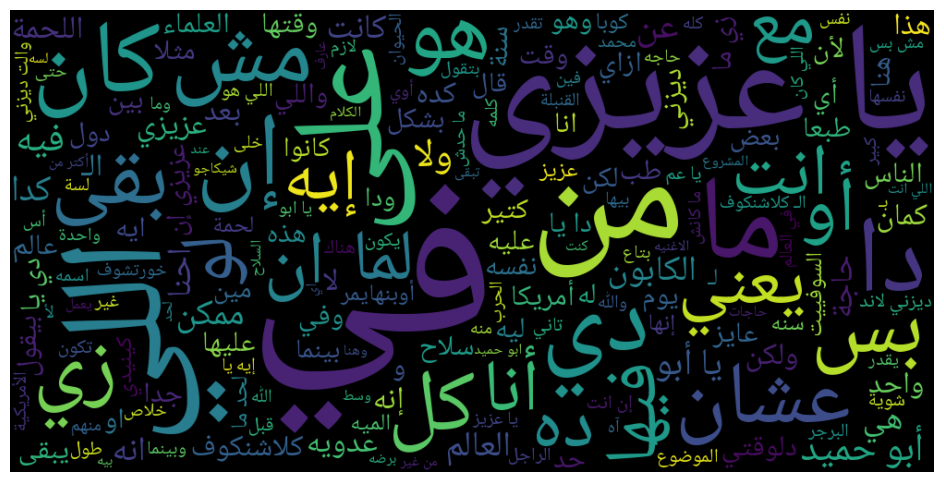

In [112]:
generate_arabic_wordcloud(raw_df)

### 2.3 Frequency Plots (Overall/Per document)

Let's plot the frequency of the most repeated words in our dataset

In [ ]:
def create_frequency_plots(df, stopwords=None, maxwords=20):
    """
    Generates a frequency plot of the most common words across all documents in a DataFrame.

    :param df: DataFrame containing a 'sentences' column with Arabic text.
    :param font_path: Path to an Arabic-supported font file.
    :param stopwords: List of stopwords to exclude from frequency counts.
    :param maxwords: Maximum number of words to display in the plot.
    """

    stopwords = set(stopwords) if stopwords else set()

    all_text = ' '.join([' '.join(sentences) for sentences in df['sentences']])

    reshaped_text = arabic_reshaper.reshape(all_text)
    words = reshaped_text.split()

    counts = Counter(words)
    counts = {get_display(word): count for word, count in counts.items() if word not in stopwords}
    counts = dict(sorted(counts.items(), key=lambda x: x[1], reverse=True)[:maxwords])

    plt.figure(figsize=(10, 6))
    palette = sns.color_palette("crest_r", n_colors=len(counts))
    palette = dict(zip(counts.keys(), palette))
    
    sns.barplot(y=list(counts.keys()), x=list(counts.values()), palette=palette)

    plt.xlabel("Word Frequency")
    plt.ylabel("Words (in Arabic)")
    plt.title("Most Common Words in Arabic Text")
    plt.show()


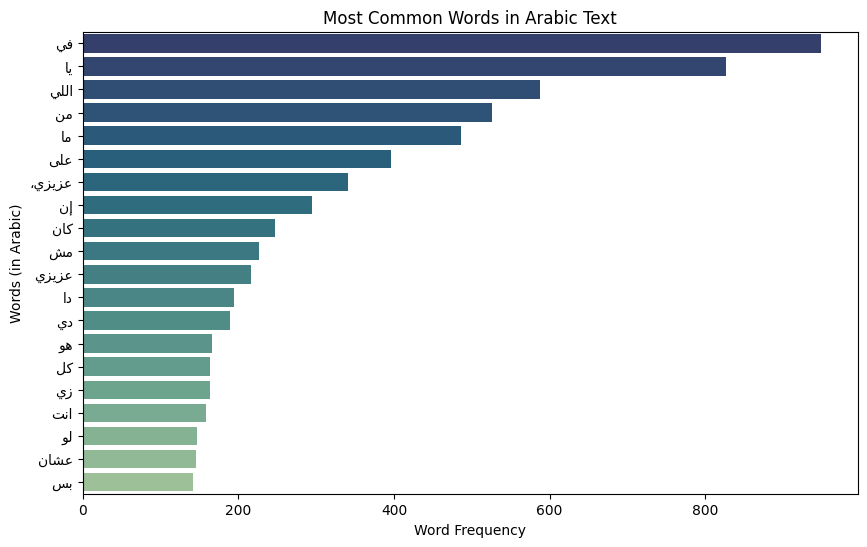

In [115]:
create_frequency_plots(raw_df)

### 2.4 TF-IDF


In [ ]:
def compute_tfidf(df: pd.DataFrame) -> pd.DataFrame:
    """
    Computes the TF-IDF matrix for all documents in a DataFrame.

    :param df: DataFrame containing text data.
    :return: DataFrame with TF-IDF scores for all documents.
    """

    df["document"] = df["sentences"].apply(lambda x: clean_arabic_text(' '.join(x)))

    vectorizer = TfidfVectorizer()

    X = vectorizer.fit_transform(df["document"])

    tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out(), index=df.index)

    return tfidf_df

In [117]:
compute_tfidf(raw_df)

ÿßÿ®ÿ™ÿØÿß     ÿßÿ®ÿ™ÿ≥ŸÖ     ÿßÿ®ÿ≠ÿßÿ´      ÿßÿ®ÿØÿß      ÿßÿ®ÿØŸä   ÿßÿ®ÿ±ÿßŸáŸäŸÖ     ÿßÿ®ÿ±ŸäŸÑ  \
0  0.000000  0.000000  0.013894  0.013894  0.000000  0.011735  0.013894   
1  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2  0.000000  0.018375  0.000000  0.000000  0.000000  0.000000  0.000000   
3  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4  0.000000  0.000000  0.000000  0.000000  0.000000  0.007944  0.000000   
5  0.000000  0.000000  0.000000  0.000000  0.007114  0.000000  0.000000   
6  0.009241  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
7  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
8  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

       ÿßÿ®ÿ≥ÿ∑    ÿßÿ®ÿπÿ™ŸÑŸä      ÿßÿ®ÿπÿØ  ...     ŸäŸàŸÑŸäŸà       ŸäŸàŸÖ     ŸäŸàŸÖŸÜÿß     ŸäŸàŸÖŸäÿß  \
0  0.013894  0.000000  0.000000  ...  0.000000  0.005324  0.000000  0.000000   
1  0.000000  0.000000  0.000000  ...  0.009449  0.004287  0.000000  0.000000   
2  0.000000  0.000000  0.000000  ...  0.000000  0.052814  0.000000  0.000000   
3  0.000000  0.000000  0.000000  ...  0.000000  0.003504  0.000000  0.000000   
4  0.000000  0.000000  0.000000  ...  0.000000  0.036043  0.000000  0.000000   
5  0.000000  0.000000  0.000000  ...  0.000000  0.008179  0.000000  0.007114   
6  0.000000  0.000000  0.009241  ...  0.000000  0.010624  0.009241  0.000000   
7  0.000000  0.000000  0.000000  ...  0.006616  0.024015  0.000000  0.000000   
8  0.000000  0.008343  0.000000  ...  0.000000  0.003197  0.000000  0.000000   

      ŸäŸàŸÖŸäŸÜ     ŸäŸàŸÜÿßÿ™     ŸäŸàŸÜŸäŸÜ     ŸäŸäÿ¨Ÿàÿß      ŸäŸäÿ¨Ÿä       ŸäŸäŸÜ  
0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
1  0.000000  0.000000  0.000000  0.000000  0.000000  0.009449  
2  0.000000  0.000000  0.000000  0.000000  0.006747  0.000000  
3  0.000000  0.018289  0.000000  0.000000  0.000000  0.000000  
4  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
5  0.000000  0.000000  0.007114  0.000000  0.000000  0.000000  
6  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
7  0.007833  0.000000  0.000000  0.015666  0.017257  0.006616  
8  0.000000  0.000000  0.000000  0.000000  0.006127  0.000000  

[9 rows x 10369 columns]

### 2.5 N-Grams

> <span style="color: green">**_N Grams:_**</span> is a sequence of n words in a text. Most words by themselves may not present the entire context. Typically adverbs such as 'most' or 'very' are used to modify verbs and adjectives. Therefore, n-grams help analyse phrases and not just words which can lead to better insights.

In [ ]:
def plot_arabic_ngrams(df: pd.DataFrame, n: int, top_k: int = 10):
    """
    Extracts and plots the top n-grams for Arabic text from a DataFrame.
    
    :param df: DataFrame containing the text data.
    :param top_k: Number of top bigrams to display.
    """

    df['document_text'] = df['sentences'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))
    
    corpus = ' '.join(df['document_text'])
    
    reshaped_corpus = get_display(arabic_reshaper.reshape(corpus))
    
    cv = CountVectorizer(ngram_range=(n,n))

    n_grams = cv.fit_transform([reshaped_corpus])
    
    count_values = n_grams.toarray().sum(axis=0)

    ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse=True))
    ngram_freq.columns = ["frequency", "ngram"]
    
    ngram_freq["ngram"] = ngram_freq["ngram"].apply(lambda x: get_display(arabic_reshaper.reshape(x)))
    
    title_text = get_display(arabic_reshaper.reshape(f"Top {top_k} Most Frequently Occurring {n}-grams"))
    xlabel_text = get_display(arabic_reshaper.reshape("Frequency"))
    ylabel_text = get_display(arabic_reshaper.reshape(f"{n}-gram"))
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=ngram_freq['frequency'][:top_k], y=ngram_freq['ngram'][:top_k])
    plt.title(title_text)
    plt.xlabel(xlabel_text)
    plt.ylabel(ylabel_text)
    
    plt.yticks(ticks=range(top_k), labels=[get_display(arabic_reshaper.reshape(x)) for x in ngram_freq['ngram'][:top_k]])
    
    plt.show()

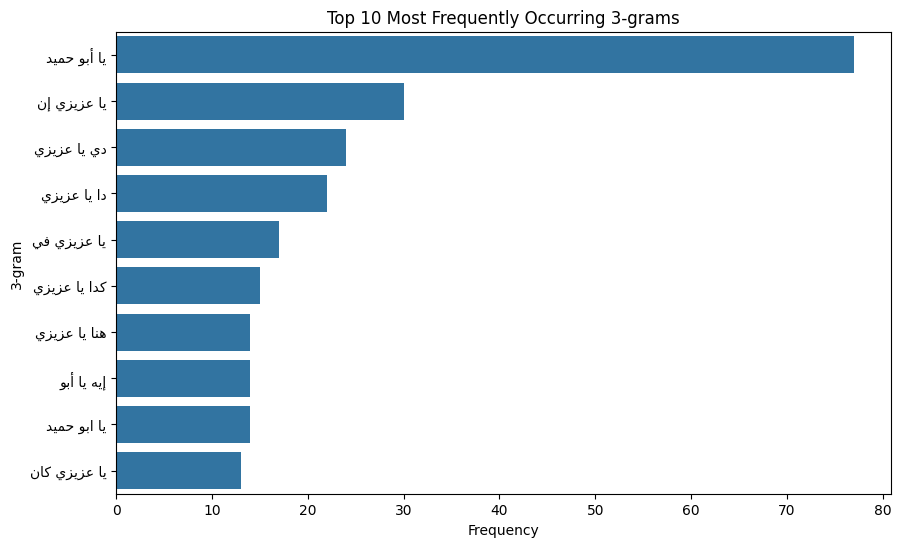

In [120]:
plot_arabic_ngrams(raw_df, 3)

### 2.6 Sentiment Analysis


In [141]:
def plot_sentiment_distribution(df):
    """
    Plots a bar chart of sentiment distribution from a given DataFrame column.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing sentiment data.
    """

    all_sentiments = []

    for sentiments_list in df['sentences_sentiment']:
        for sentiment in sentiments_list:
            all_sentiments = all_sentiments + str(sentiment).split()

    sentiment_counts = Counter(all_sentiments)
    print(sentiment_counts)

    plt.figure(figsize=(8, 5))
    plt.bar(sentiment_counts.keys(), sentiment_counts.values(), color=['green', 'red', 'blue'])
    plt.xlabel("Sentiment")
    plt.ylabel("Count")
    plt.title("Sentiment Analysis Distribution")
    plt.show()

Counter({'negative': 1801, 'neutral': 1582, 'positive': 595})


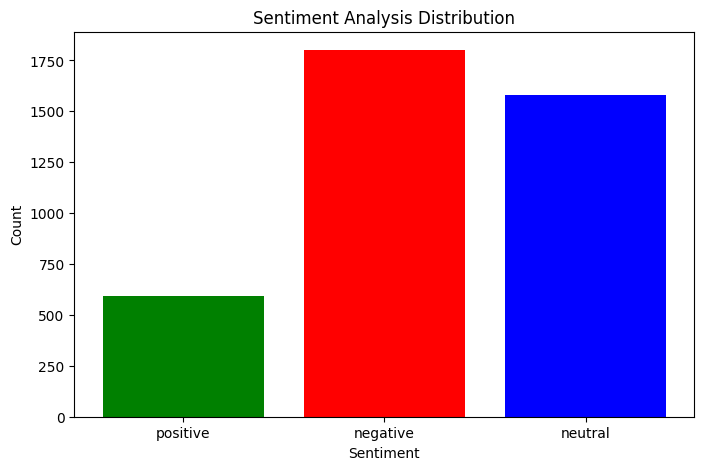

In [142]:
plot_sentiment_distribution(sentiment_df)

---

# <p style="padding:50px;background-color:#06402B;margin:0;color:#fafefe;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:100">Resources</p>

1. BERT for Arabic Topic Modeling: An Experimental Study on BERTopic Technique (https://github.com/iwan-rg/Arabic-Topic-Modeling?tab=readme-ov-file)
2. NYU ABU DHABI (https://nyuad.nyu.edu/en/research/faculty-labs-and-projects/computational-approaches-to-modeling-language-lab/research/arabic-natural-language-processing.html)
3. CAMeL Tools (https://camel-tools.readthedocs.io/en/latest/api.html)
4. Comprehensive Arabic NLP Data Processing and Cleaning Guide (https://github.com/h9-tect/Arabic_nlp_preprocessing)
5. PyArabic (https://pyarabic.readthedocs.io/ar/latest/)
6. AUB MIND LAB (https://huggingface.co/aubmindlab)
7. AraBERT (https://github.com/aub-mind/arabert/tree/master)
8. Awesome Resources for Arabic NLP Repo (https://github.com/Curated-Awesome-Lists/awesome-arabic-nlp?tab=readme-ov-file)
9. Arabic Dialect Identification Models (https://github.com/Lafifi-24/arabic-dialect-identification?tab=readme-ov-file)
10. AraVec (https://github.com/bakrianoo/aravec/blob/master/AraVec%202.0/README.md)
11. Text Classifier (https://github.com/mustaphakamil/Arabic-text-classification/blob/master/Text%20Classifier%20NLP.ipynb)
12. BERT for Arabic Topic Modeling (https://colab.research.google.com/drive/1OT_wcYKpKS73uR6y7IVYjJVxaP-C1H3k?usp=sharing#scrollTo=SNa-KtKDRnus)
13. Dialect Identification (https://medium.com/@kmelad43/arabic-dialect-identification-774de9315140)
14. Detecting Sarcasm (https://medium.com/@rehabreda/unraveling-sarcasm-in-arabic-with-arabert-a-comprehensive-guide-from-data-preprocessing-to-a4dc7e30b39d)
15. Topic Modeling (https://colab.research.google.com/drive/1OT_wcYKpKS73uR6y7IVYjJVxaP-C1H3k?usp=sharing)